In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.util import path_expand
from tensorflow import keras
import tensorflow as tf
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
import math
import datetime as dt
from configuration import read_config
import os

In [2]:
StopWatch.start('all')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL

In [3]:
config = read_config("config-jp.yaml")
config.max_period = False

# config.debug = False
print (config)
config.debug=True

epochs=[2, 10,50, 75, 100, 125, 150, 175, 200, 225]
repeat=5
list_of_cryptos = ["EOS-USD", "BTC-USD", "ETH-USD", "DOGE-USD"]
#list_of_cryptos = ["BTC-USD"]

{'debug': True, 'user': 'jp', 'node': '3600-GTX1660', 'experiments.epoch': [1, 2, 10, 20, 30], 'experiments.gpu': ['K80', 'A100', 'V100', 'P100'], 'max_period': False}


In [4]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [5]:
def lstm_crypto_benchmark(crypto, id=0, epoch=100, output=True):
    #"EOS-USD", "DOGE-USD",\n"ETH-USD", and "BTC-USD"
    # print(crypto + ' selected')

    StopWatch.start(f"total-{crypto}-{epoch}-{id}")

    # Creating desktop path to save figures to the desktop

    if output:
        pdfpath = path_expand(f"graphics/{config.user}-{config.node}-{crypto}-{epoch}-{id}-prediction-model.pdf")
        pdfpath2 = path_expand(f"graphics/{config.user}-{config.node}-{crypto}-{epoch}-{id}-prediction-model-zoomed.pdf")
        pdfpath3 = path_expand(f"graphics/{config.user}-{config.node}-{crypto}-{epoch}-{id}-price.pdf")
        pdfpath4 = path_expand(f"graphics/{config.user}-{config.node}-{crypto}-{epoch}-{id}-training-loss.pdf")
        pdfpath5 = path_expand(f"graphics/{config.user}-{config.node}-{crypto}-{epoch}-{id}-epoch.pdf")
        pdfpath6 = path_expand(f"graphics/{config.user}-{config.node}-{crypto}-{epoch}-{id}-prediction-model-zoomed.pdf")

        register_matplotlib_converters()

    ticker = yf.Ticker(crypto)
    if config.max_period:
        data = ticker.history(start="2017-11-09", end="2022-06-15", interval="1d")
    else:
        data = ticker.history(period="max", interval="1d")
    # print(data)
    # Sort the dataframe according to the date
    data.sort_values('Date', inplace=True, ascending=True)

    # Print the dataframe top

    if output:
        data.head()

        # Visualization of data. Plotting the price close.
        plt.figure(num=None, figsize=(7, 4), dpi=300, facecolor='w', edgecolor='k')
        days = mdates.drange(data.index.min(), data.index.max() + dt.timedelta(days=1), dt.timedelta(days=1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))
        if len(days) > len(data['Close']):
            plt.plot(days[:-1], data['Close'])
        elif len(days) < len(data['Close']):
            plt.plot(days, data['Close'].iloc[:-1])
        else:
            plt.plot(days, data['Close'])
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.grid()
        plt.ylabel('Closing Price in USD')
        plt.xlabel('Date')
        plt.tight_layout()
        plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
        # plt.savefig(fullpath3, dpi=300, facecolor="#FFFFFF")
        plt.savefig(pdfpath3, dpi=300)
        plt.show()

        print(data.index[0])

    firstDate = data.index[0]
    firstDateFormatted = pd.to_datetime(data.index[0], utc=False)

    if output:
        print(firstDateFormatted)

    date_time_obj = firstDateFormatted.to_pydatetime()
    trueFirstDate = date_time_obj.strftime('%m/%d/%Y')

    if output:
        print(trueFirstDate)
        print(data.head())

    # Get Close data
    df = data[['Close']].copy()
    # Split data into train and test
    train, test = df.iloc[0:-200], df.iloc[-200:len(df)]

    if output:
        print(len(train), len(test))

    train_max = train.max()
    train_min = train.min()

    # Normalize the dataframes
    train = (train - train_min) / (train_max - train_min)
    test = (test - train_min) / (train_max - train_min)
    time_steps = 10

    X_train, y_train = create_dataset(train, train.Close, time_steps)
    X_test, y_test = create_dataset(test, test.Close, time_steps)

    StopWatch.start(f"training-{crypto}-{epoch}-{id}")

    model = keras.Sequential()
    model.add(keras.layers.LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mae', optimizer='adam')
    model_diagram = path_expand('./graphics/model_plot_diagram')
    if output:
        model.summary()
        tf.keras.utils.plot_model(model, to_file=f'{model_diagram}.pdf', show_shapes=True, show_layer_names=True)
        #tf.keras.utils.plot_model(model, to_file=f'{model_diagram}.svg', show_shapes=True, show_layer_names=True)
        tf.keras.utils.plot_model(model, to_file=f'{model_diagram}.png', show_shapes=True, show_layer_names=True)


    history = model.fit(
        X_train, y_train,
        epochs=epoch,
        batch_size=32,
        shuffle=False,
        verbose=0
    )


    StopWatch.stop(f"training-{crypto}-{epoch}-{id}")

    if output:
        # Plotting the loss
        plt.plot(history.history['loss'], label='train')
        plt.legend()
        plt.ylabel('Model Loss')
        plt.xlabel('Number of Epochs')
        plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
        plt.savefig(pdfpath4, dpi=300)
        plt.show()

    StopWatch.start(f"prediction-{crypto}-{epoch}-{id}")

    y_pred = model.predict(X_test, verbose=0)

    StopWatch.stop(f"prediction-{crypto}-{epoch}-{id}")

    # Rescale the data back to the original scale
    y_test = y_test * (train_max[0] - train_min[0]) + train_min[0]
    y_pred = y_pred * (train_max[0] - train_min[0]) + train_min[0]
    y_train = y_train * (train_max[0] - train_min[0]) + train_min[0]

    if output:
        # Plotting the results
        plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', markersize=1,
                 label="true")
        plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', markersize=1,
                 label="prediction")
        plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', markersize=1, label="history")
        plt.ylabel('Closing Price in USD')
        plt.xlabel('Days Since ' + trueFirstDate)
        leg = plt.legend()
        leg_lines = leg.get_lines()
        leg_texts = leg.get_texts()
        plt.setp(leg_lines, linewidth=1)
        plt.setp(leg_texts, fontsize='x-large')
        plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
        plt.savefig(pdfpath, dpi=300)
        # doge plt.axis([1350, 1450, 0.14, 0.35])
        # btc plt.axis([2490, 2650, 34000, 73000])
        # eth plt.axis([1370, 1490, 2200, 5800])
        # plt.axis([1440, 1500, 2, 6])
        # plt.title('5 Epochs', fontsize=20)
        plt.savefig(pdfpath5, dpi=300)
        if crypto == "EOS-USD":
            plt.axis([1500, 1560, 1.5, 4.2])
            plt.savefig(pdfpath6, dpi=300)
        elif crypto == "BTC-USD":
            plt.axis([2620, 2750, 31000, 60000])
            plt.savefig(pdfpath6, dpi=300)
        elif crypto == "ETH-USD":
            plt.axis([1500, 1600, 2200, 4000])
            plt.savefig(pdfpath6, dpi=300)
        elif crypto == "DOGE-USD":
            plt.axis([1500, 1600, 0.09, 0.22])
            plt.savefig(pdfpath6, dpi=300)

        plt.show()

        print(y_test.shape)
        print(y_pred.shape)

    ## Outputs error in United States Dollars
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    StopWatch.event(f"RMSE-{crypto}-{epoch}-{id}", rmse)
    #math.sqrt(mean_squared_error(y_test, y_pred))
    ## Create a table of the error against the number of epochs

    StopWatch.stop(f"total-{crypto}-{epoch}-{id}")
    t = StopWatch.get(f"total-{crypto}-{epoch}-{id}")
    print(f"Root mean squared error and time {crypto}: {rmse}, {t} s")



LSTM run 1/200, 2, EOS-USD


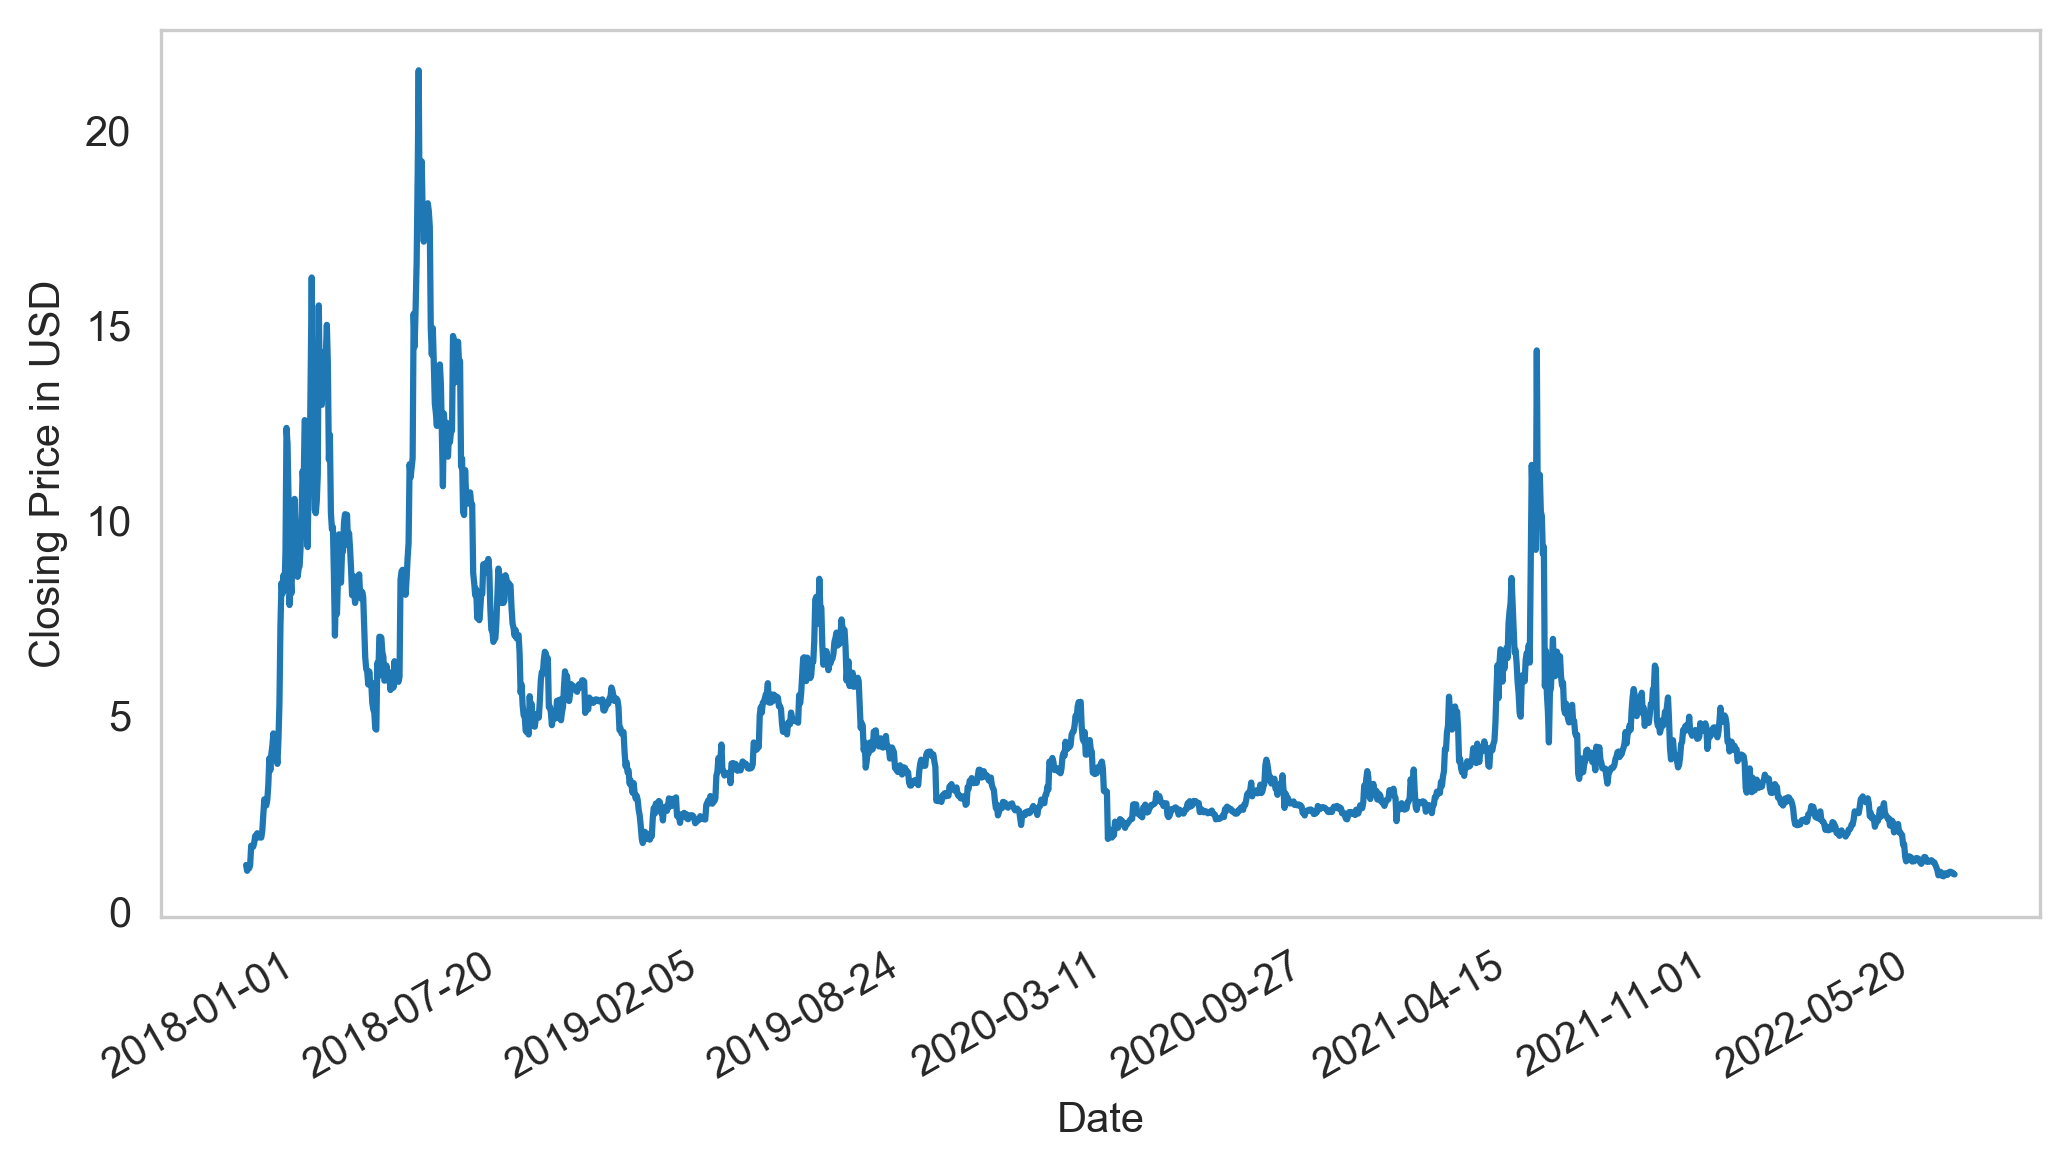

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               252000    
                                   

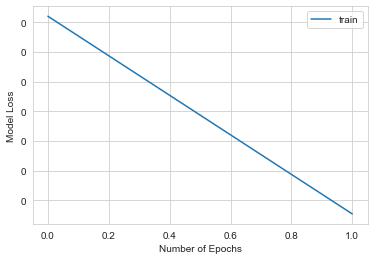

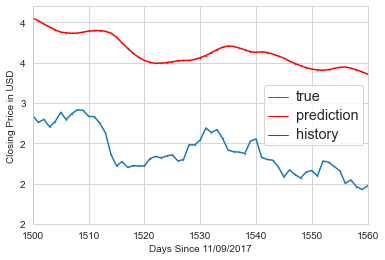

(190,)
(190, 1)
Root mean squared error and time EOS-USD: 1.3325235085193659, 5.5849 s
LSTM run 2/200, 2, EOS-USD


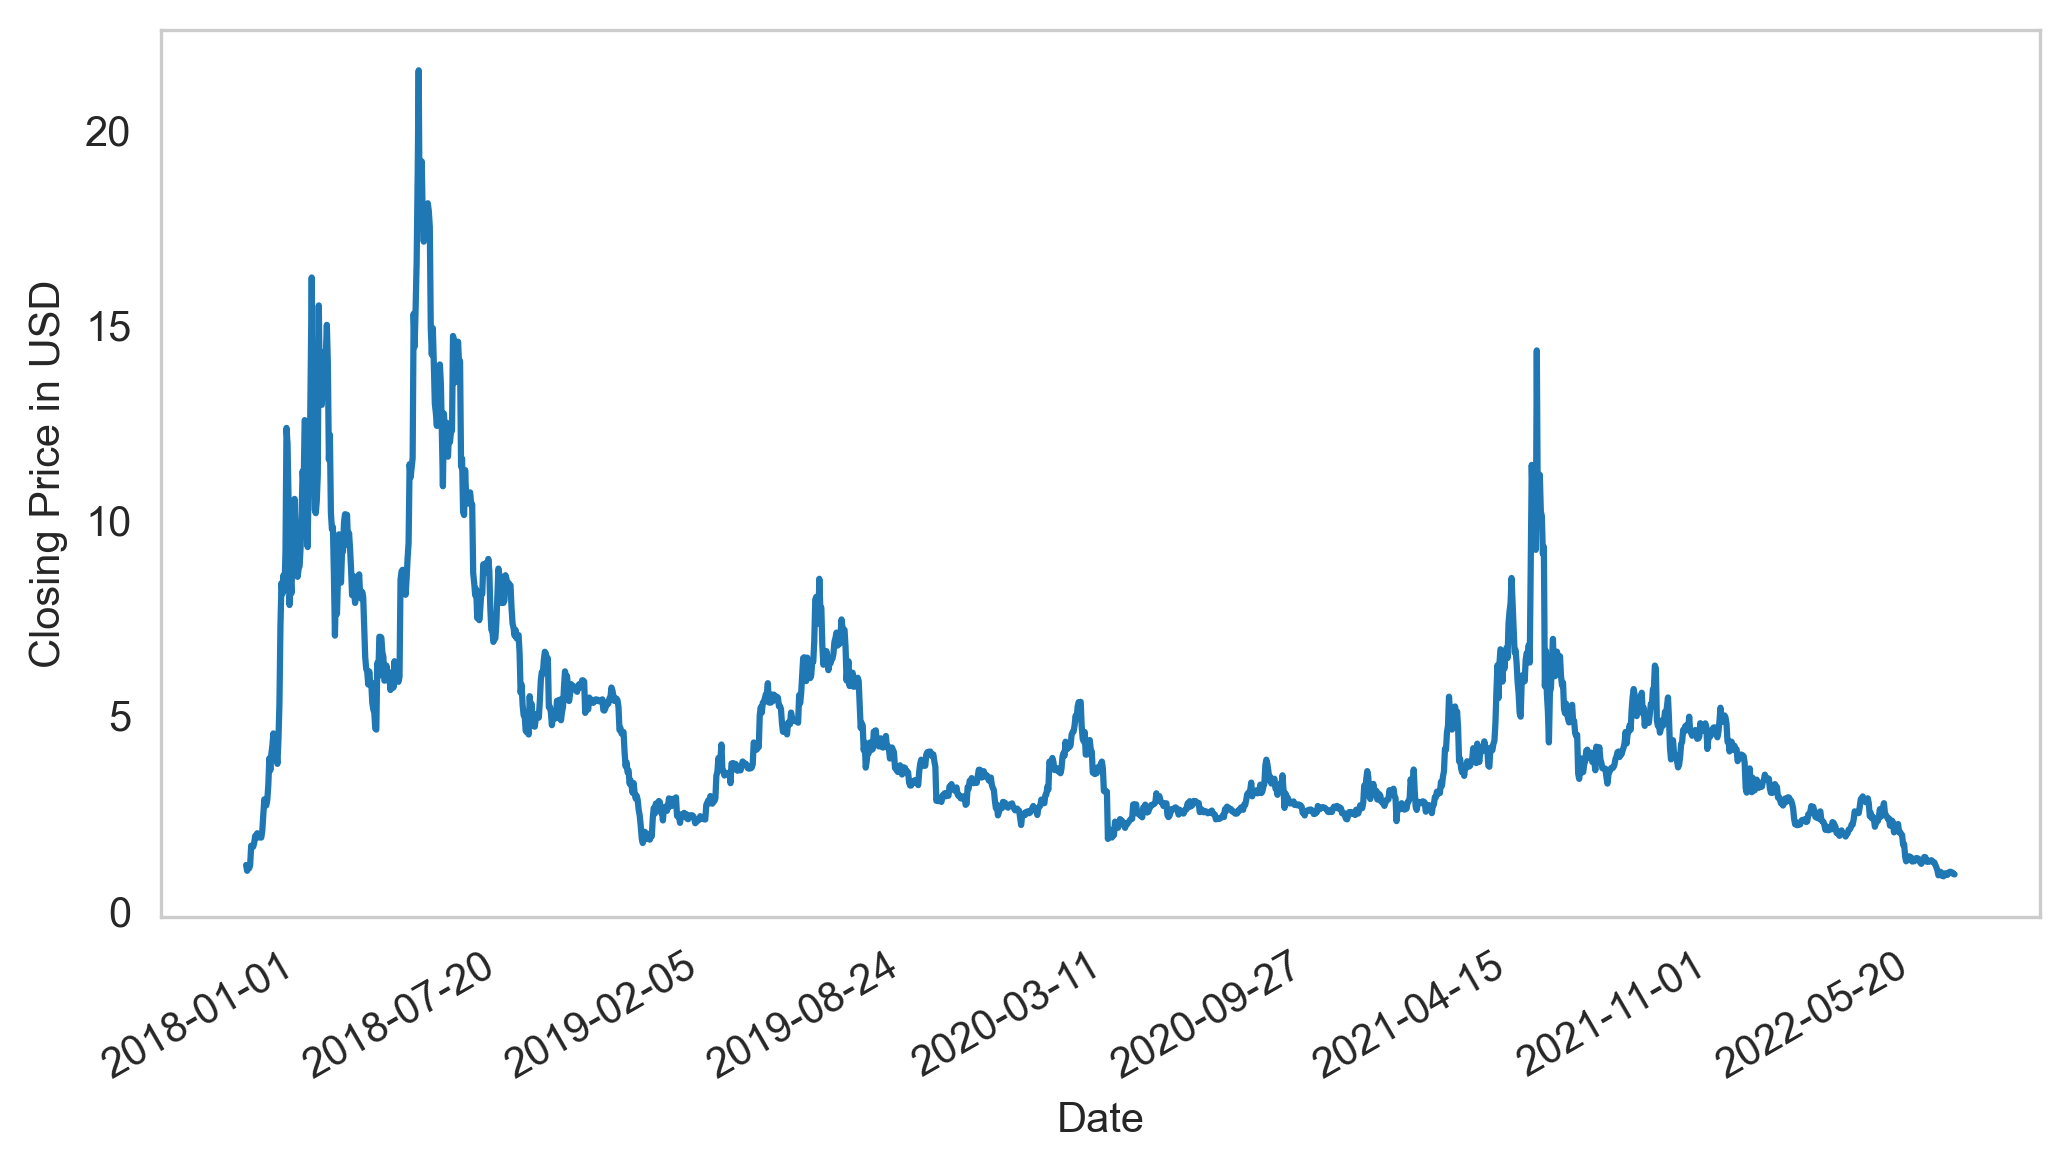

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 250)               252000    
                                 

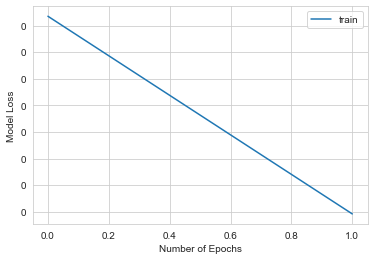

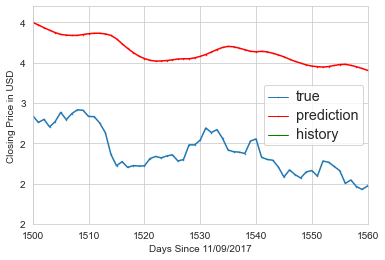

(190,)
(190, 1)
Root mean squared error and time EOS-USD: 1.3780179490513593, 4.6319 s
LSTM run 3/200, 2, EOS-USD


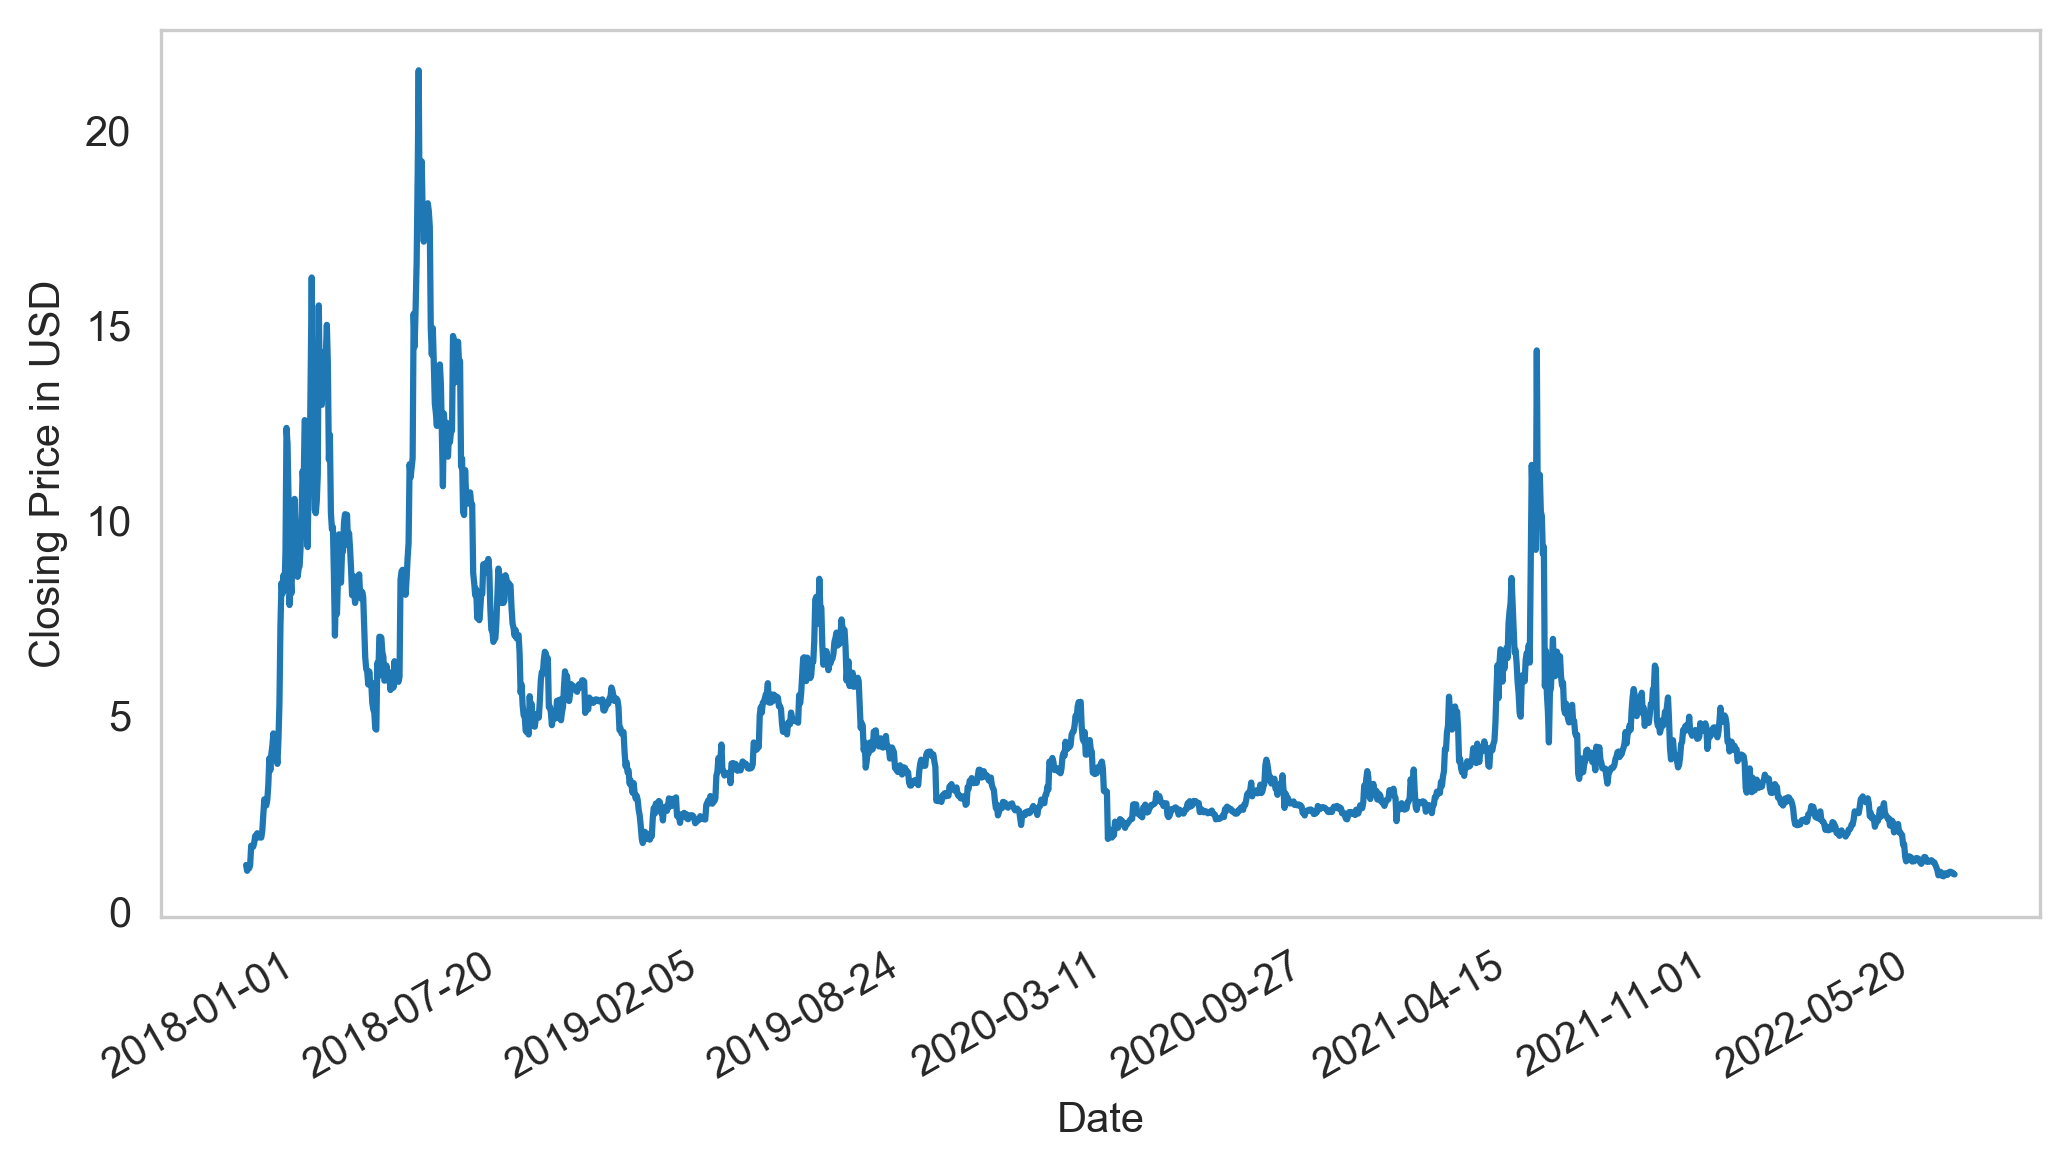

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 250)               252000    
                                 

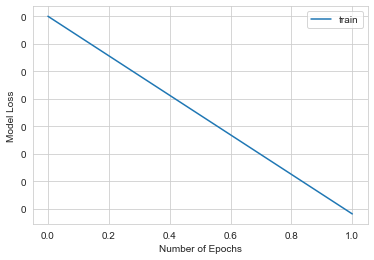

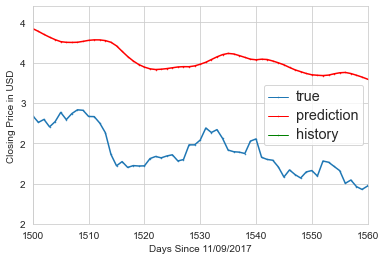

(190,)
(190, 1)
Root mean squared error and time EOS-USD: 1.2723344614226226, 5.2056 s
LSTM run 4/200, 2, EOS-USD


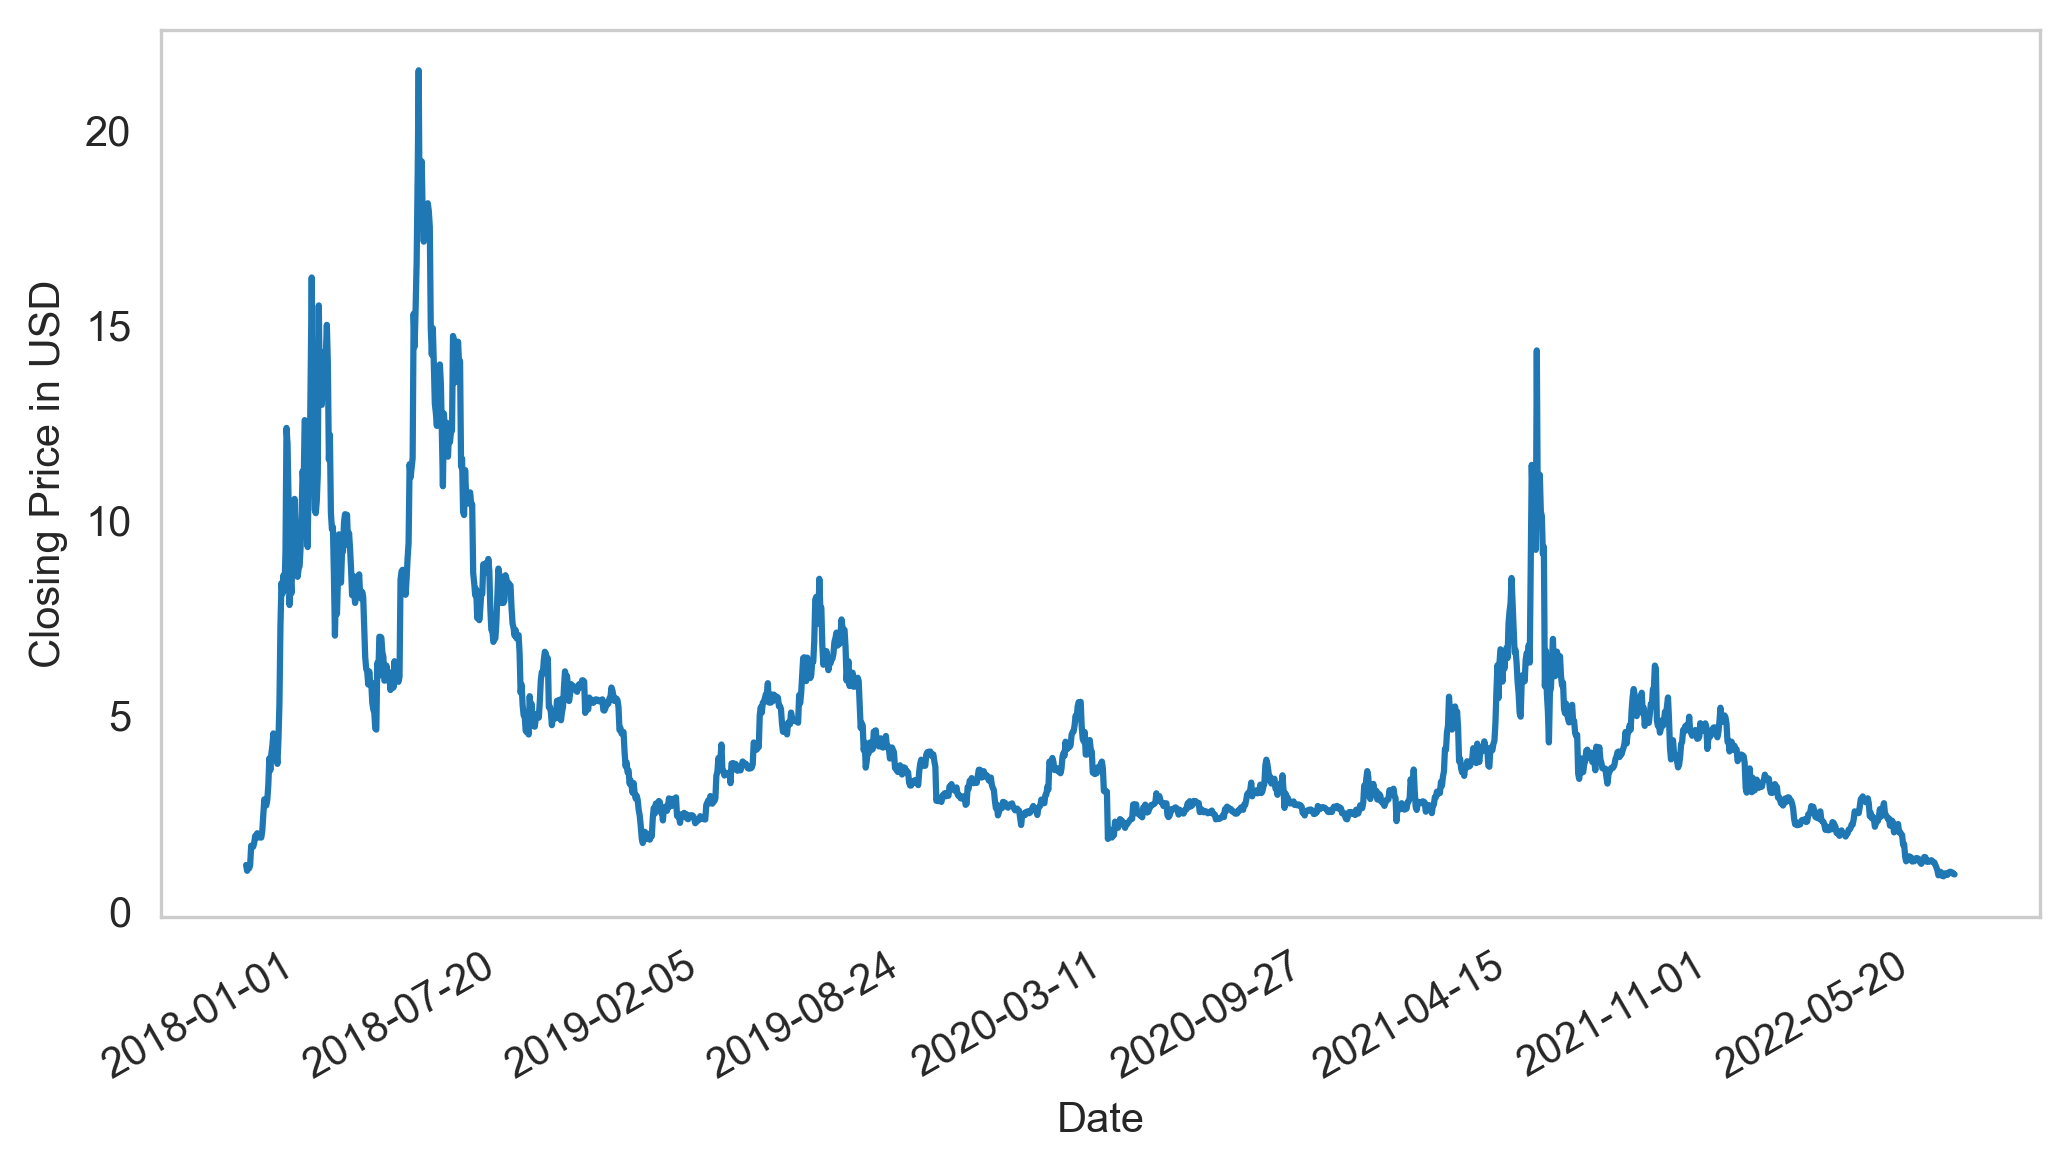

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 250)               252000    
                                 

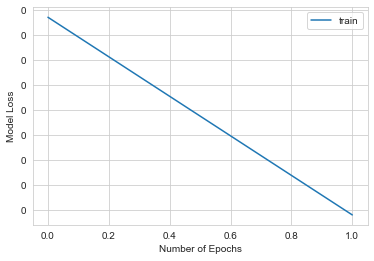

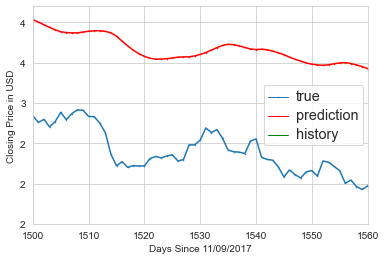

(190,)
(190, 1)
Root mean squared error and time EOS-USD: 1.3988290725411572, 4.7836 s
LSTM run 5/200, 2, EOS-USD


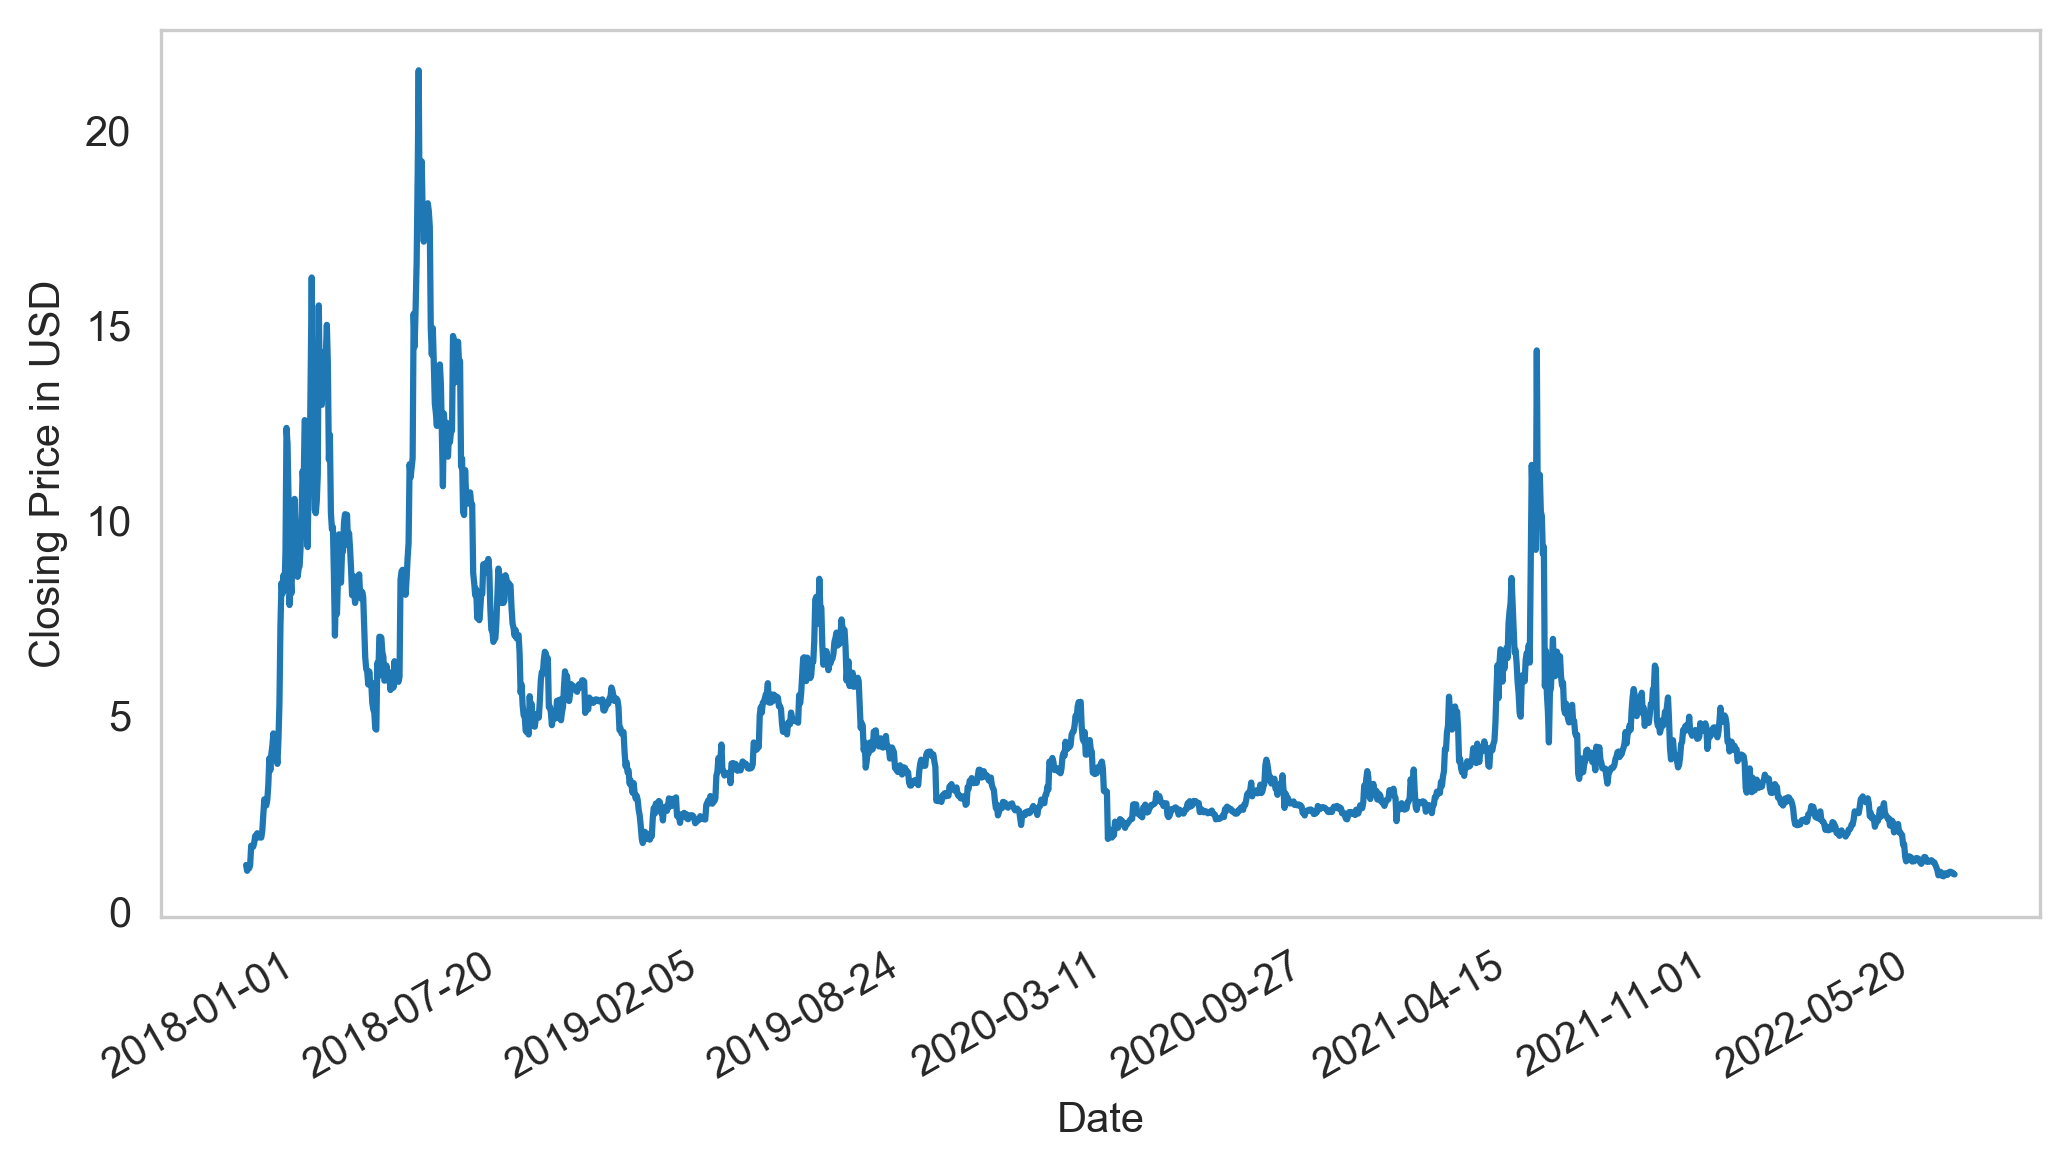

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 250)               252000    
                                 

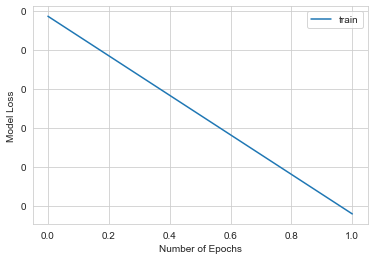

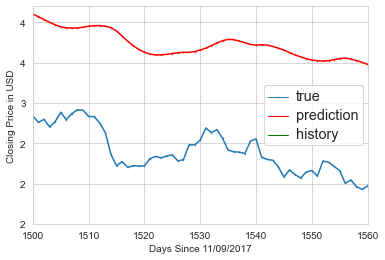

(190,)
(190, 1)
Root mean squared error and time EOS-USD: 1.4497045278575338, 4.6033 s
LSTM run 6/200, 2, BTC-USD


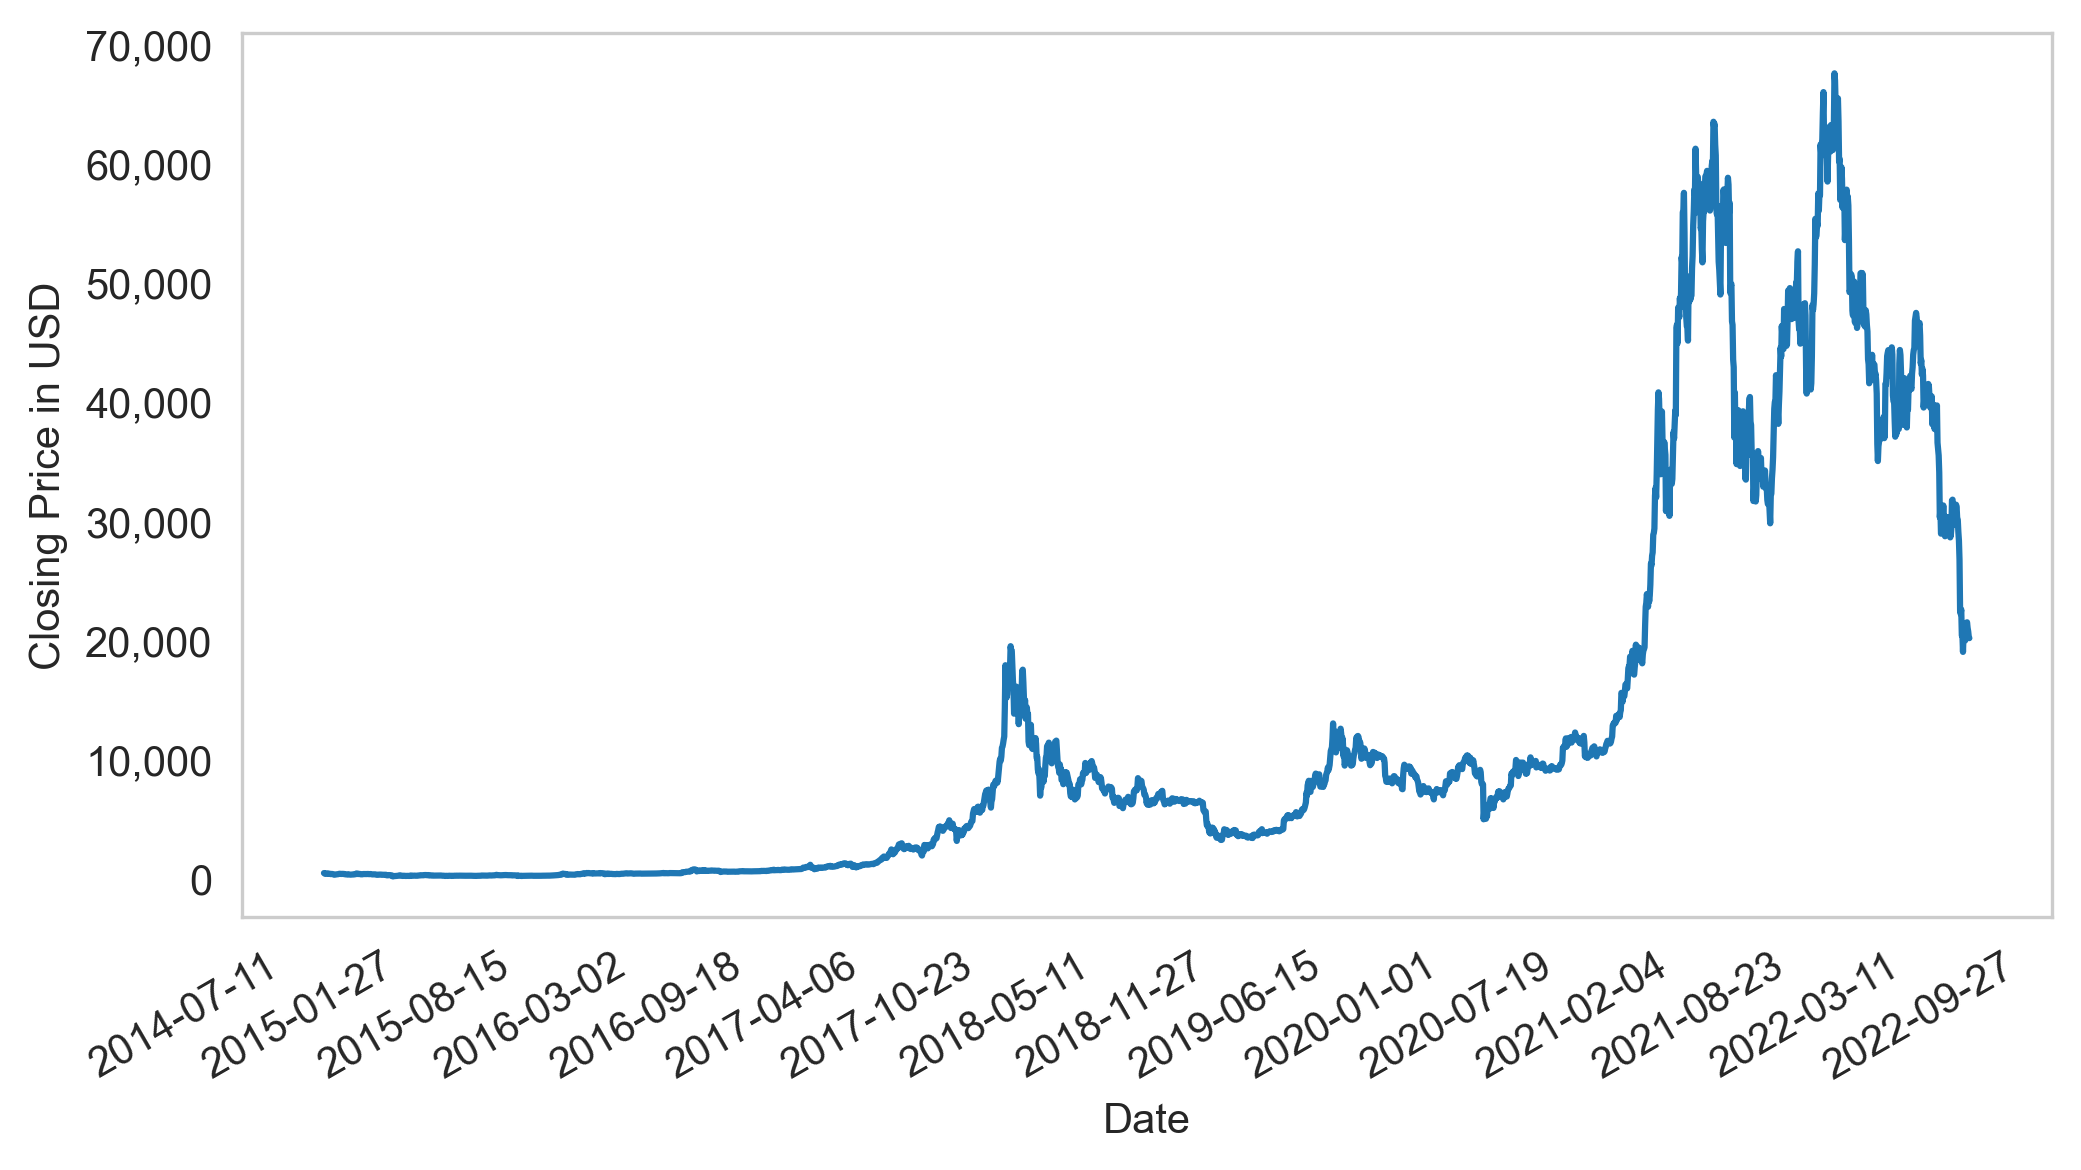

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2643 200
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM) 

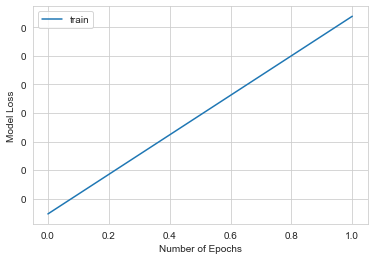

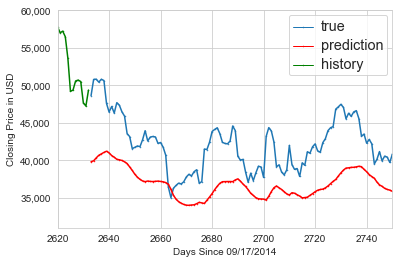

(190,)
(190, 1)
Root mean squared error and time BTC-USD: 4893.559651941423, 6.4415 s
LSTM run 7/200, 2, BTC-USD


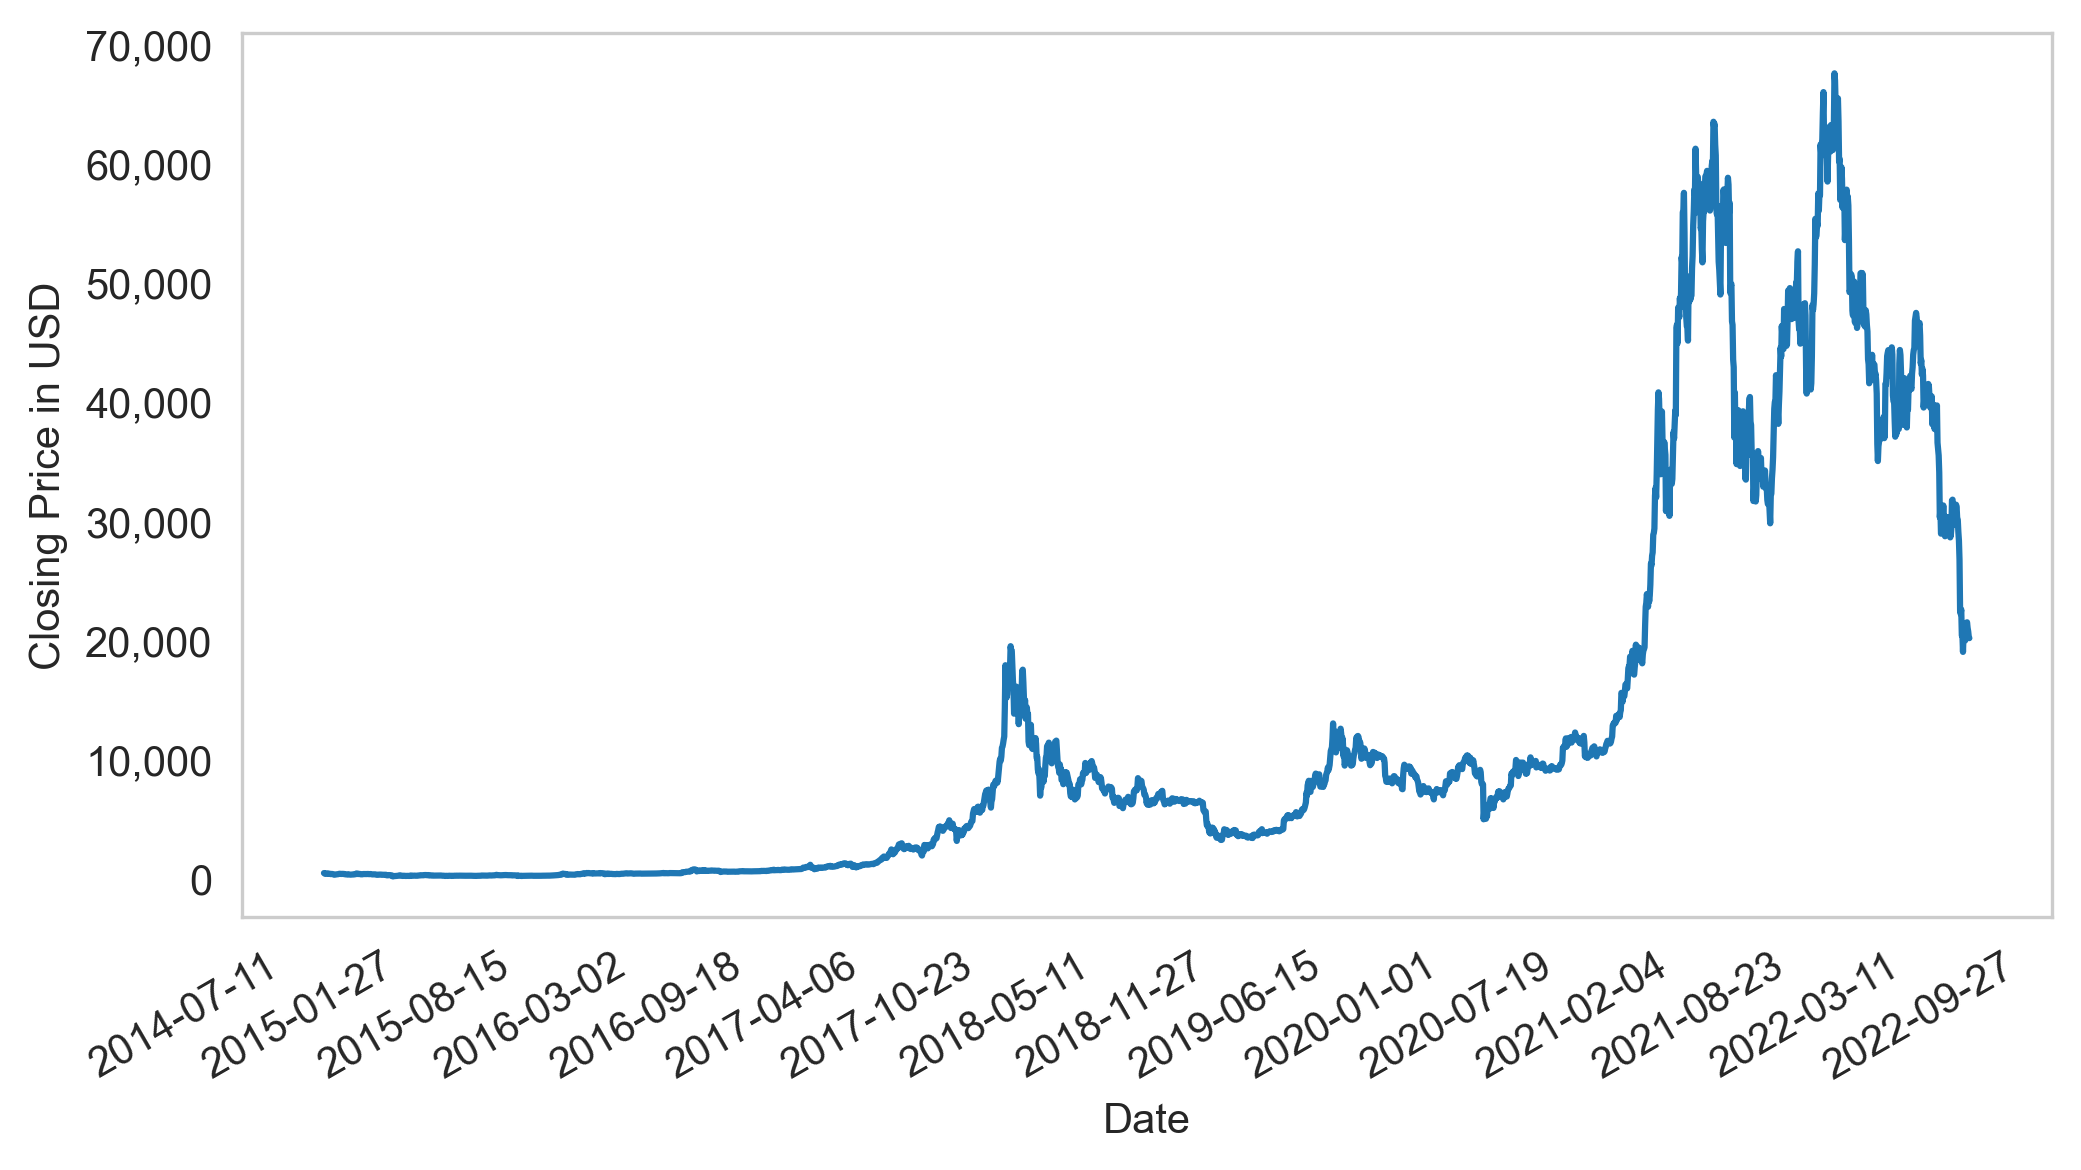

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2643 200
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM) 

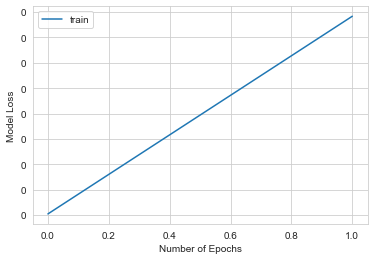

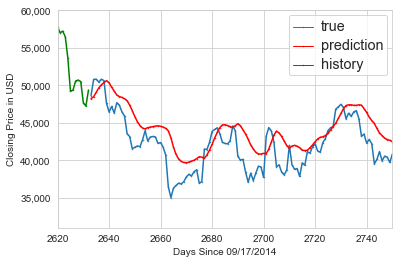

(190,)
(190, 1)
Root mean squared error and time BTC-USD: 3817.1842317527435, 6.2965 s
LSTM run 8/200, 2, BTC-USD


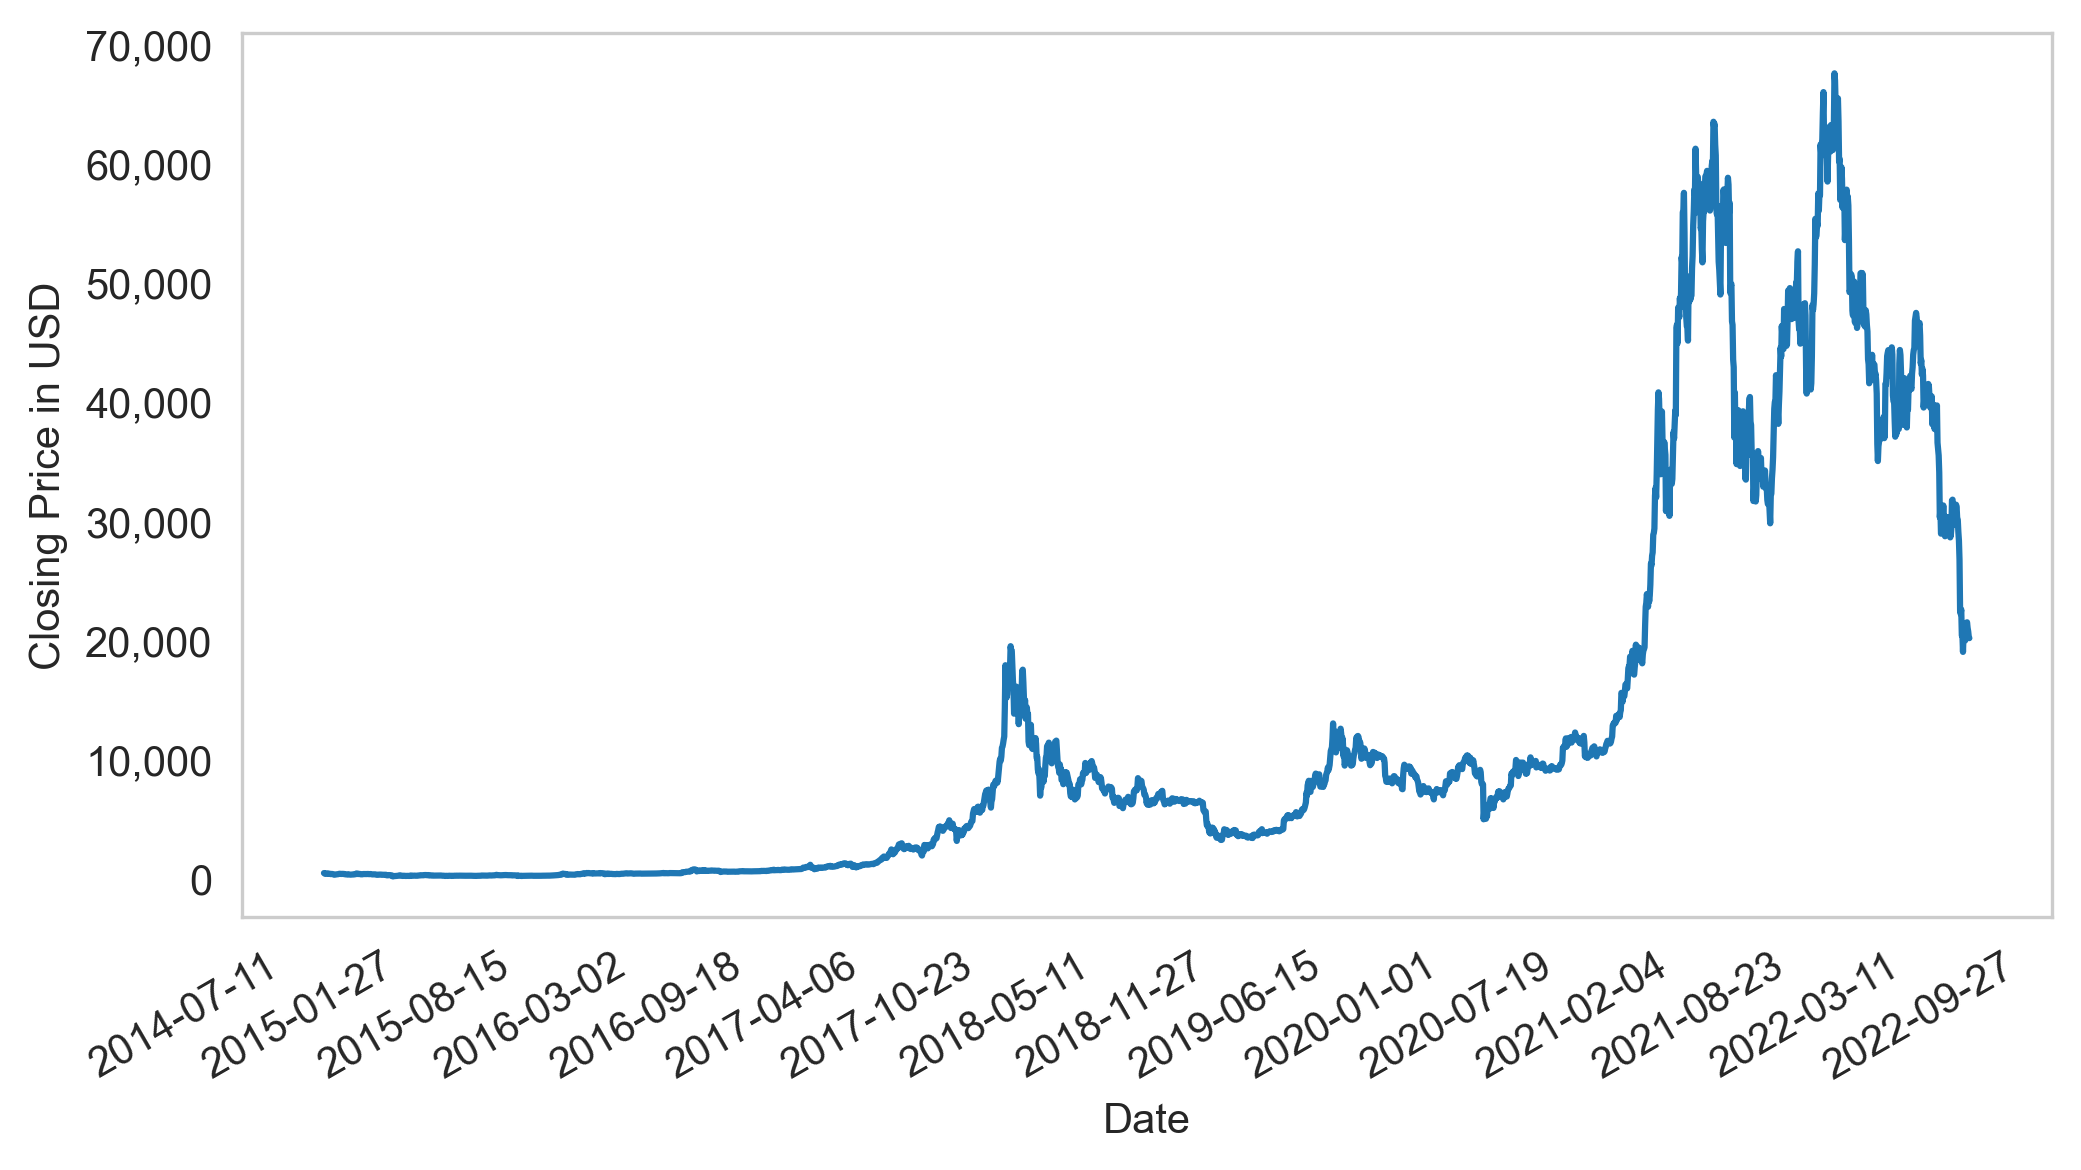

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2643 200
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM) 

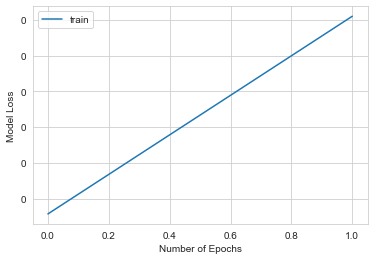

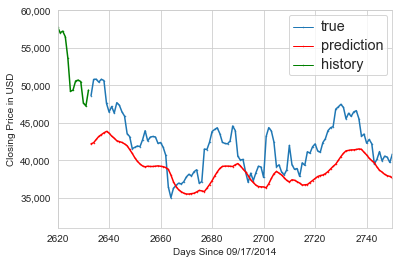

(190,)
(190, 1)
Root mean squared error and time BTC-USD: 3593.08308754312, 6.2029 s
LSTM run 9/200, 2, BTC-USD


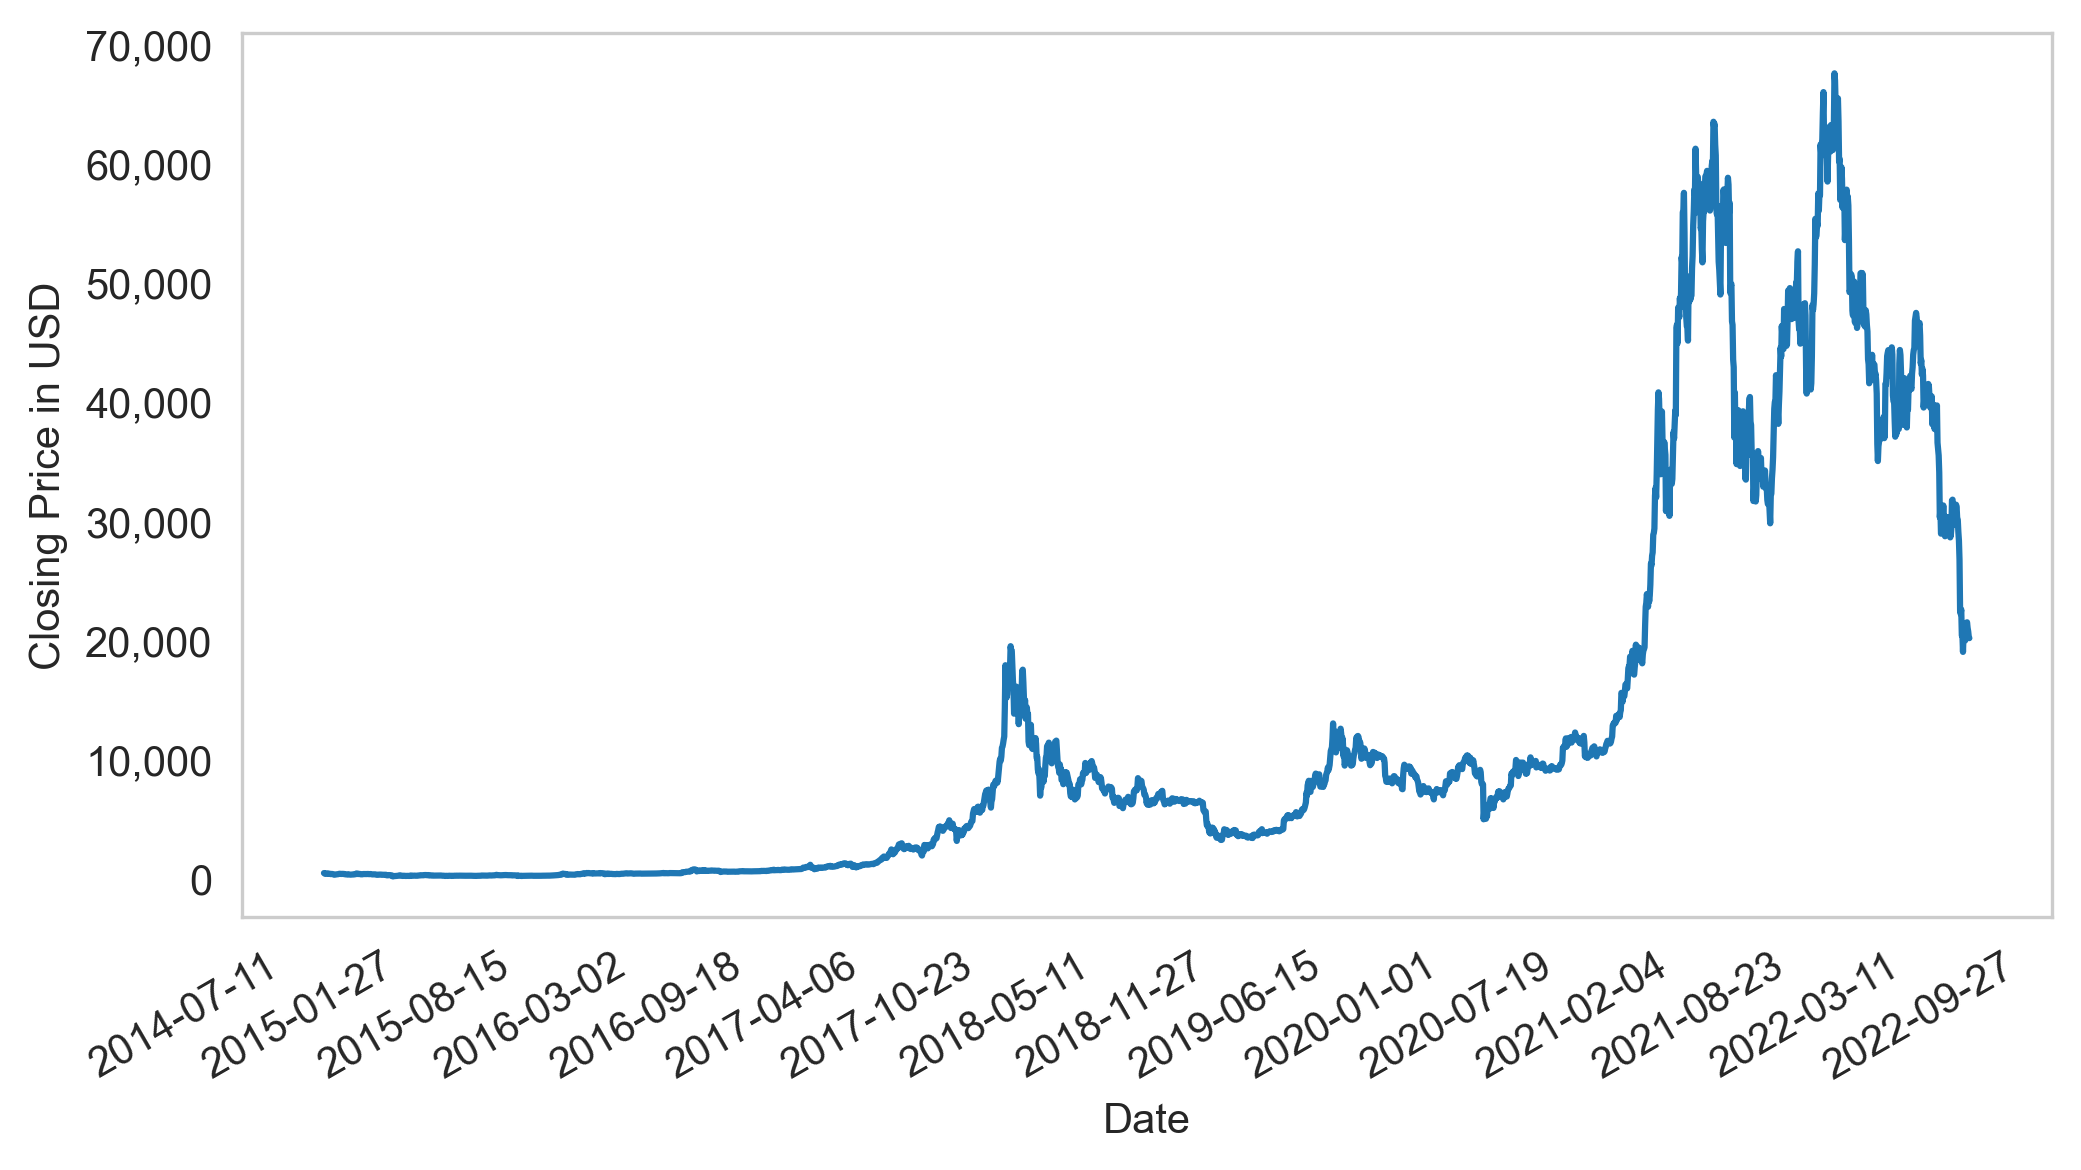

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2643 200
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM) 

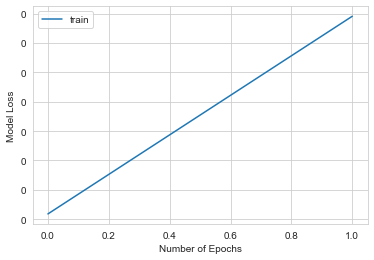

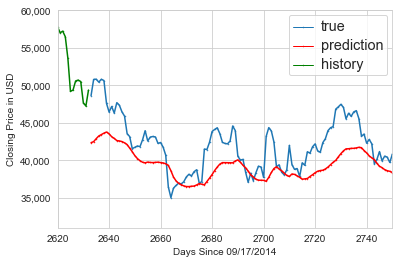

(190,)
(190, 1)
Root mean squared error and time BTC-USD: 3750.5814197641757, 6.1658 s
LSTM run 10/200, 2, BTC-USD


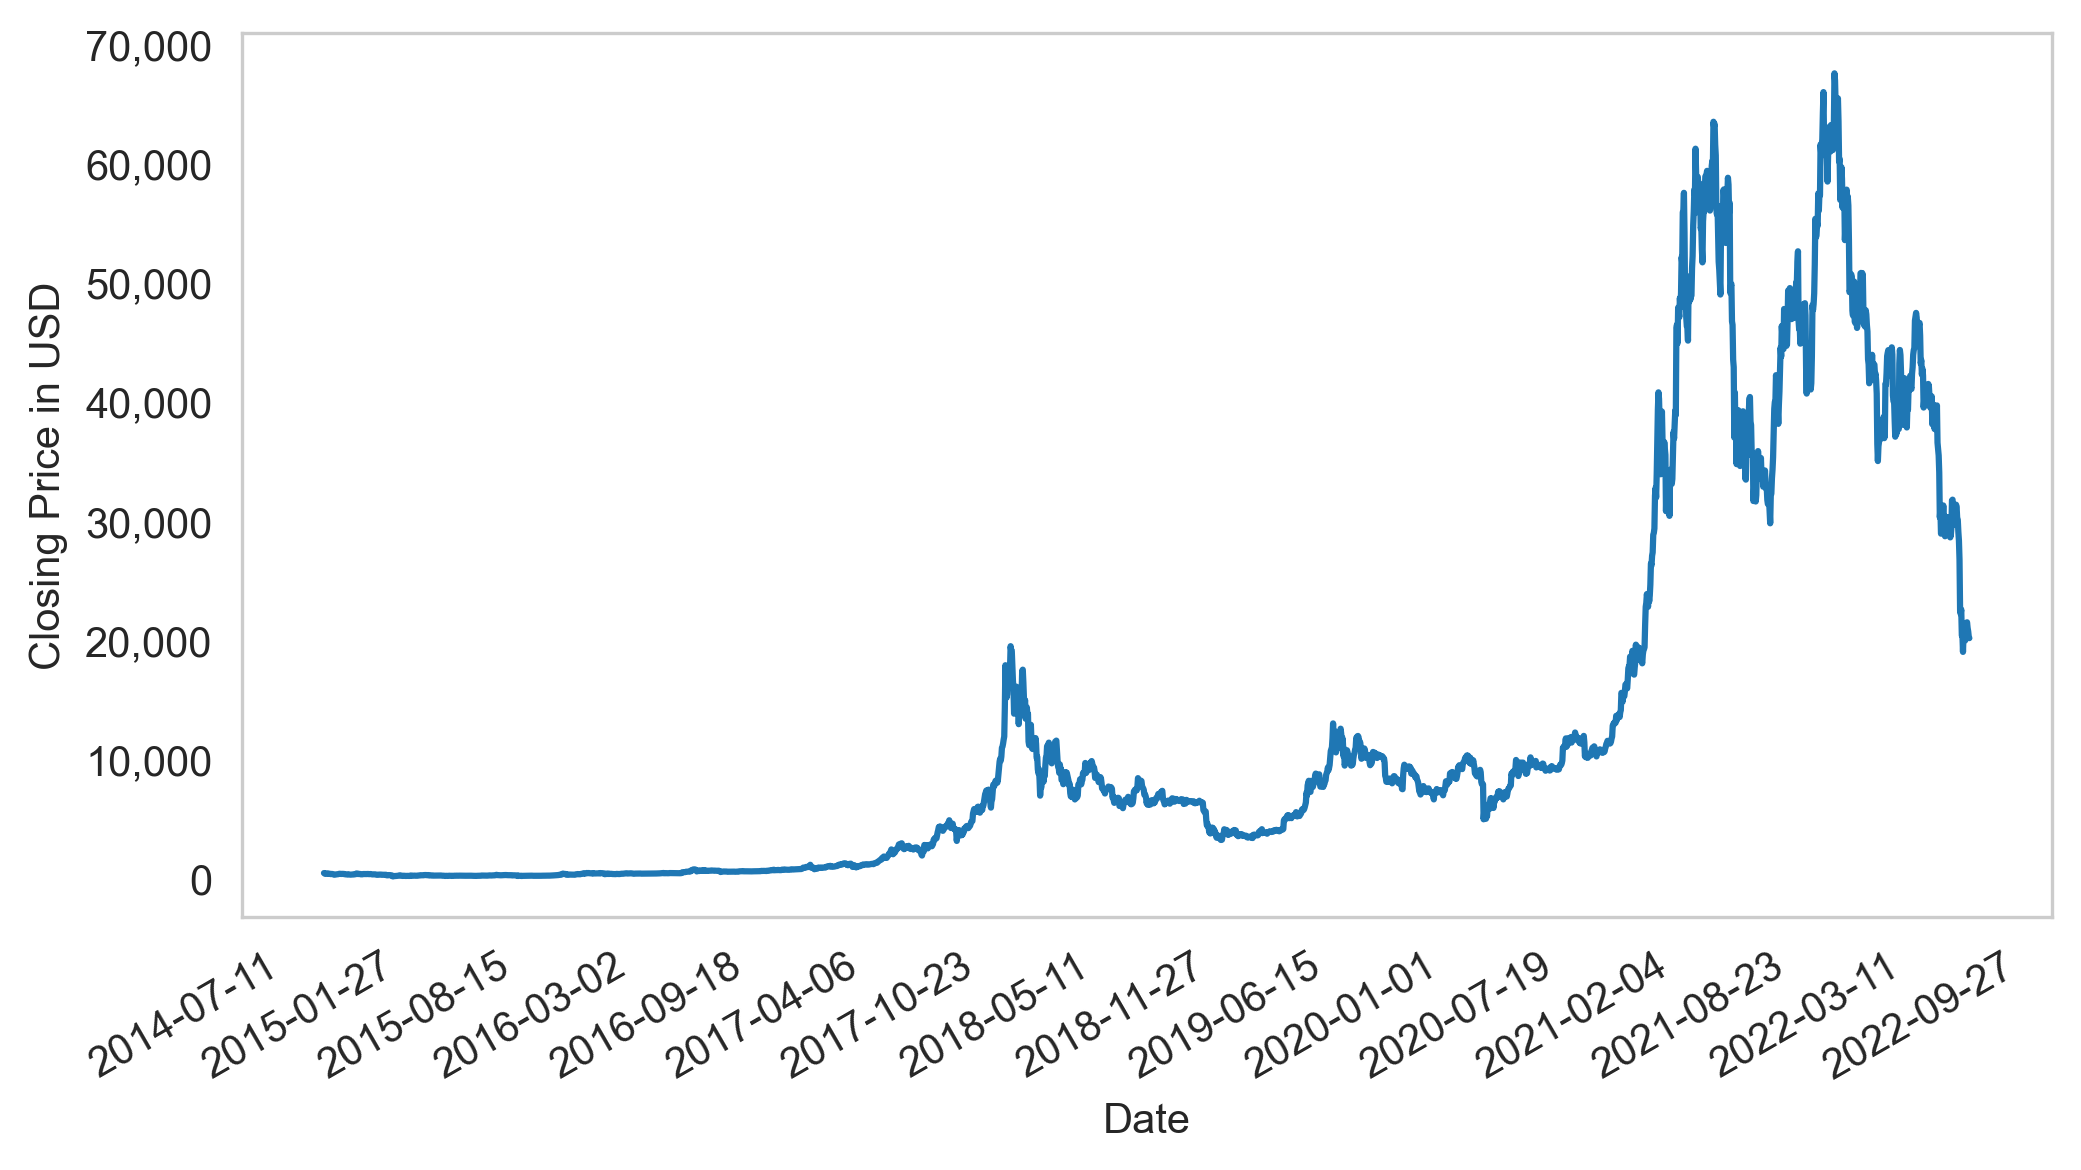

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2643 200
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM) 

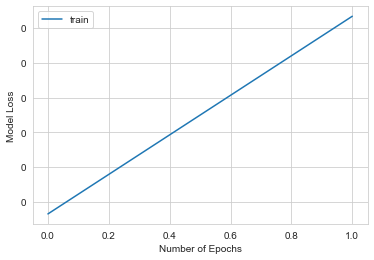

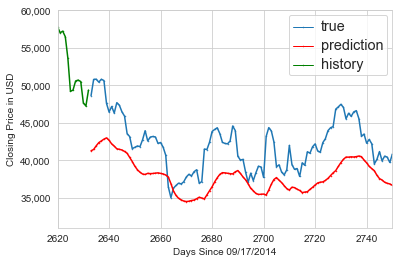

(190,)
(190, 1)
Root mean squared error and time BTC-USD: 4066.4705779138585, 5.9688 s
LSTM run 11/200, 2, ETH-USD


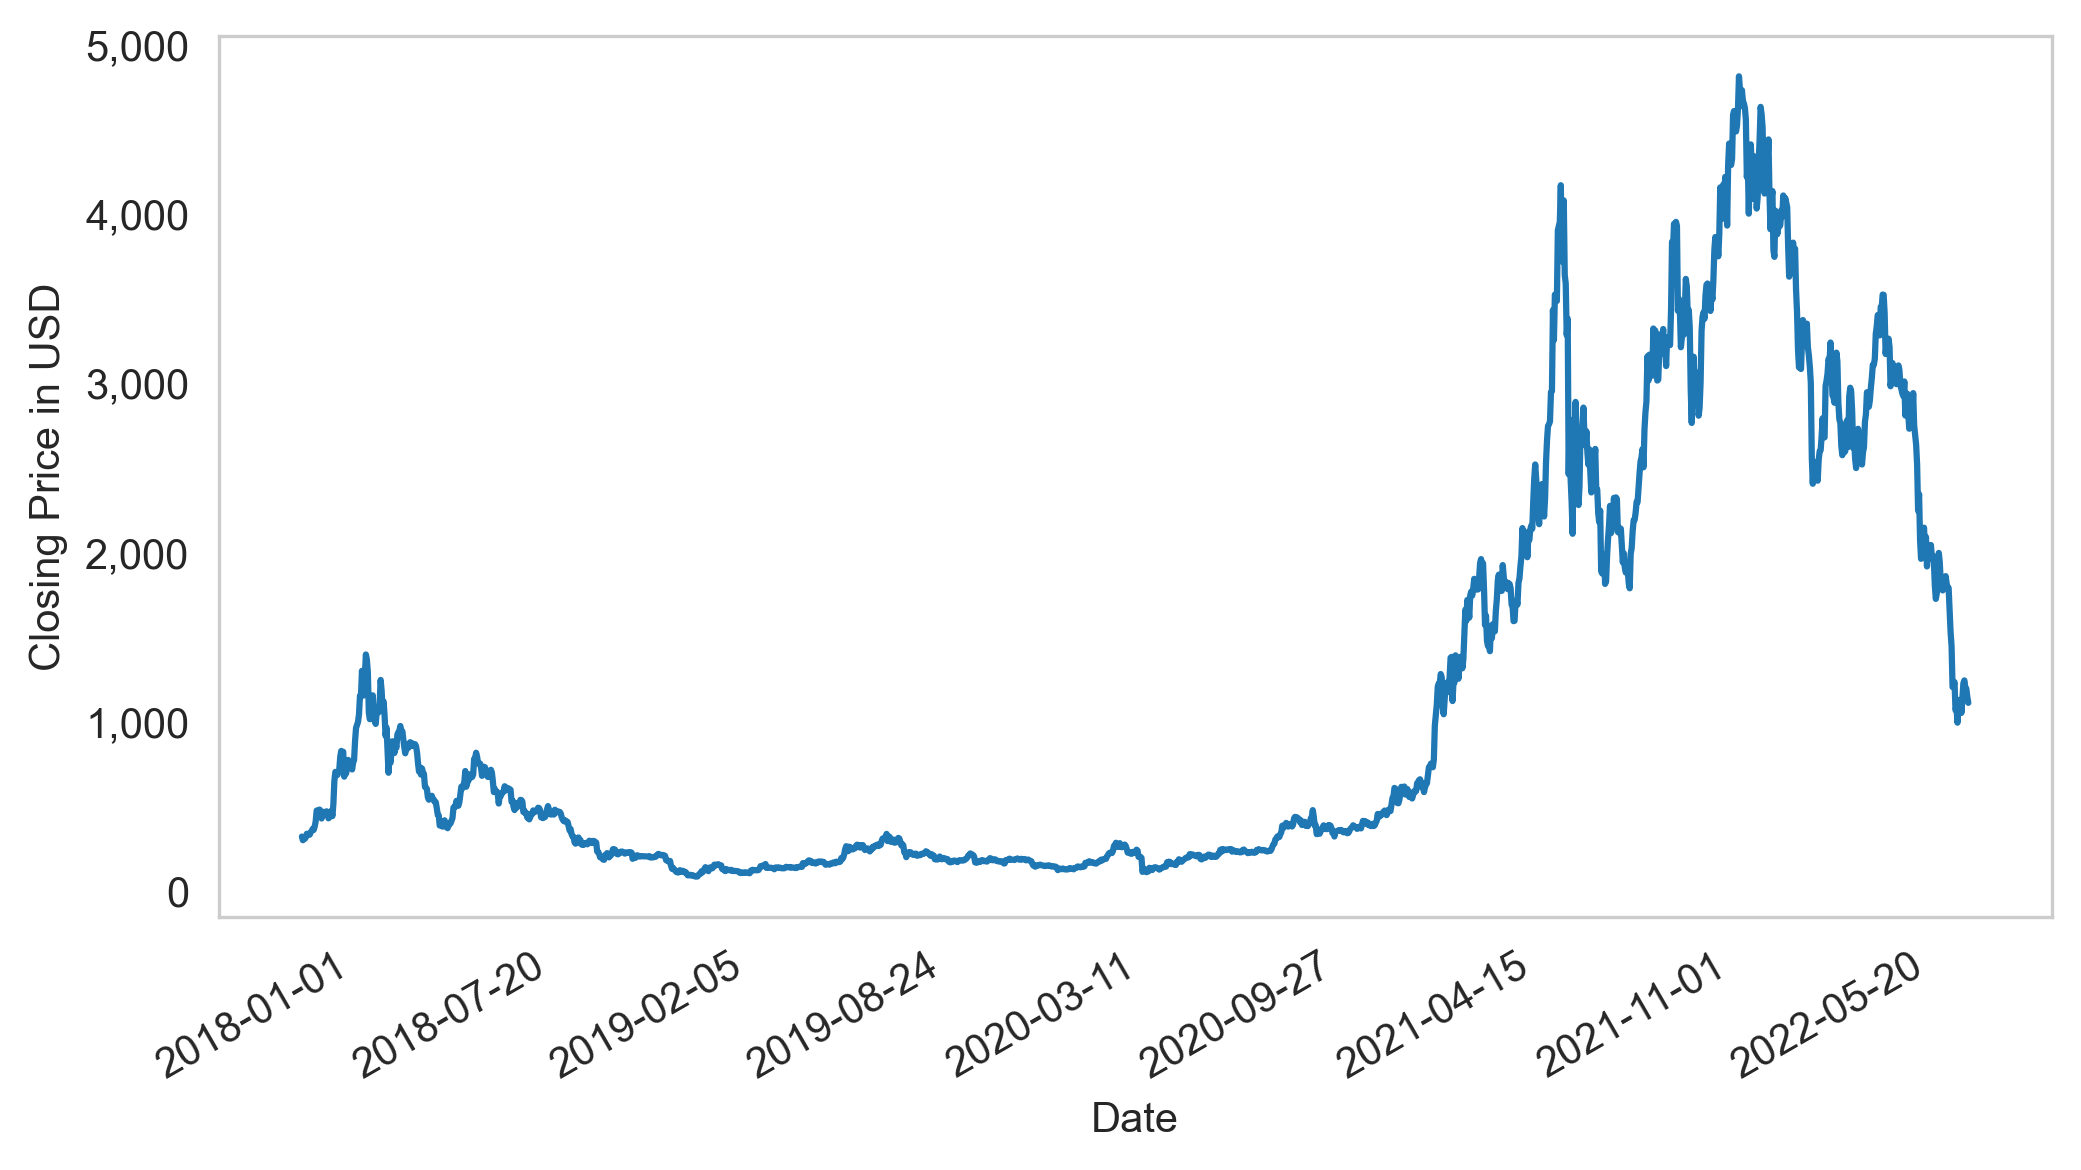

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1494 200
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


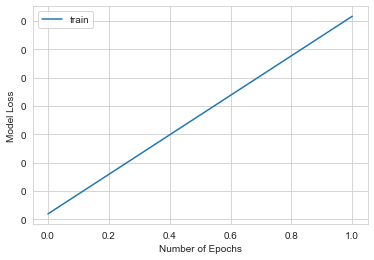

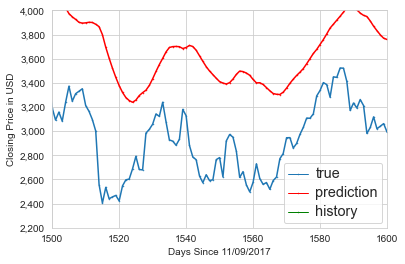

(190,)
(190, 1)
Root mean squared error and time ETH-USD: 805.4014549588196, 5.6874 s
LSTM run 12/200, 2, ETH-USD


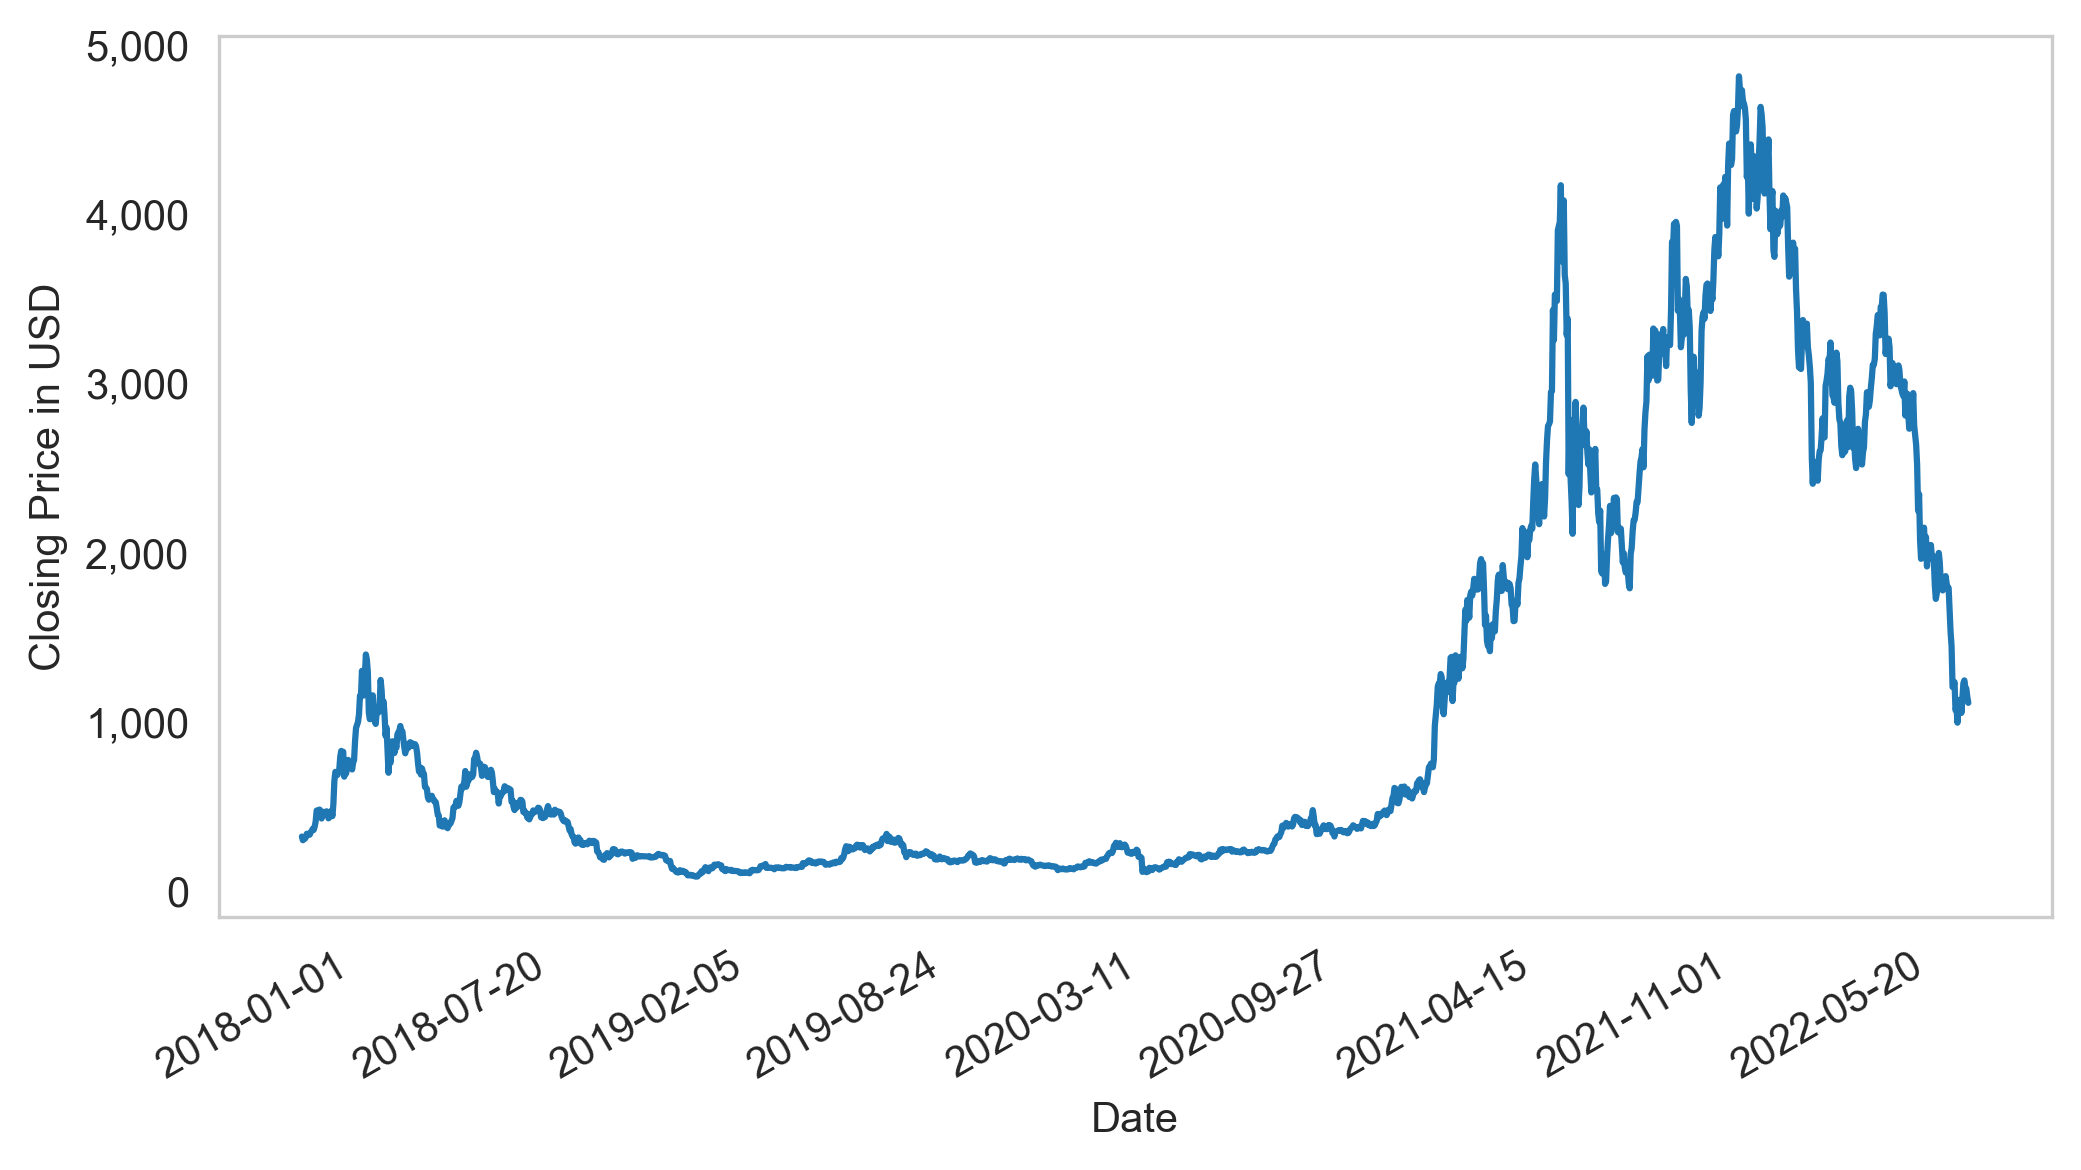

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1494 200
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


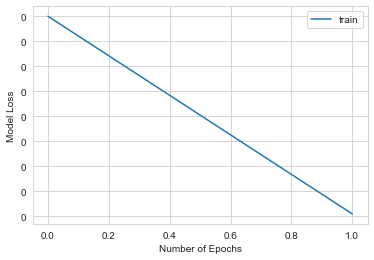

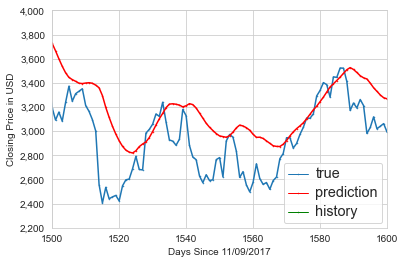

(190,)
(190, 1)
Root mean squared error and time ETH-USD: 415.4447565960903, 4.9713 s
LSTM run 13/200, 2, ETH-USD


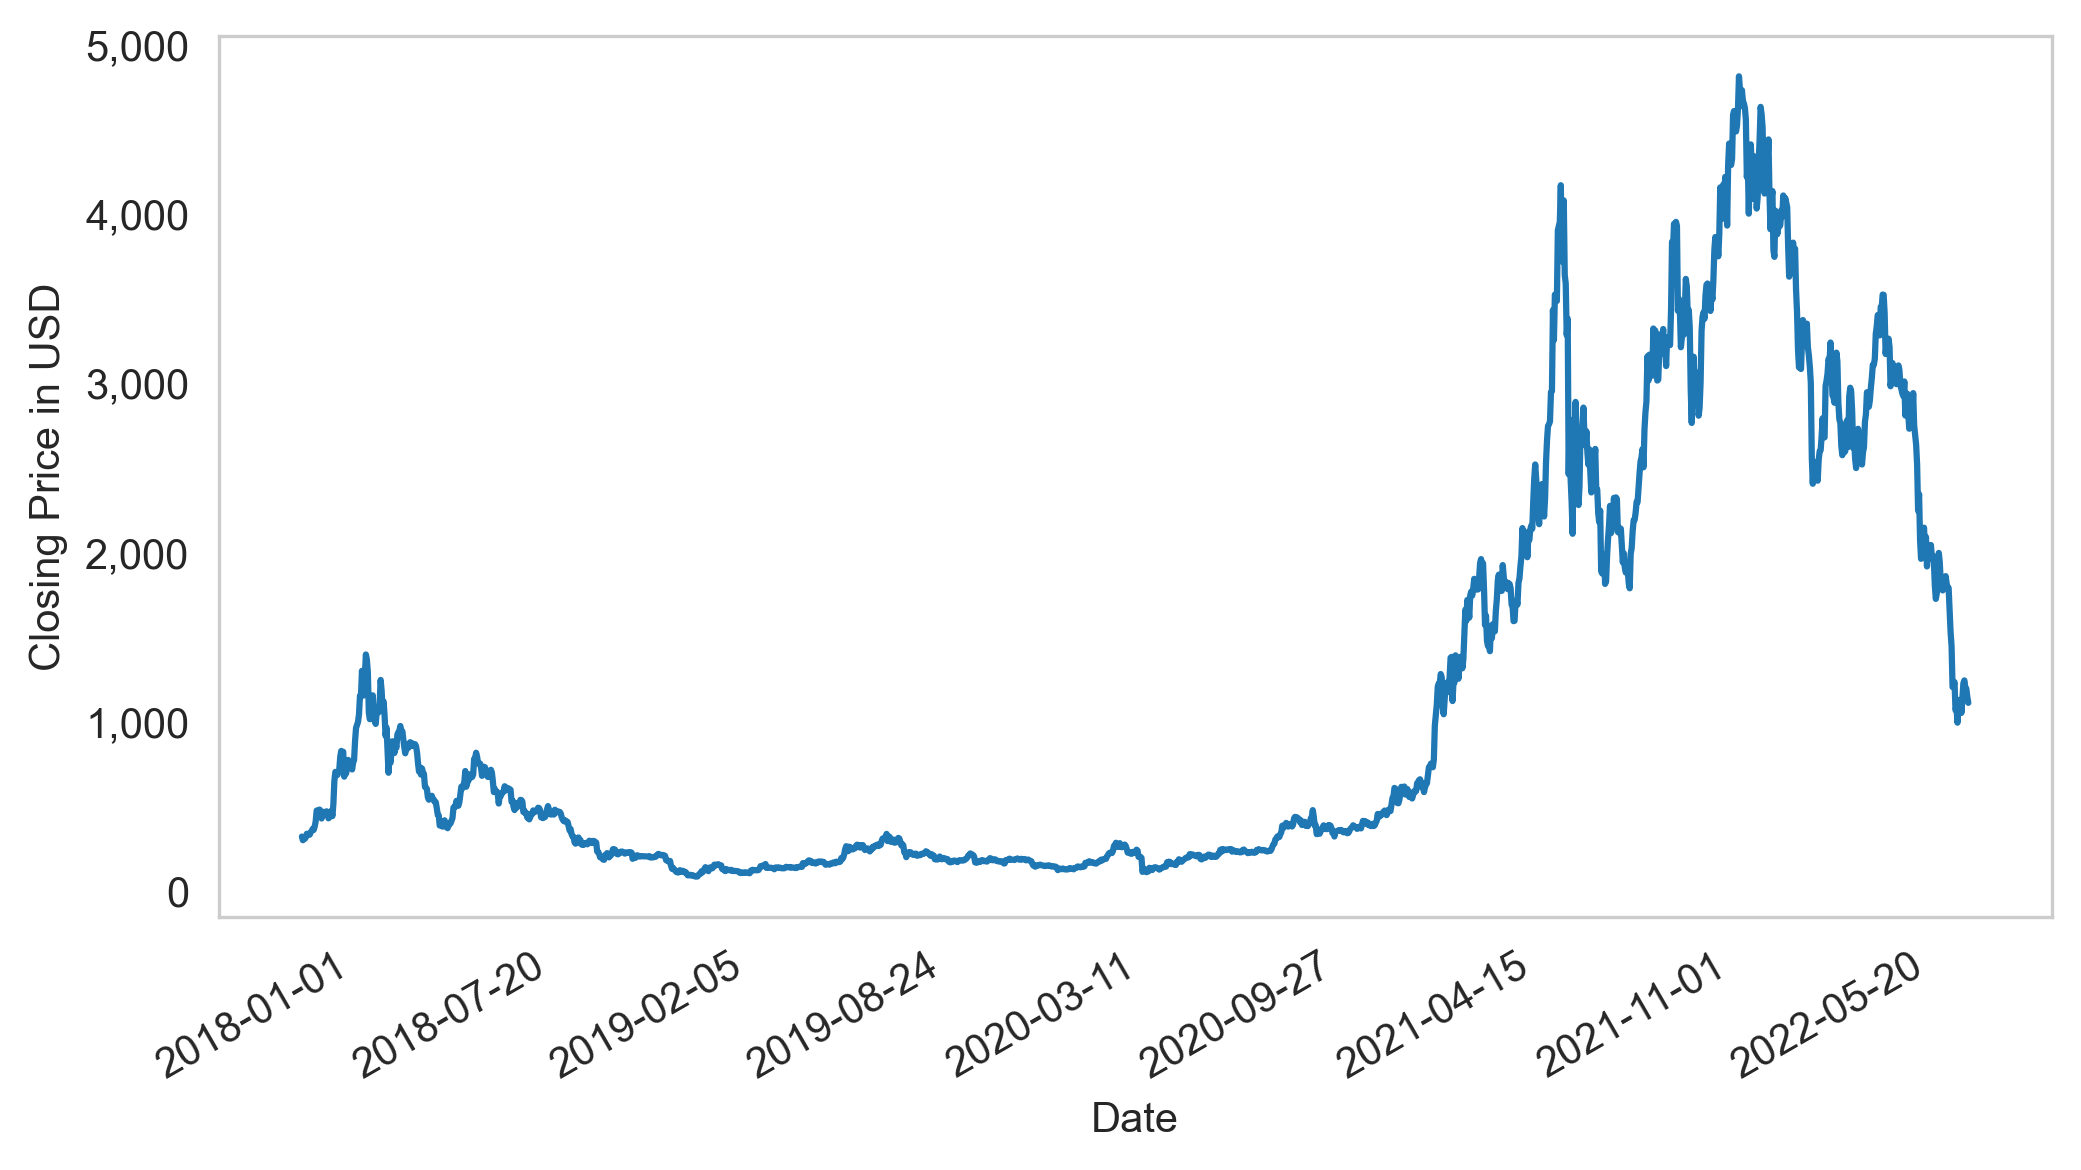

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1494 200
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


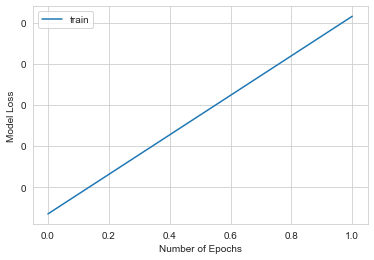

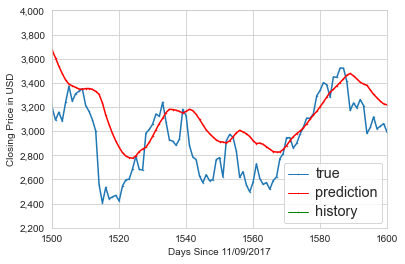

(190,)
(190, 1)
Root mean squared error and time ETH-USD: 376.37008462408824, 4.8728 s
LSTM run 14/200, 2, ETH-USD


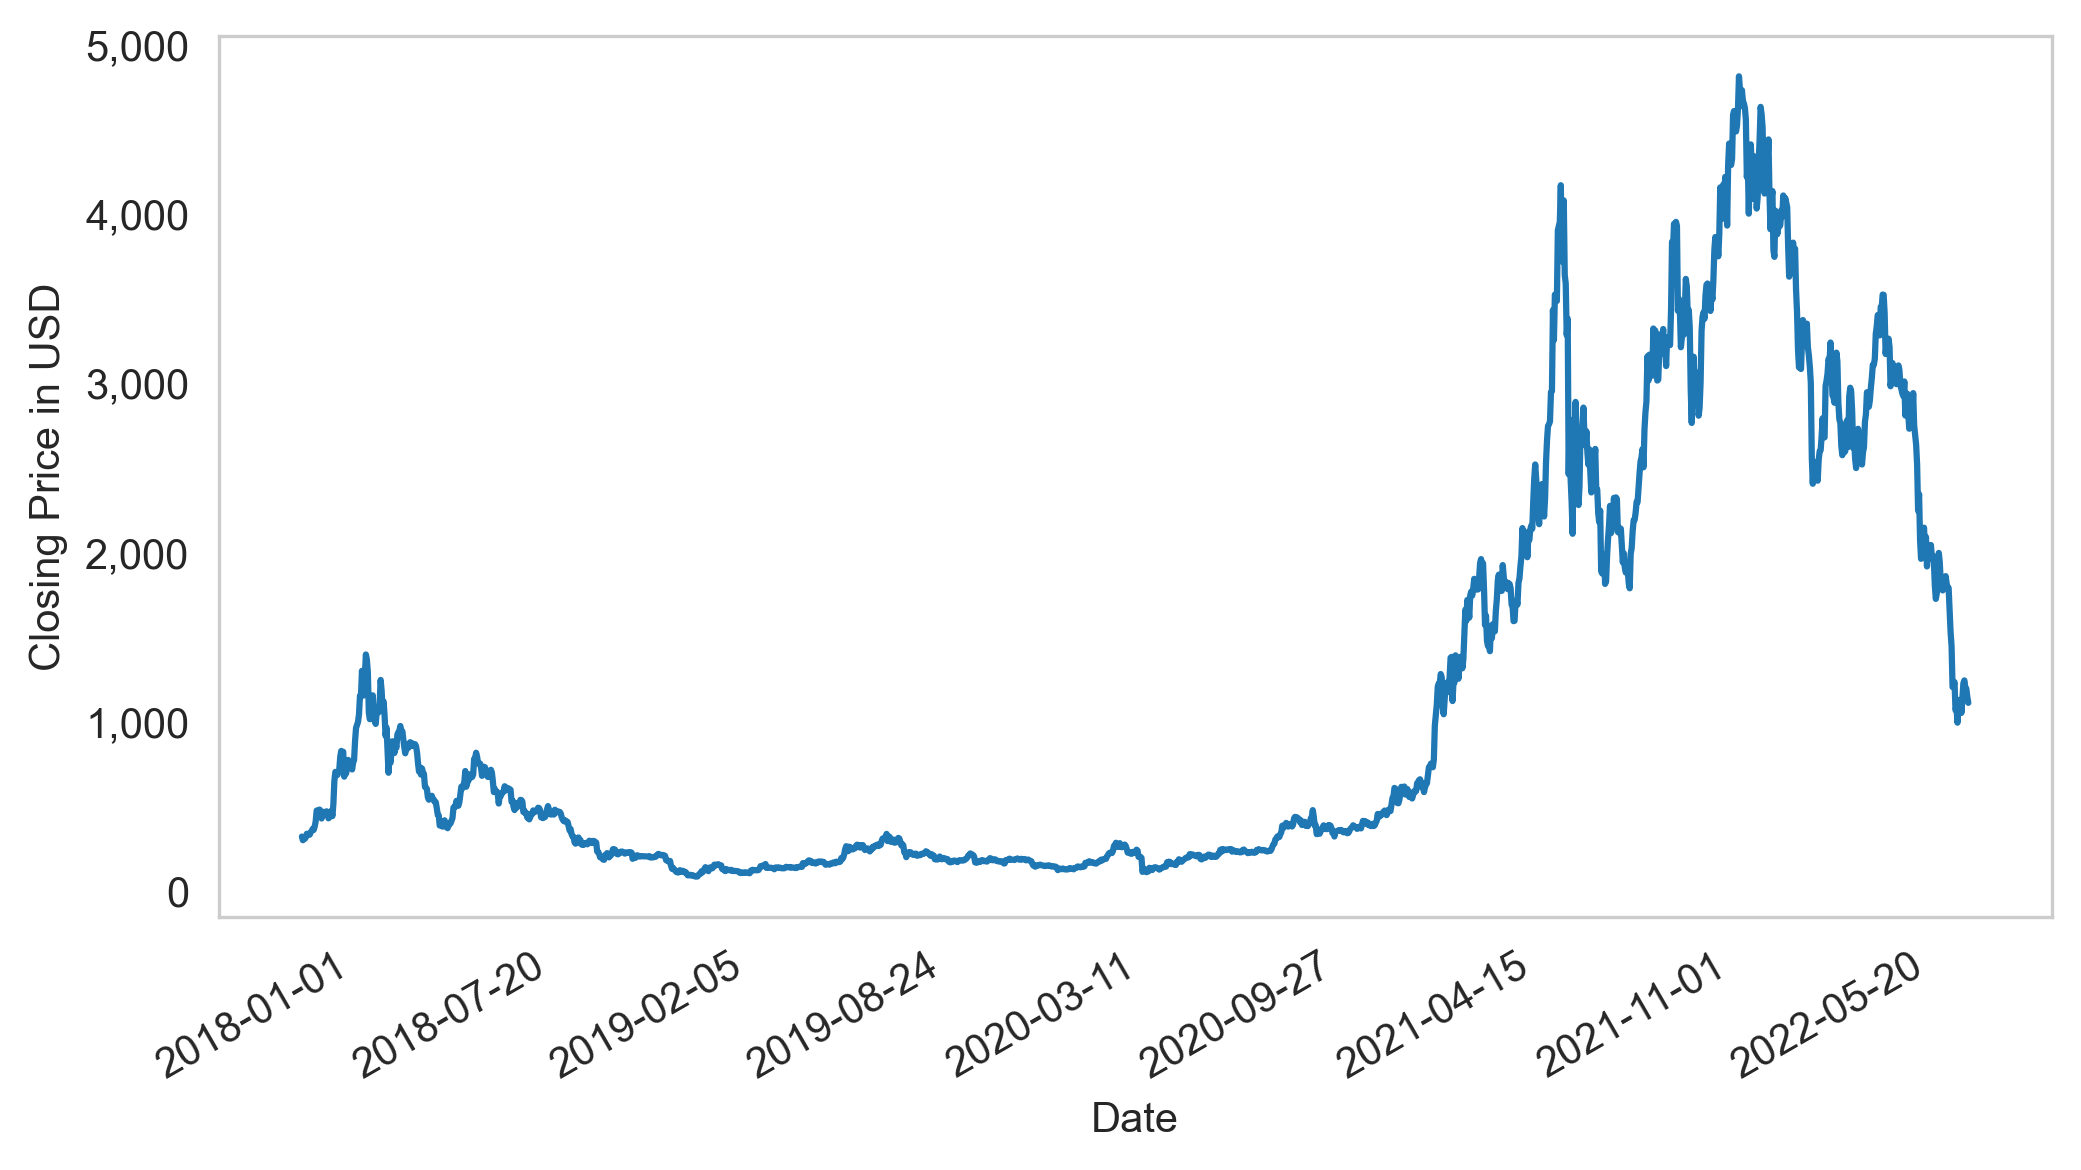

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1494 200
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


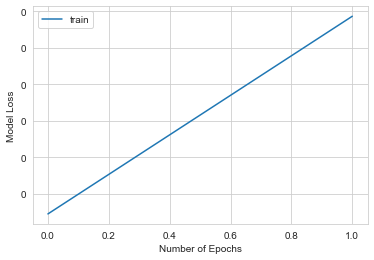

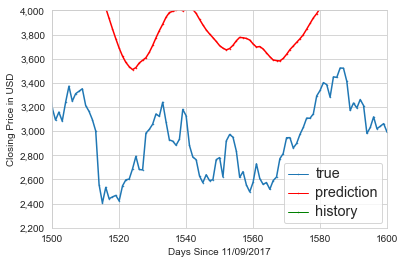

(190,)
(190, 1)
Root mean squared error and time ETH-USD: 1086.1407109835313, 5.0699 s
LSTM run 15/200, 2, ETH-USD


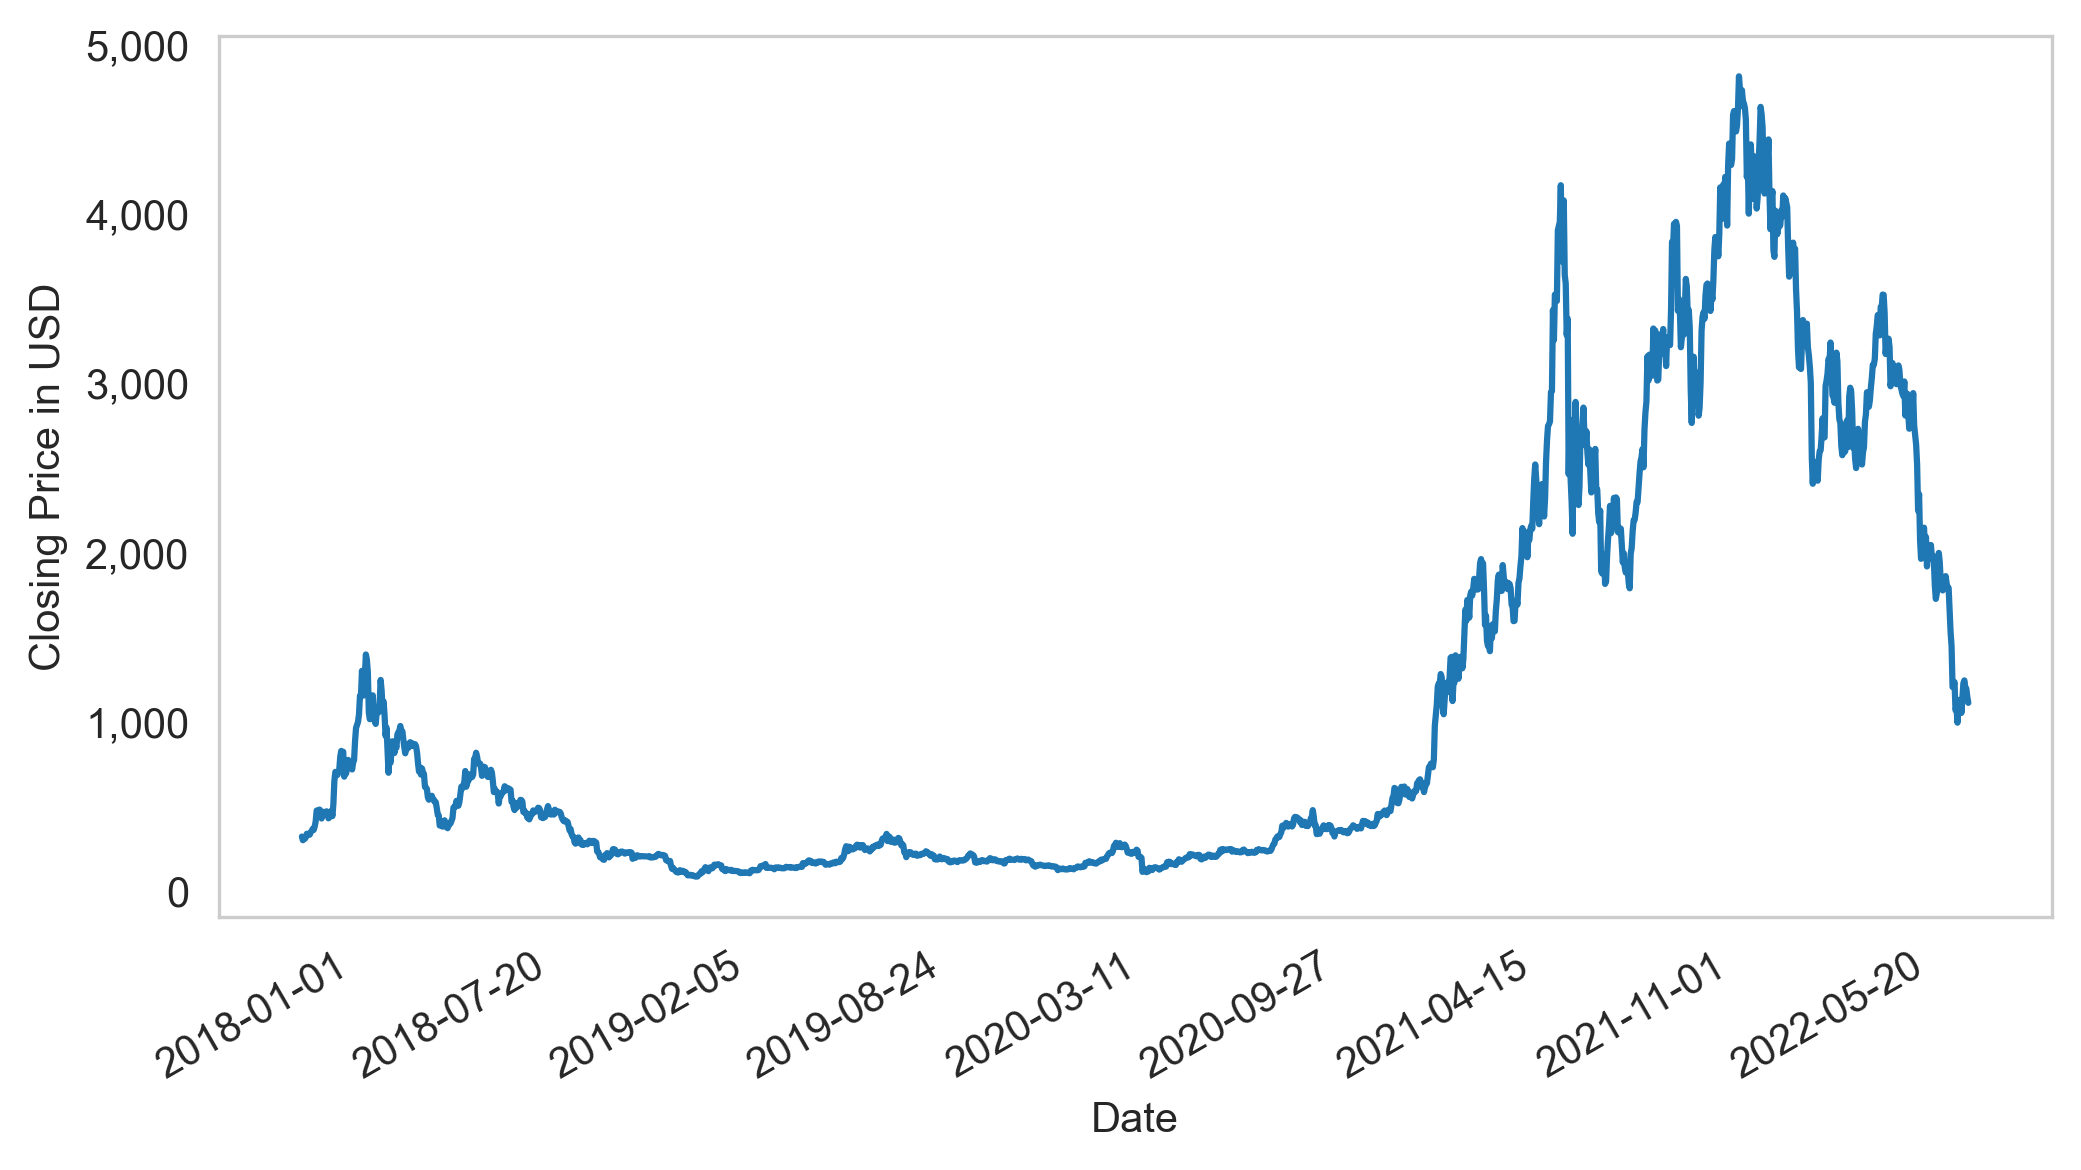

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1494 200
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


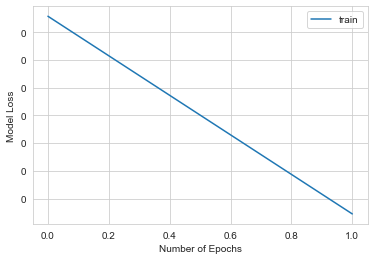

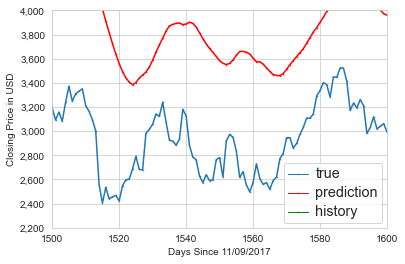

(190,)
(190, 1)
Root mean squared error and time ETH-USD: 969.2191626710012, 4.7776 s
LSTM run 16/200, 2, DOGE-USD


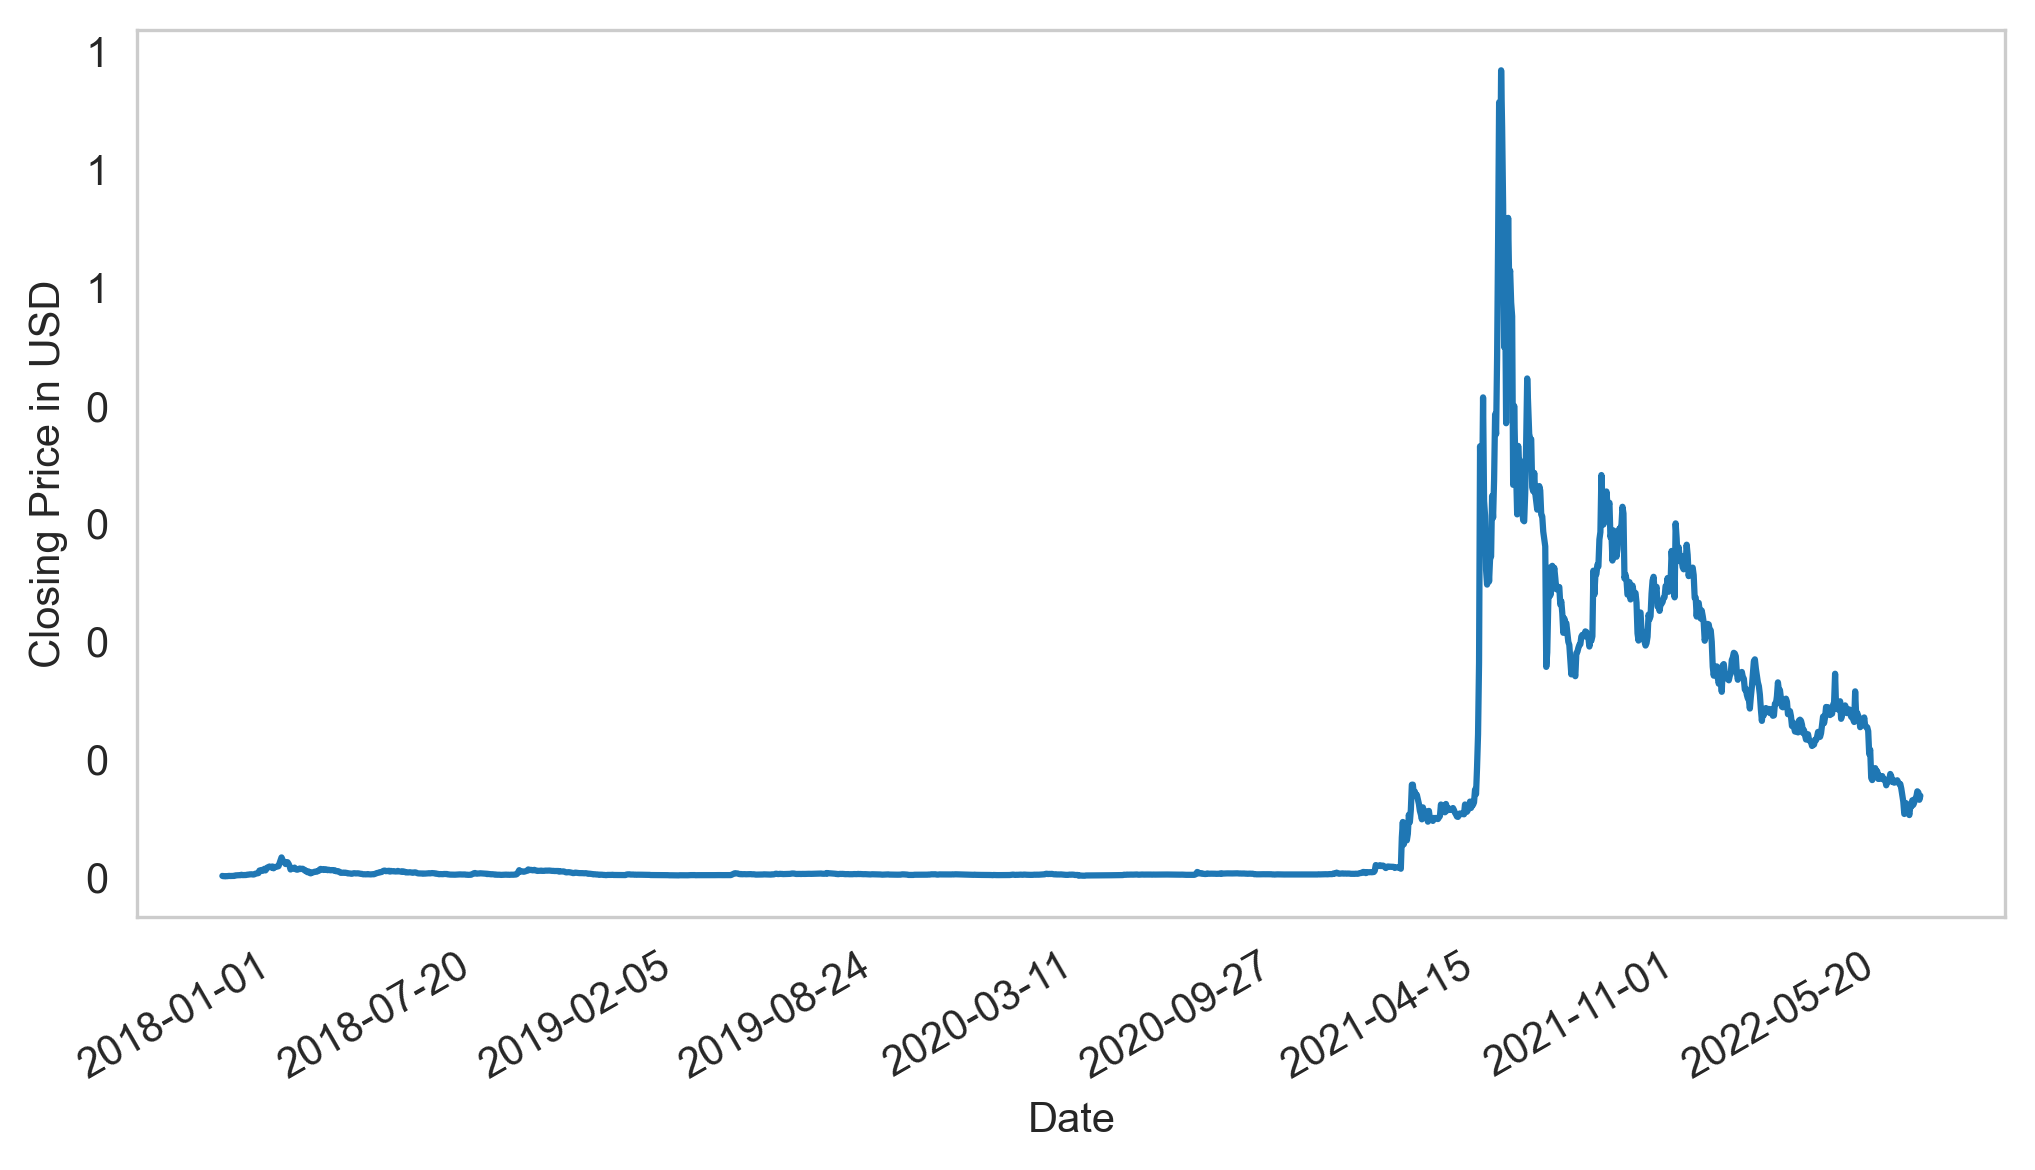

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                Open      High       Low     Close   Volume  Dividends  \
Date                                                                     
2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550          0   
2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520          0   
2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080          0   
2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960          0   
2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 250)               252000    
           

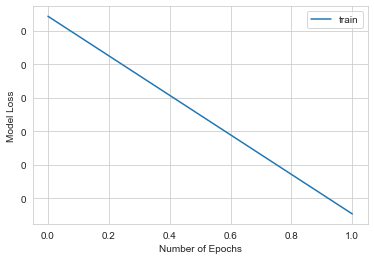

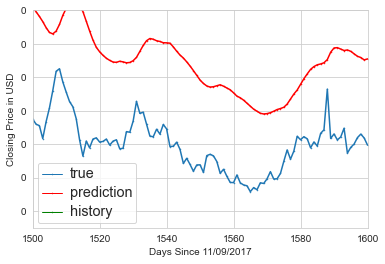

(190,)
(190, 1)
Root mean squared error and time DOGE-USD: 0.0497234086312895, 5.074 s
LSTM run 17/200, 2, DOGE-USD


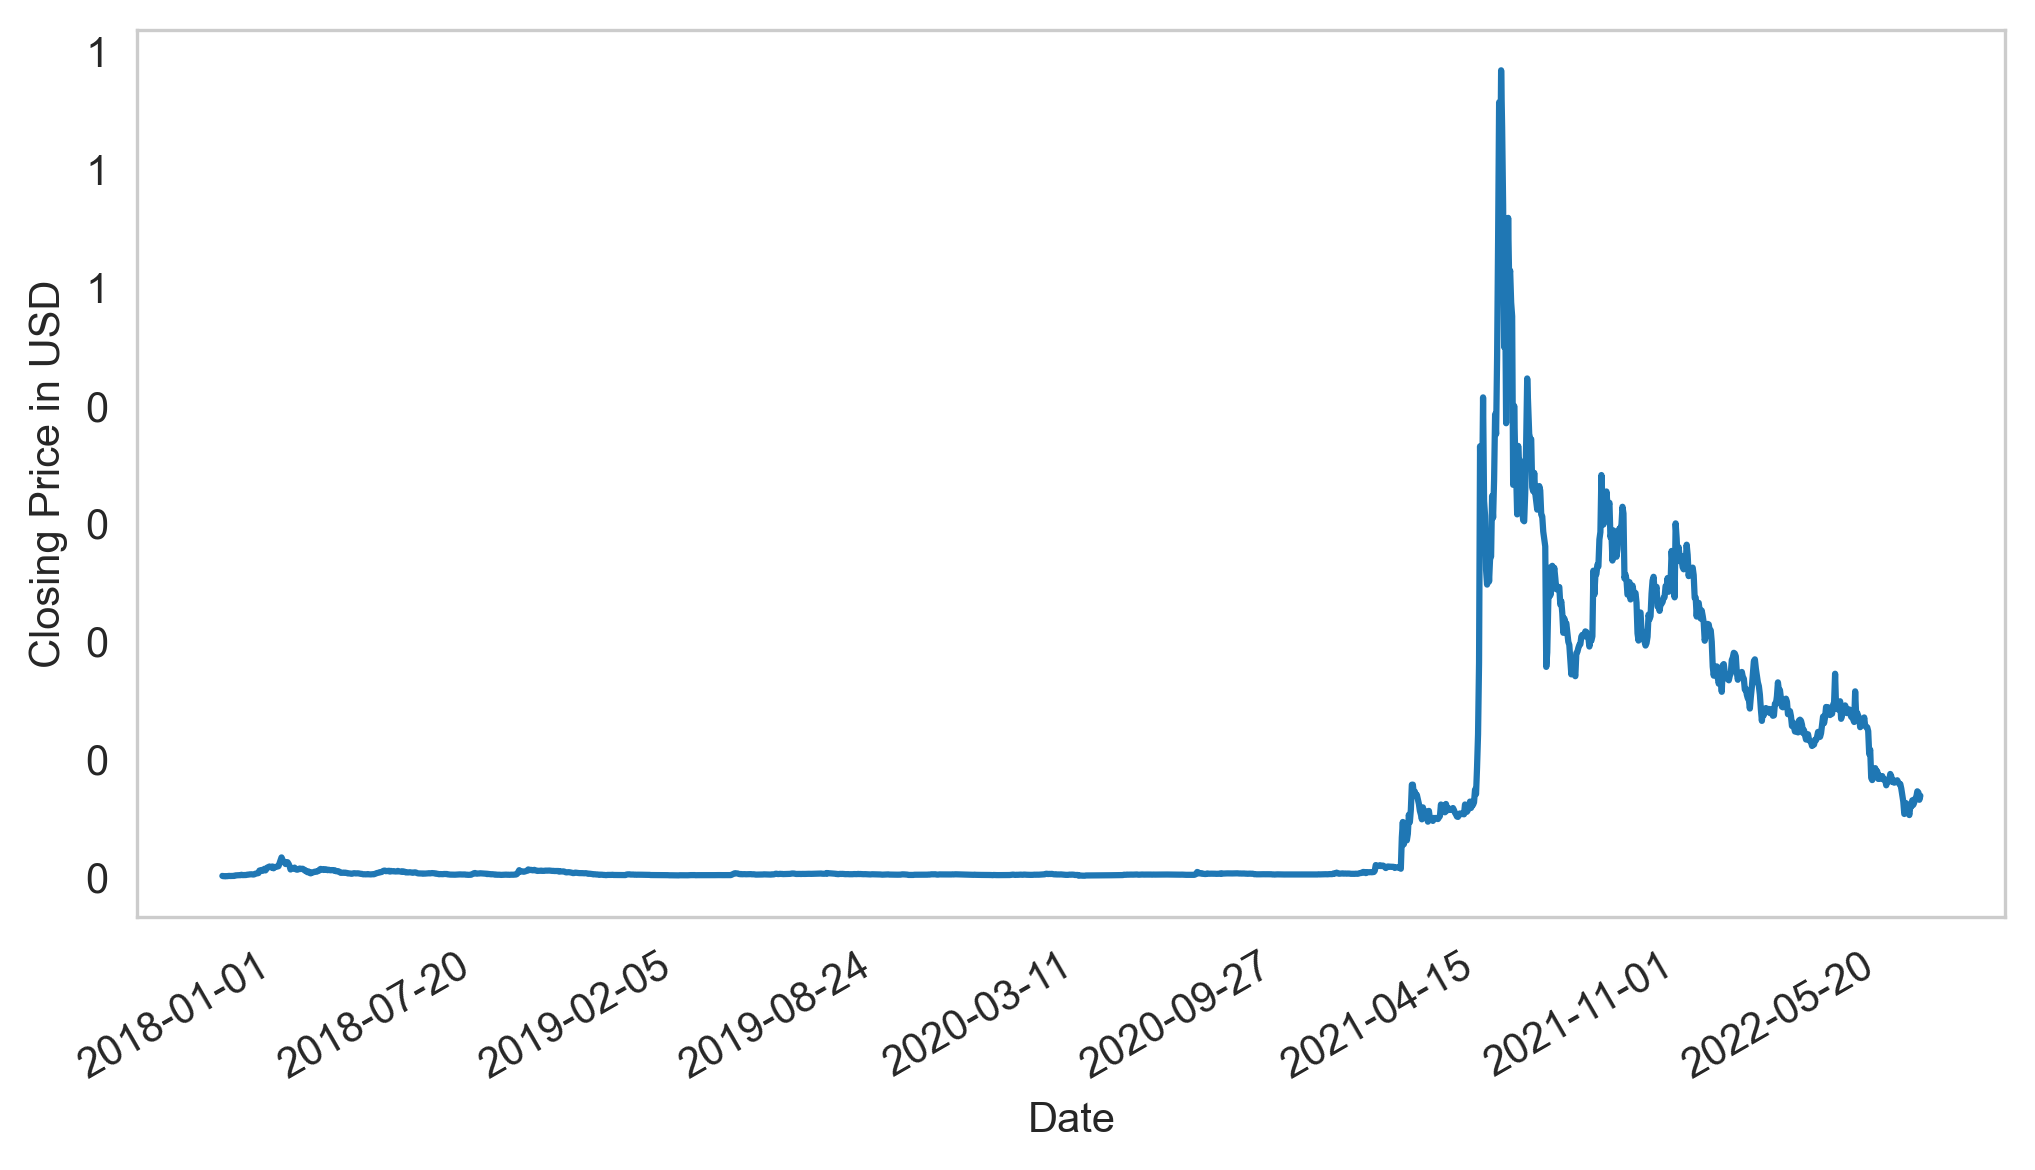

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                Open      High       Low     Close   Volume  Dividends  \
Date                                                                     
2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550          0   
2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520          0   
2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080          0   
2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960          0   
2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 250)               252000    
           

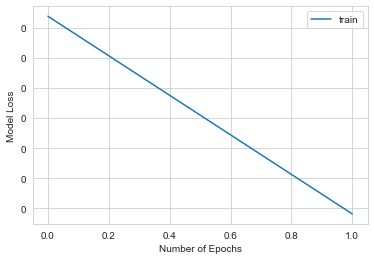

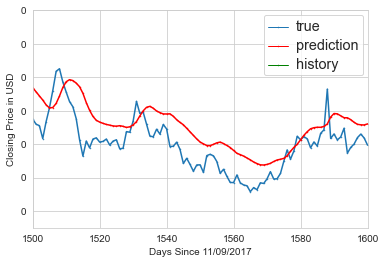

(190,)
(190, 1)
Root mean squared error and time DOGE-USD: 0.017025686333443407, 4.7789 s
LSTM run 18/200, 2, DOGE-USD


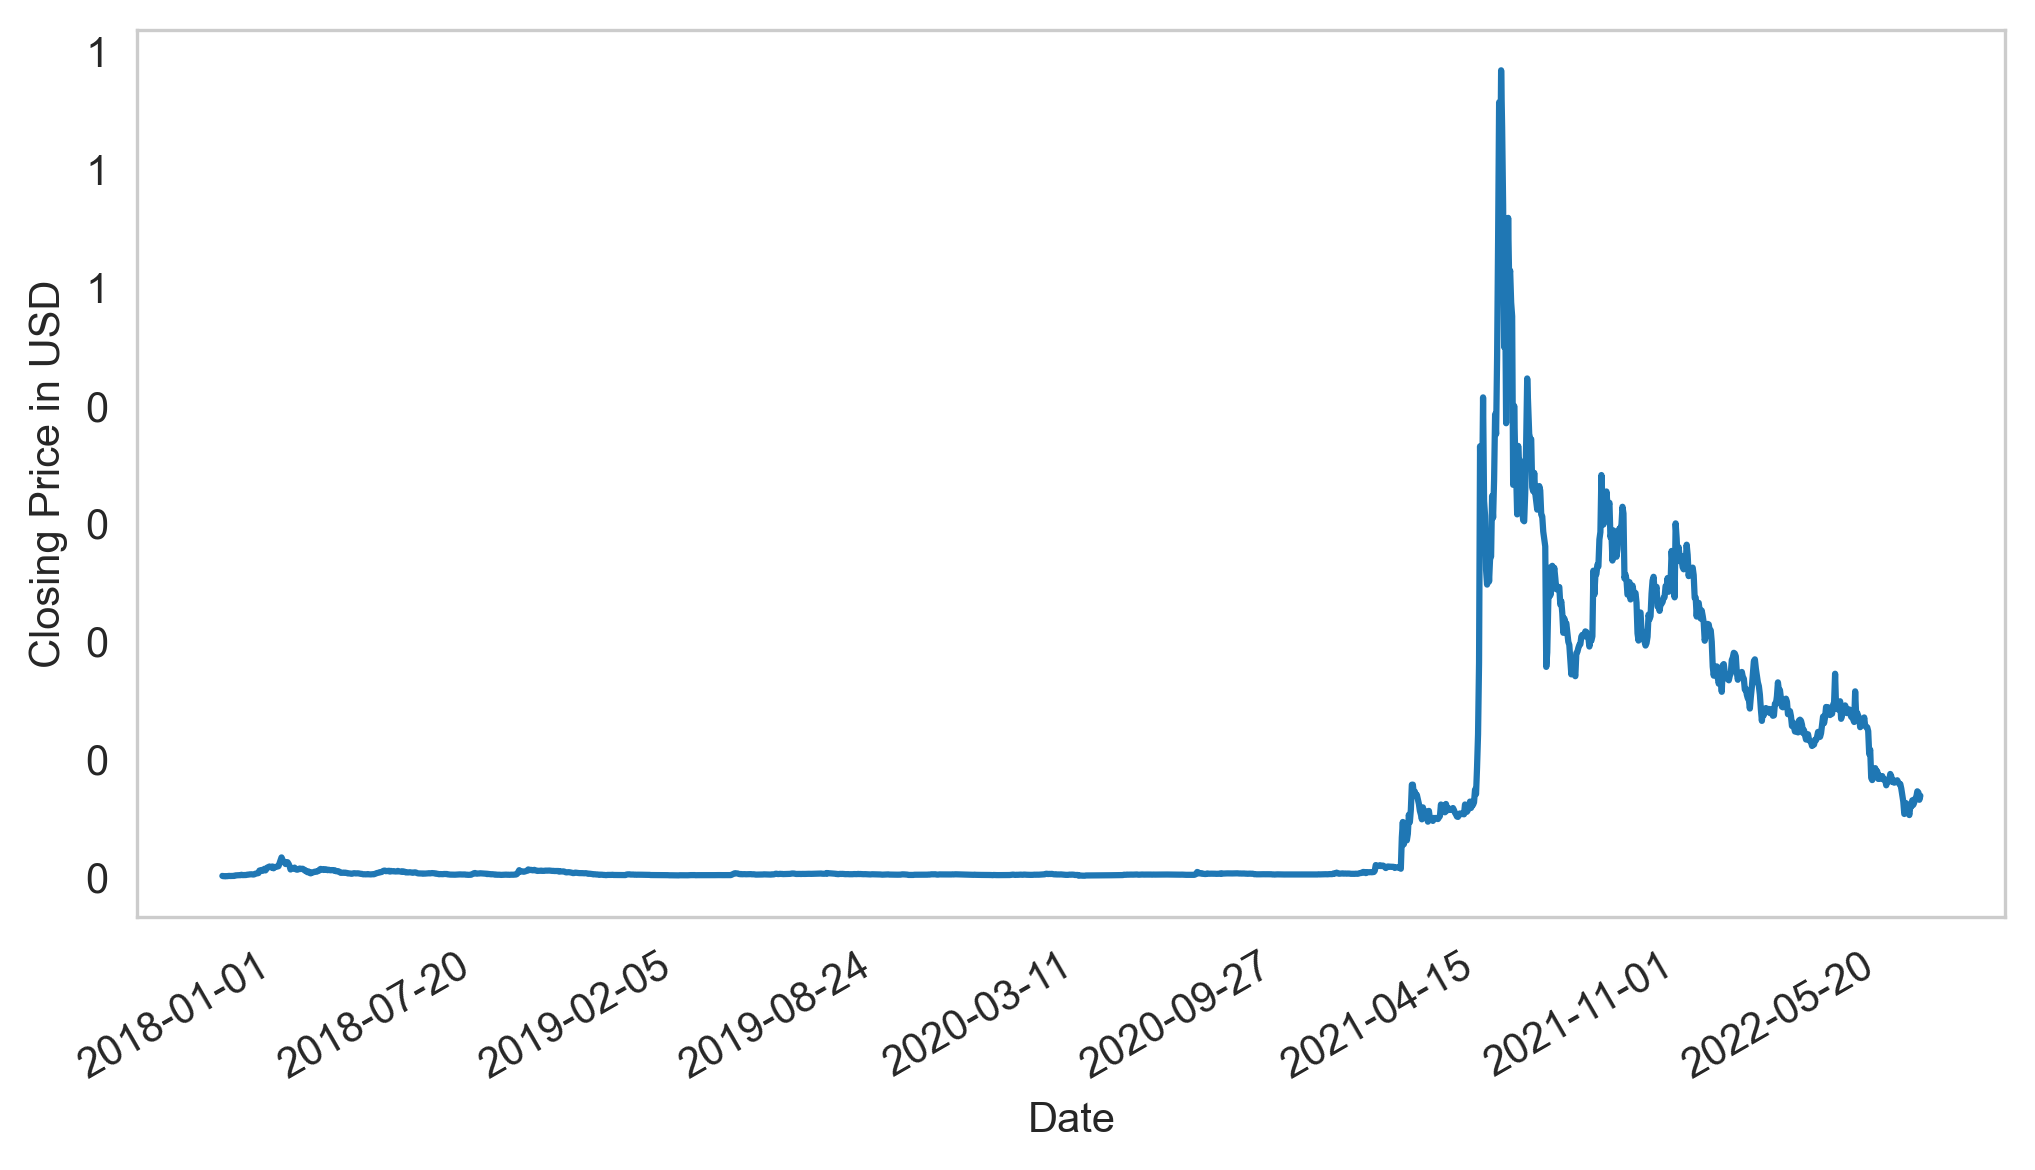

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                Open      High       Low     Close   Volume  Dividends  \
Date                                                                     
2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550          0   
2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520          0   
2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080          0   
2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960          0   
2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 250)               252000    
           

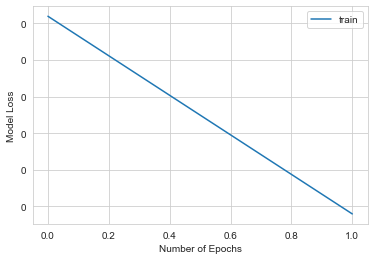

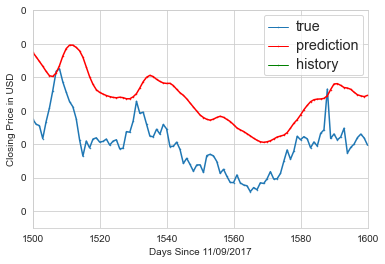

(190,)
(190, 1)
Root mean squared error and time DOGE-USD: 0.030637412461626875, 4.9289 s
LSTM run 19/200, 2, DOGE-USD


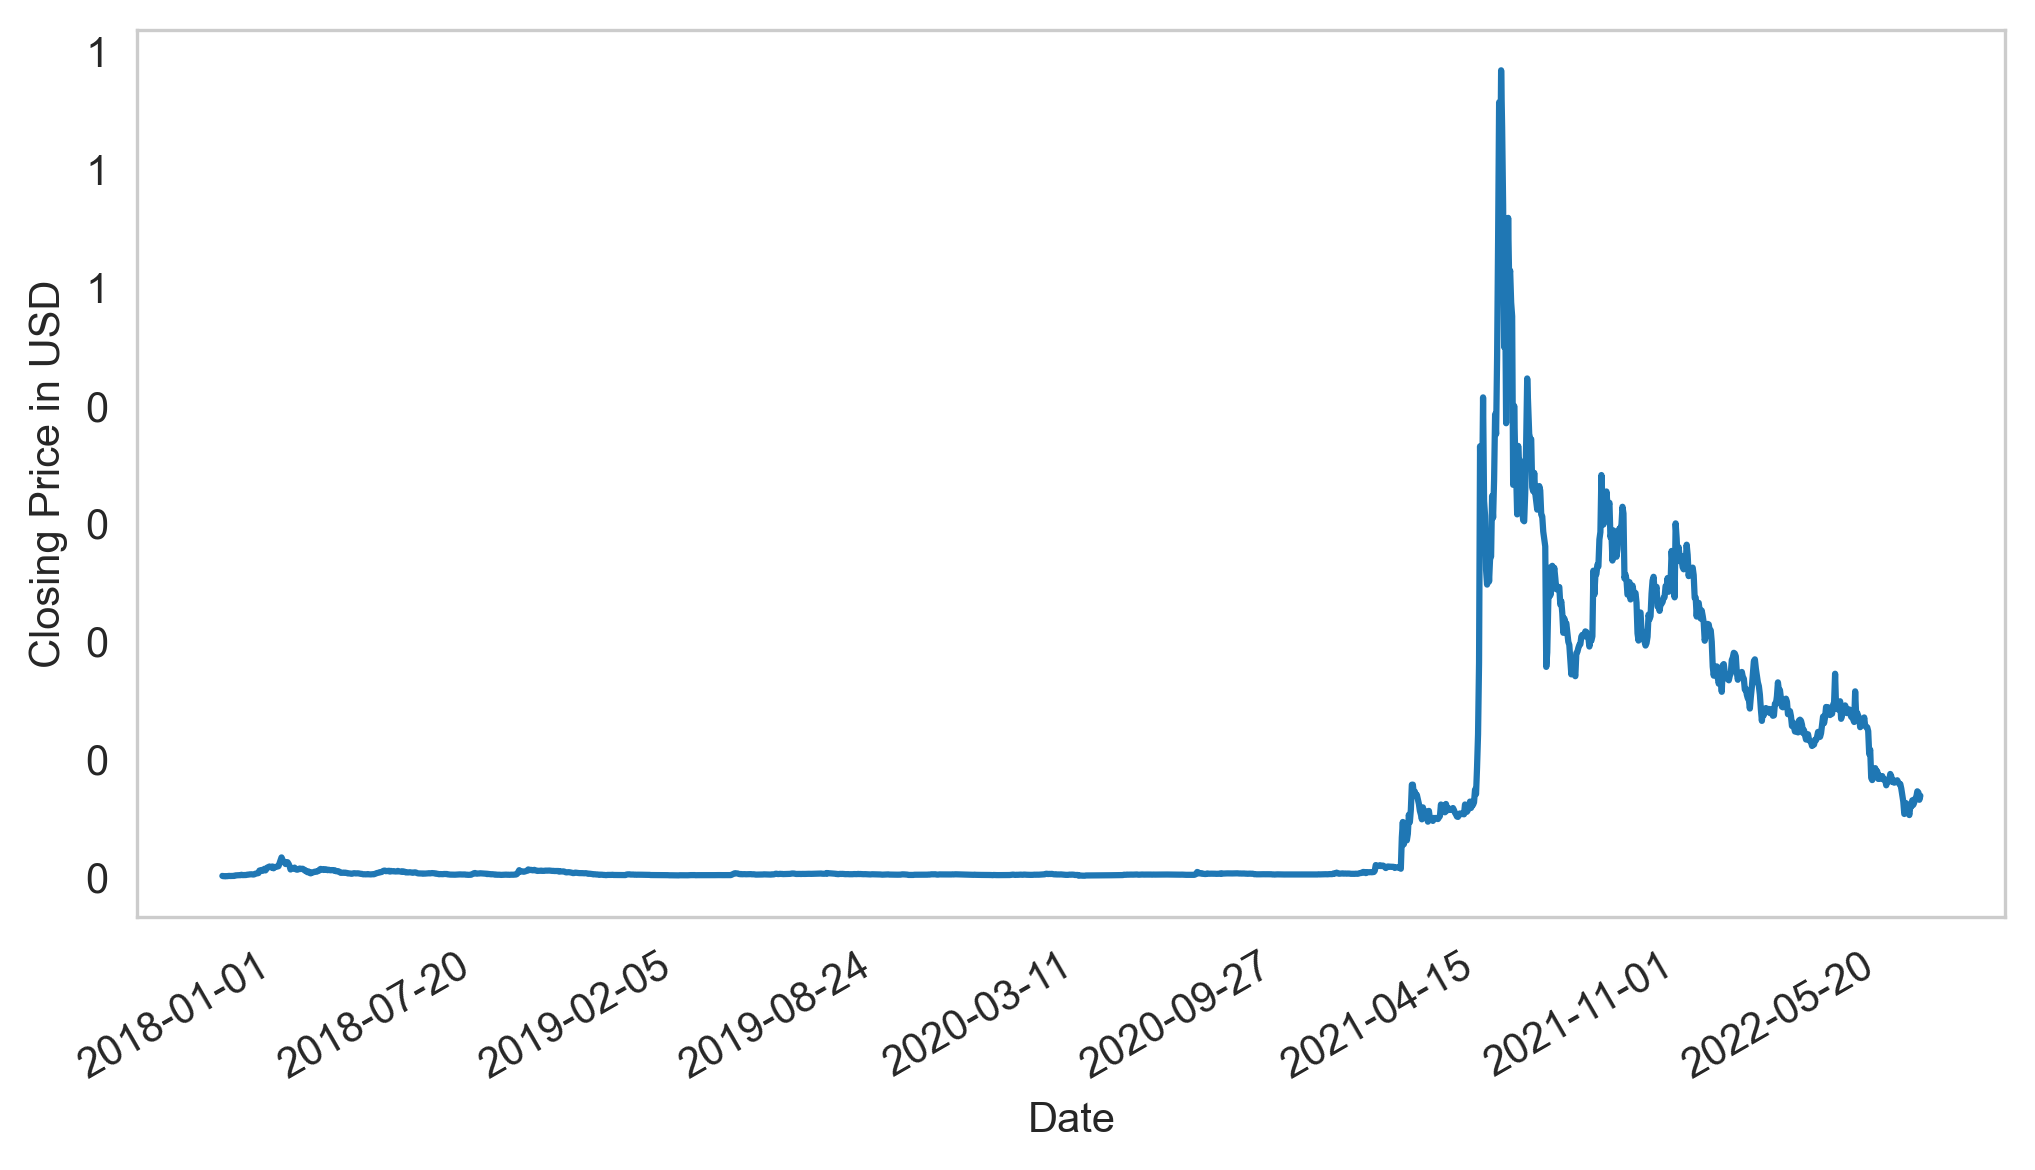

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                Open      High       Low     Close   Volume  Dividends  \
Date                                                                     
2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550          0   
2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520          0   
2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080          0   
2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960          0   
2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 250)               252000    
           

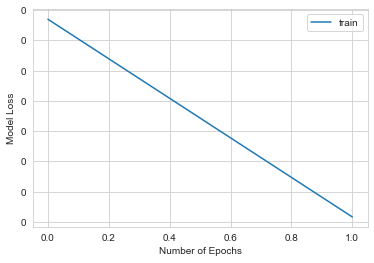

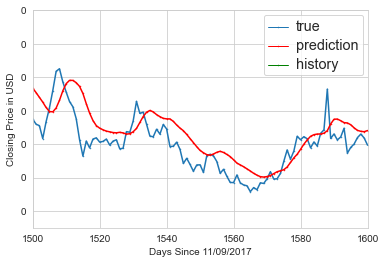

(190,)
(190, 1)
Root mean squared error and time DOGE-USD: 0.012595030198618979, 5.0483 s
LSTM run 20/200, 2, DOGE-USD


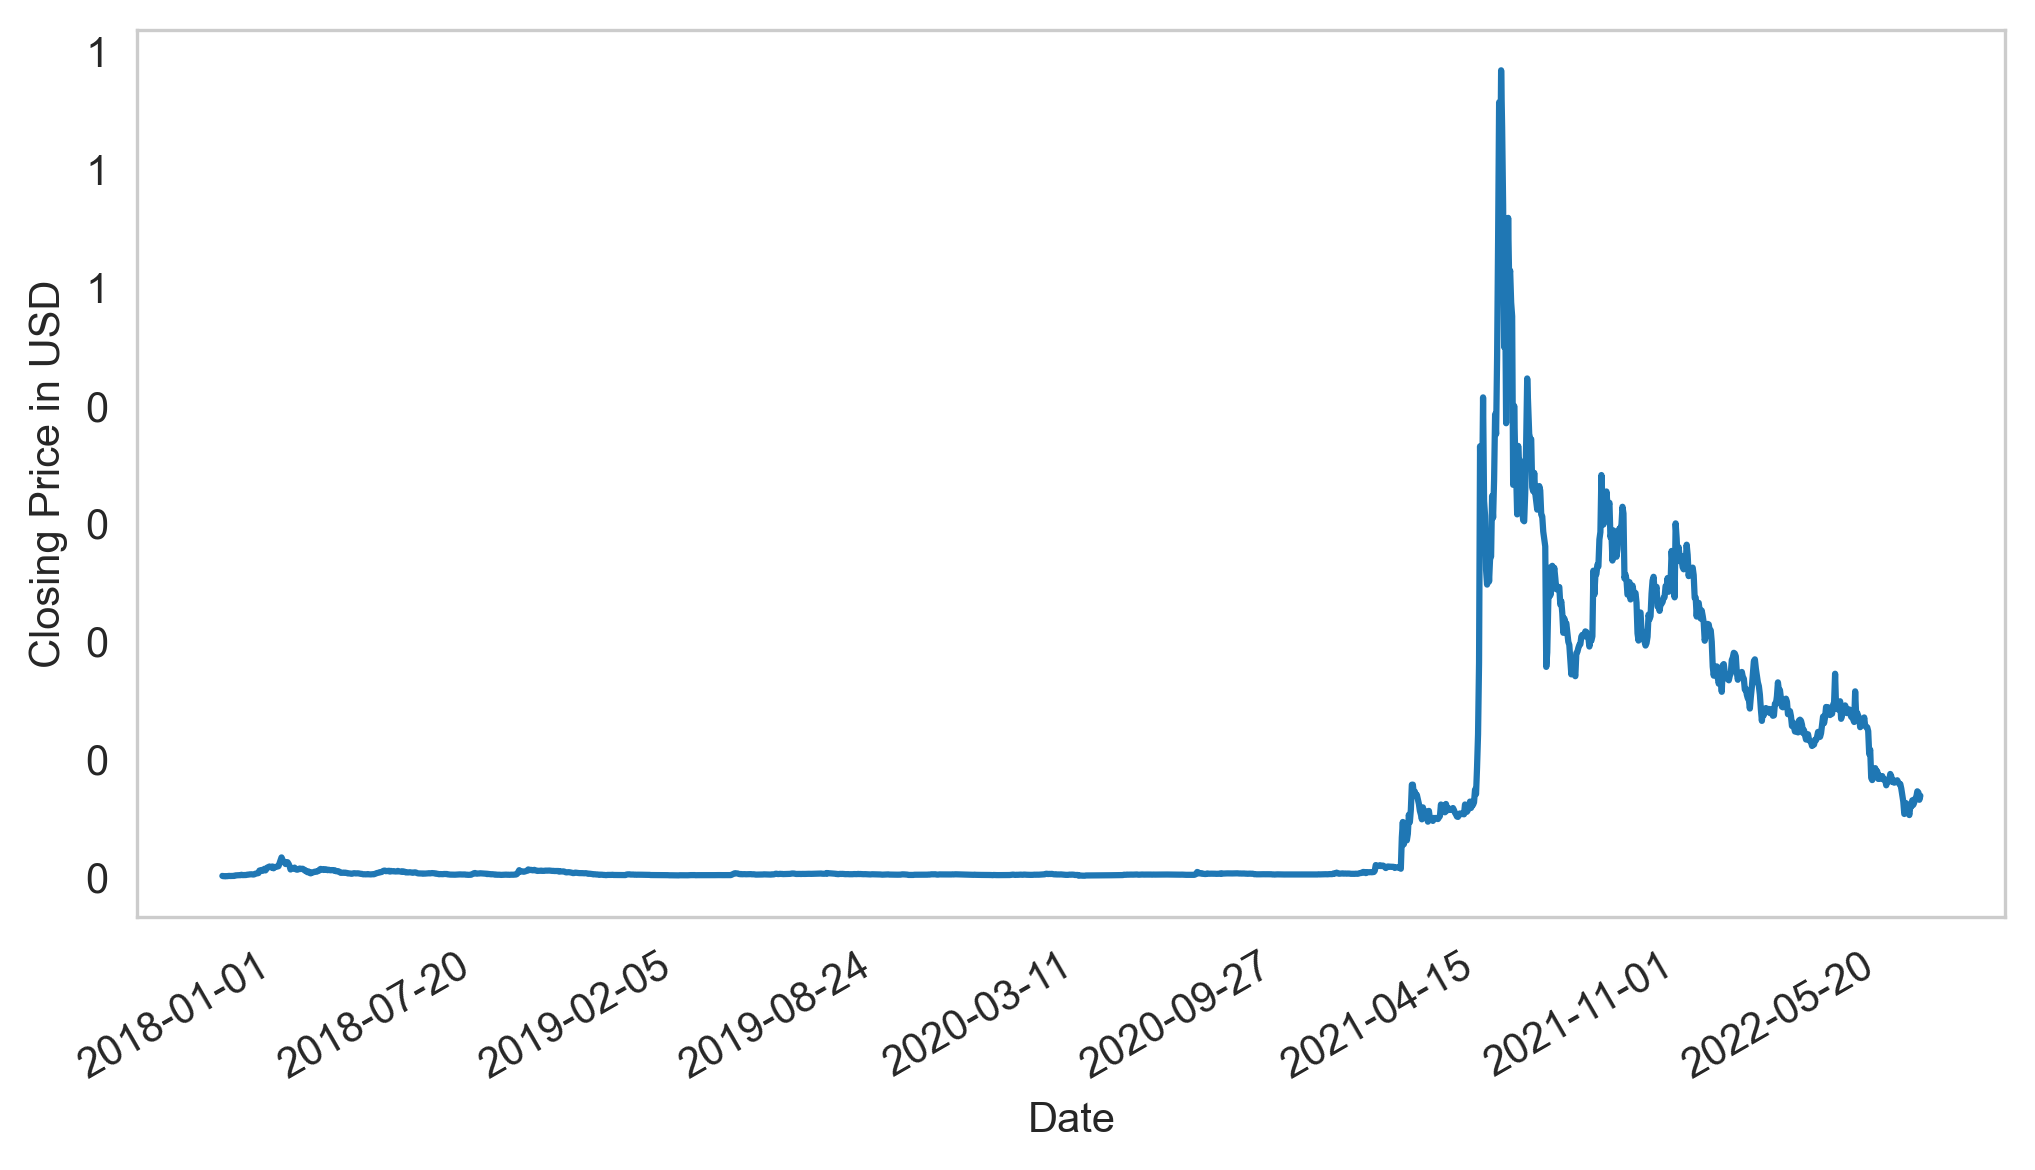

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                Open      High       Low     Close   Volume  Dividends  \
Date                                                                     
2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550          0   
2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520          0   
2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080          0   
2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960          0   
2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 250)               252000    
           

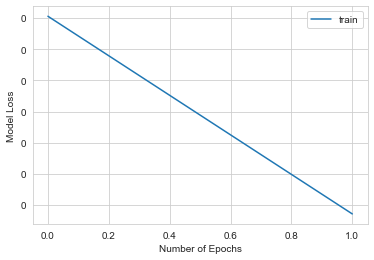

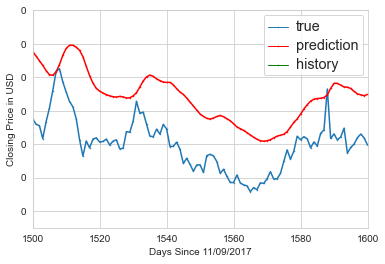

(190,)
(190, 1)
Root mean squared error and time DOGE-USD: 0.031149033130645157, 5.0266 s
LSTM run 21/200, 10, EOS-USD


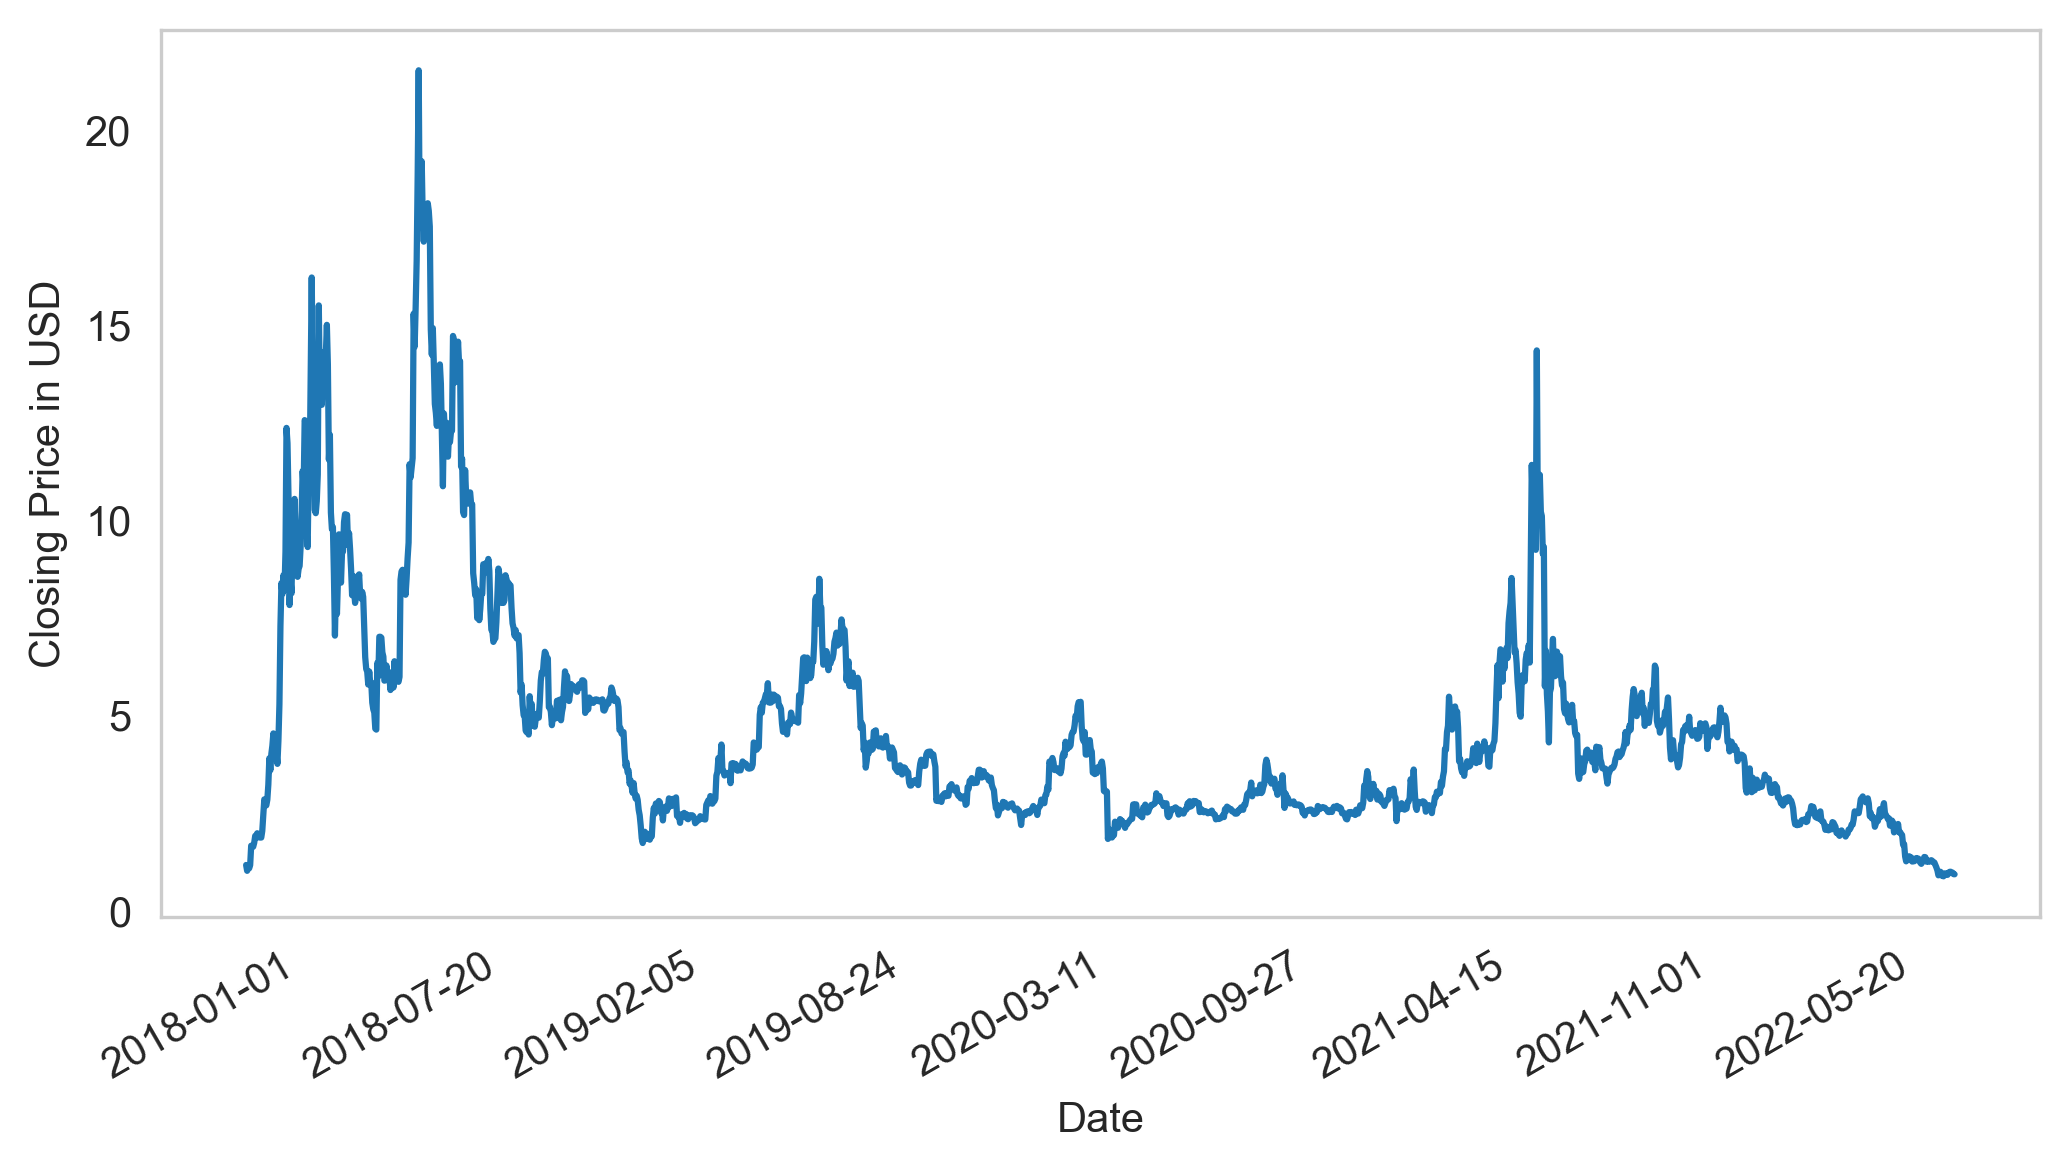

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 250)               252000    
                                

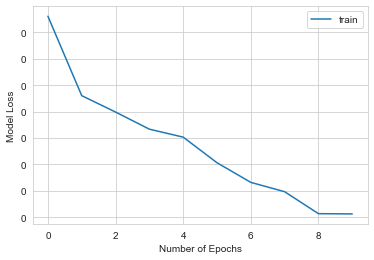

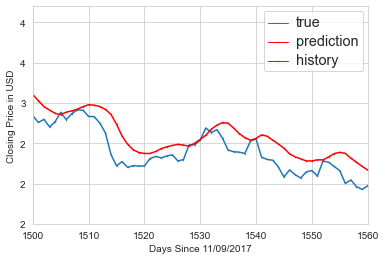

(190,)
(190, 1)
Root mean squared error and time EOS-USD: 0.24266018552460925, 11.1784 s
LSTM run 22/200, 10, EOS-USD


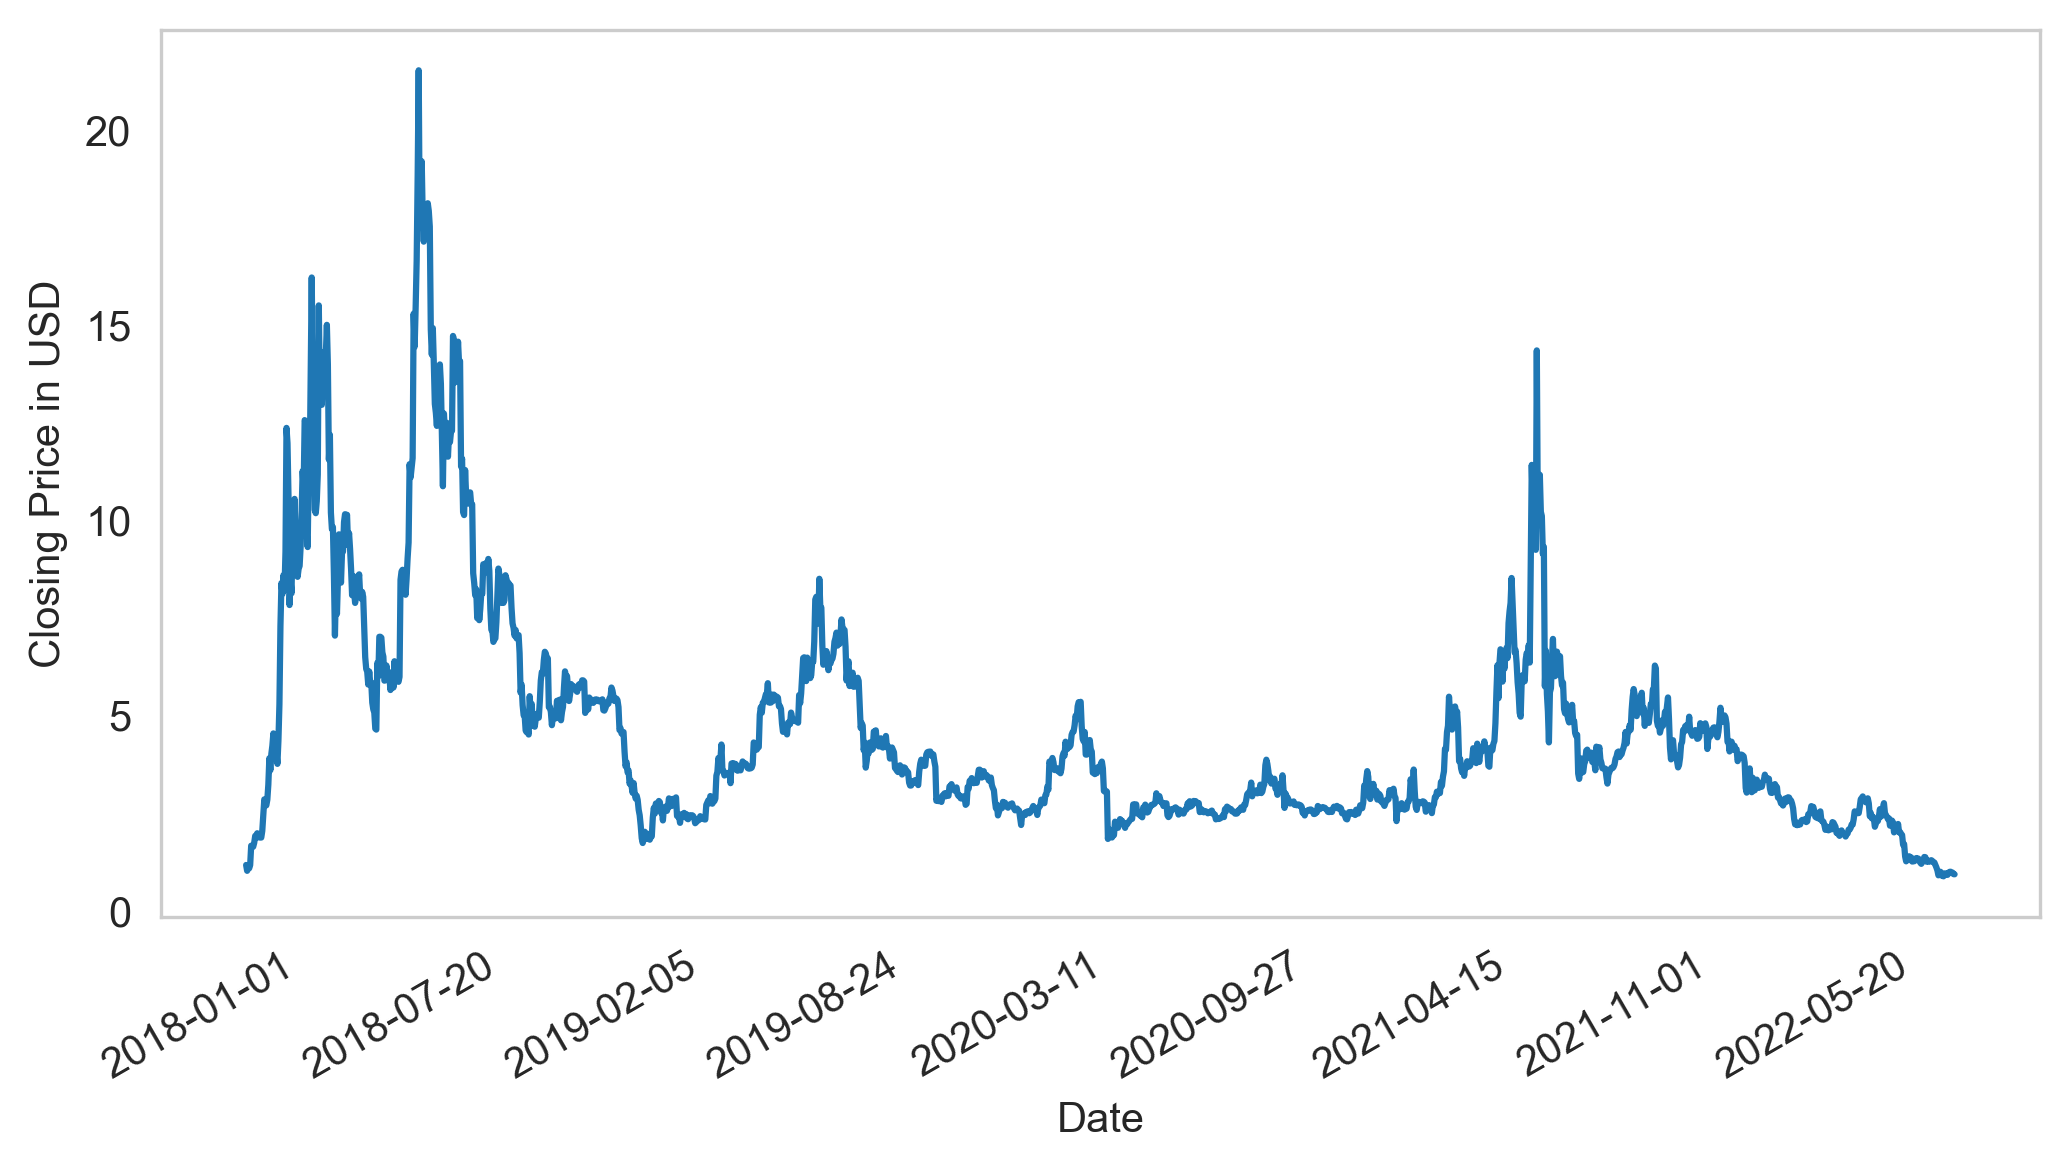

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 250)               252000    
                                

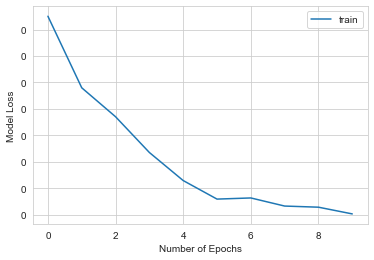

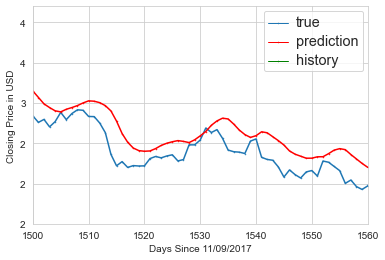

(190,)
(190, 1)
Root mean squared error and time EOS-USD: 0.27402416683385467, 10.5652 s
LSTM run 23/200, 10, EOS-USD


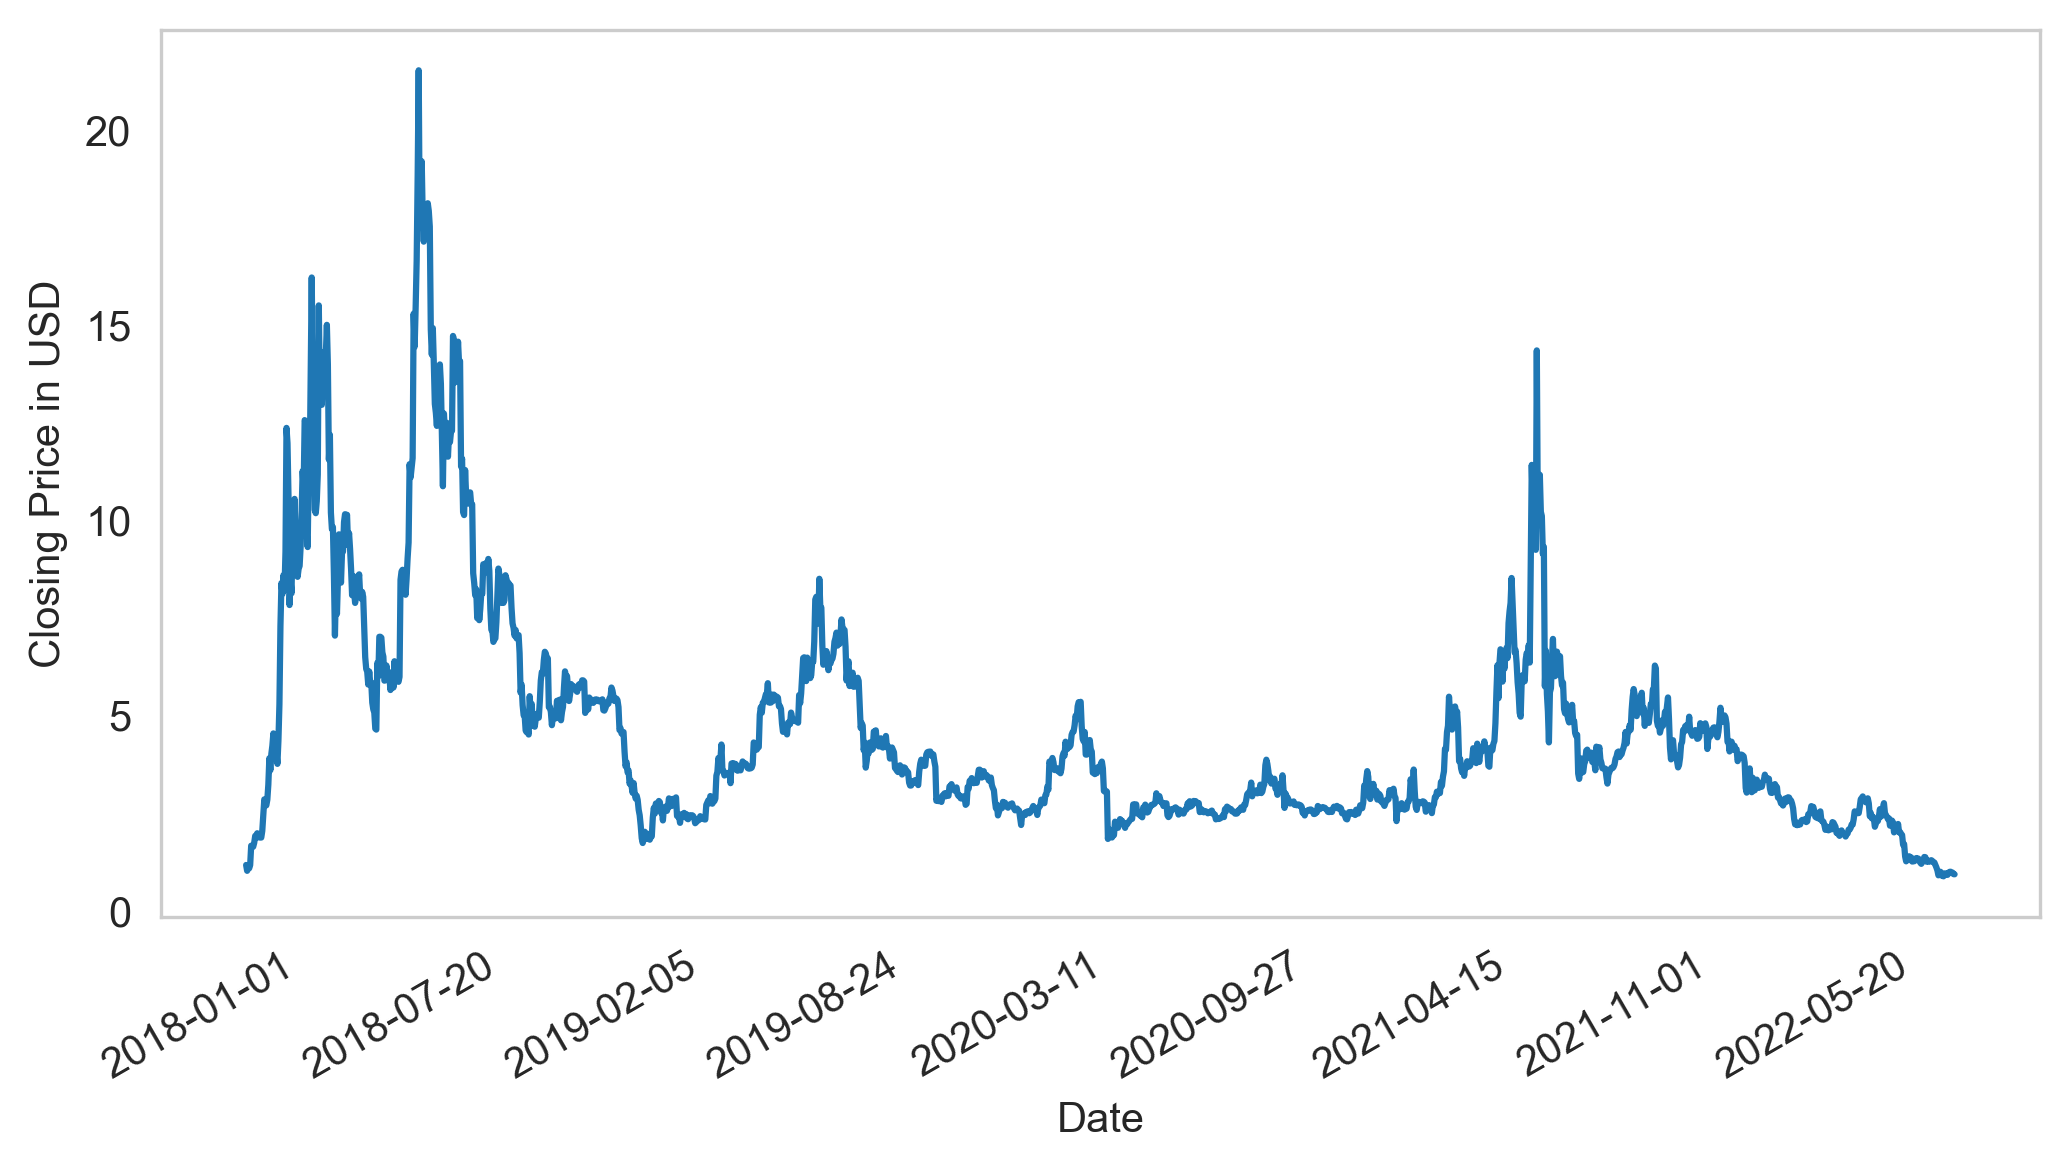

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 250)               252000    
                                

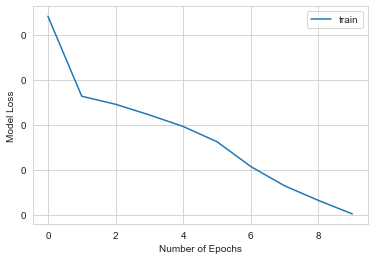

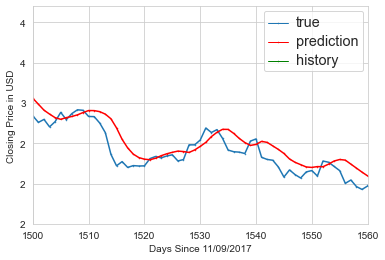

(190,)
(190, 1)
Root mean squared error and time EOS-USD: 0.18459260204278055, 10.4544 s
LSTM run 24/200, 10, EOS-USD


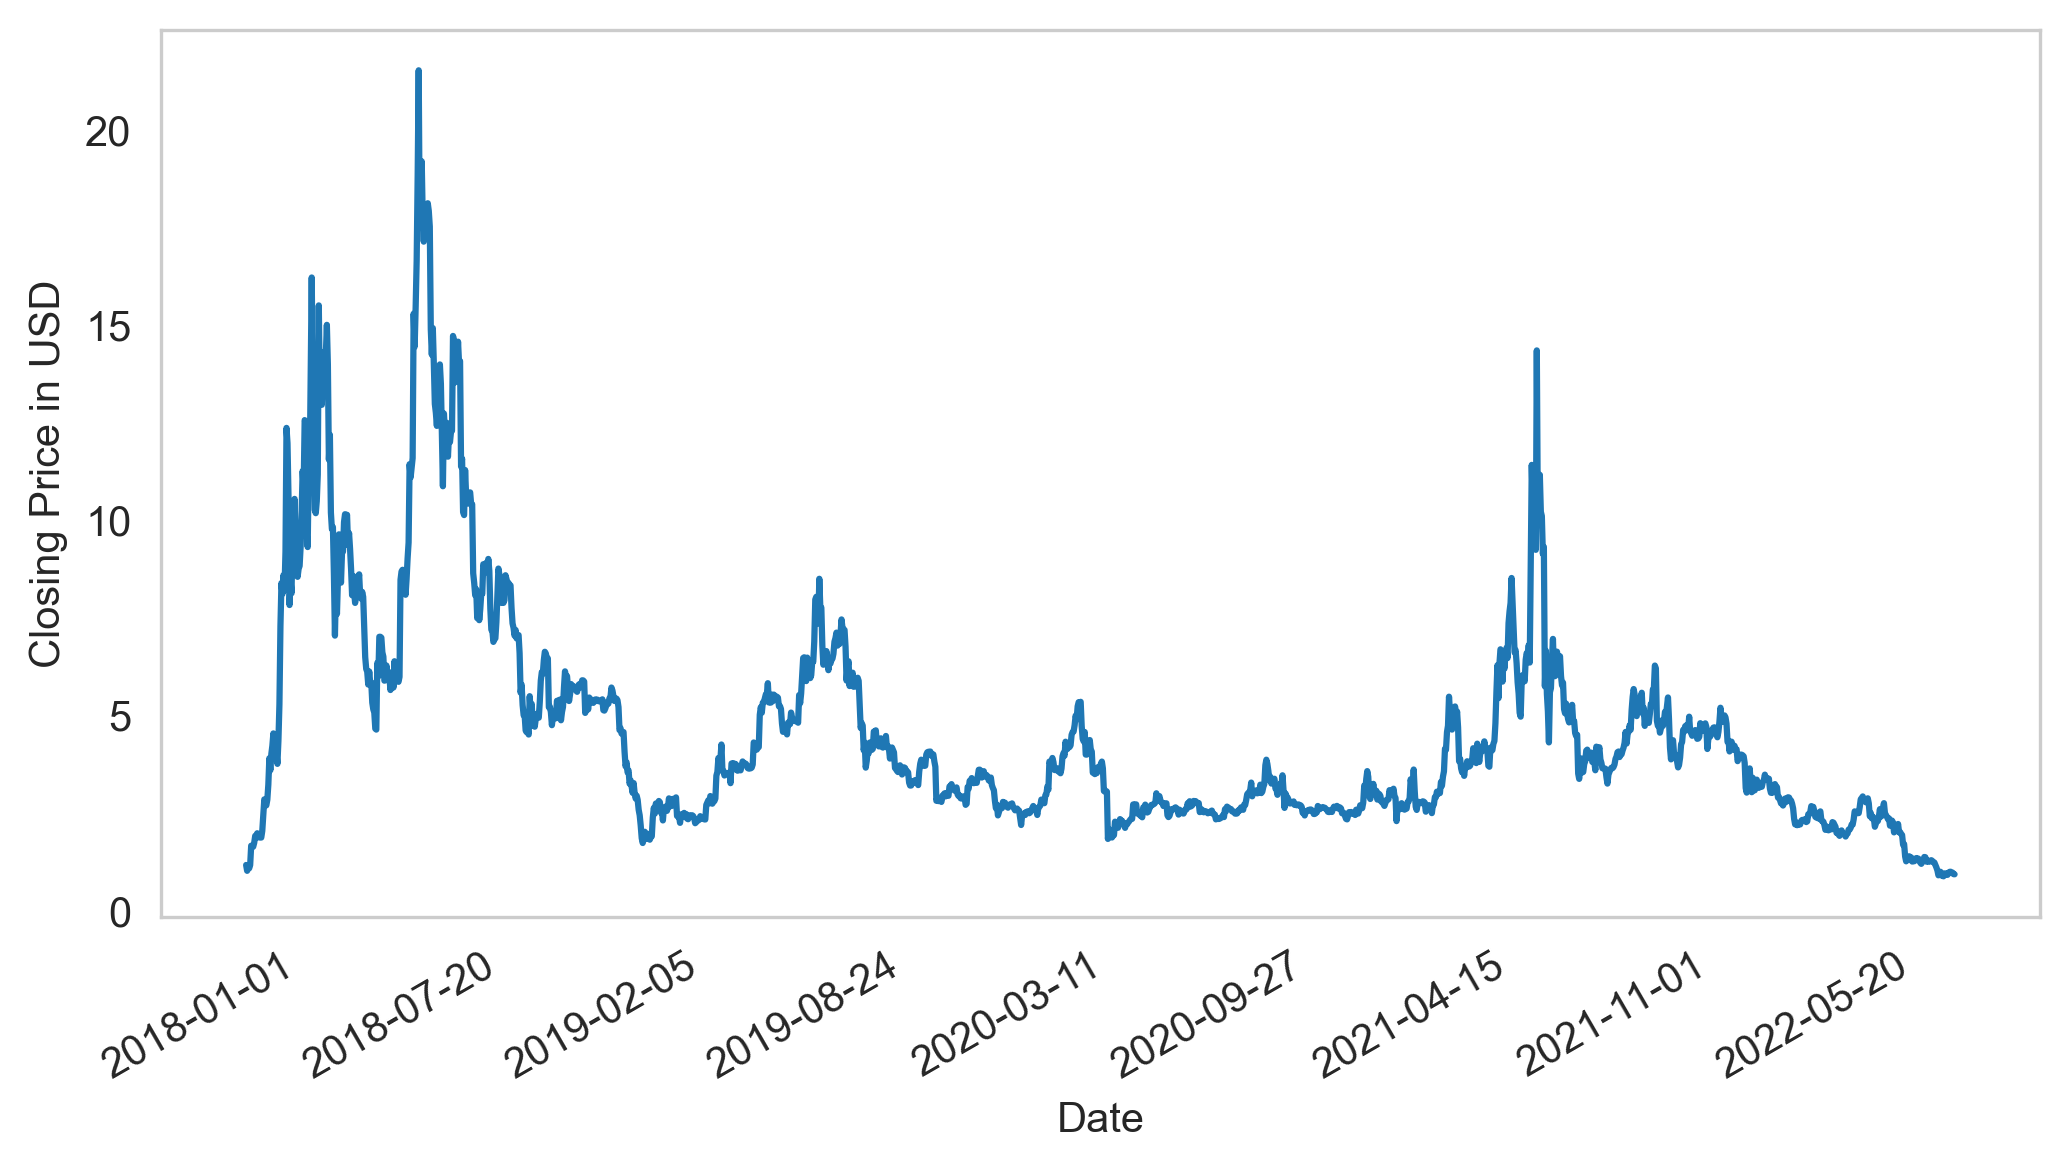

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 250)               252000    
                                

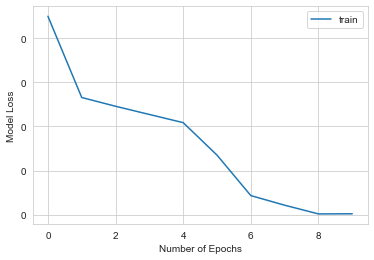

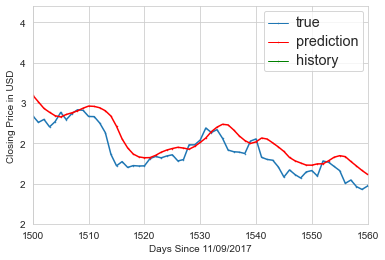

(190,)
(190, 1)
Root mean squared error and time EOS-USD: 0.20112550419501557, 11.2141 s
LSTM run 25/200, 10, EOS-USD


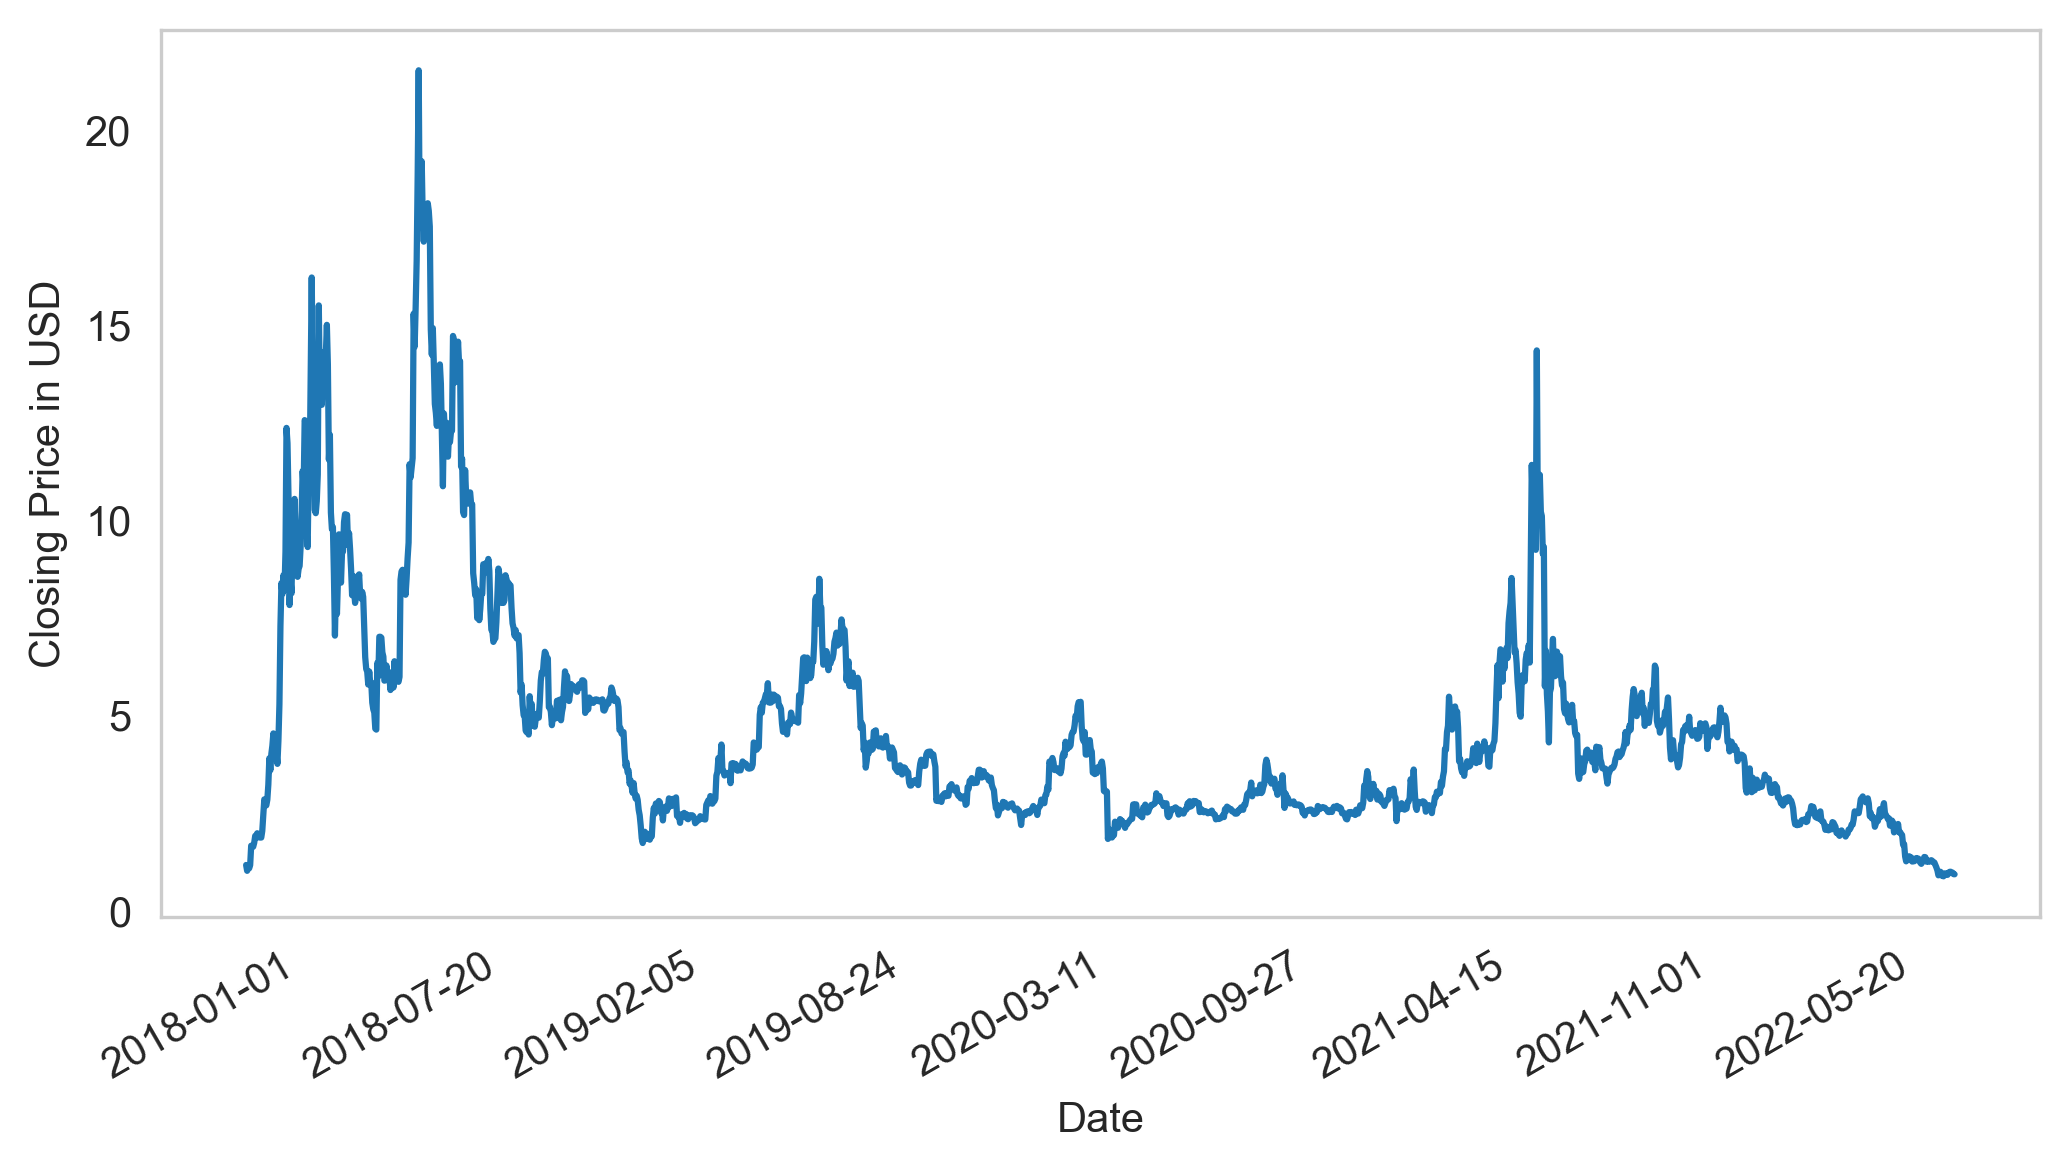

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 250)               252000    
                                

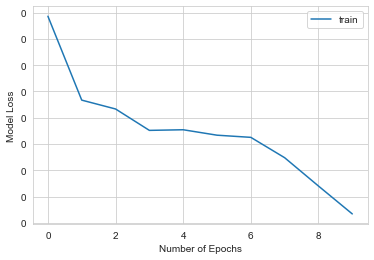

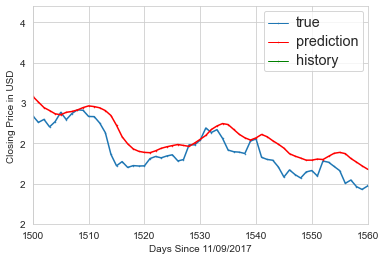

(190,)
(190, 1)
Root mean squared error and time EOS-USD: 0.2491218998725208, 10.4244 s
LSTM run 26/200, 10, BTC-USD


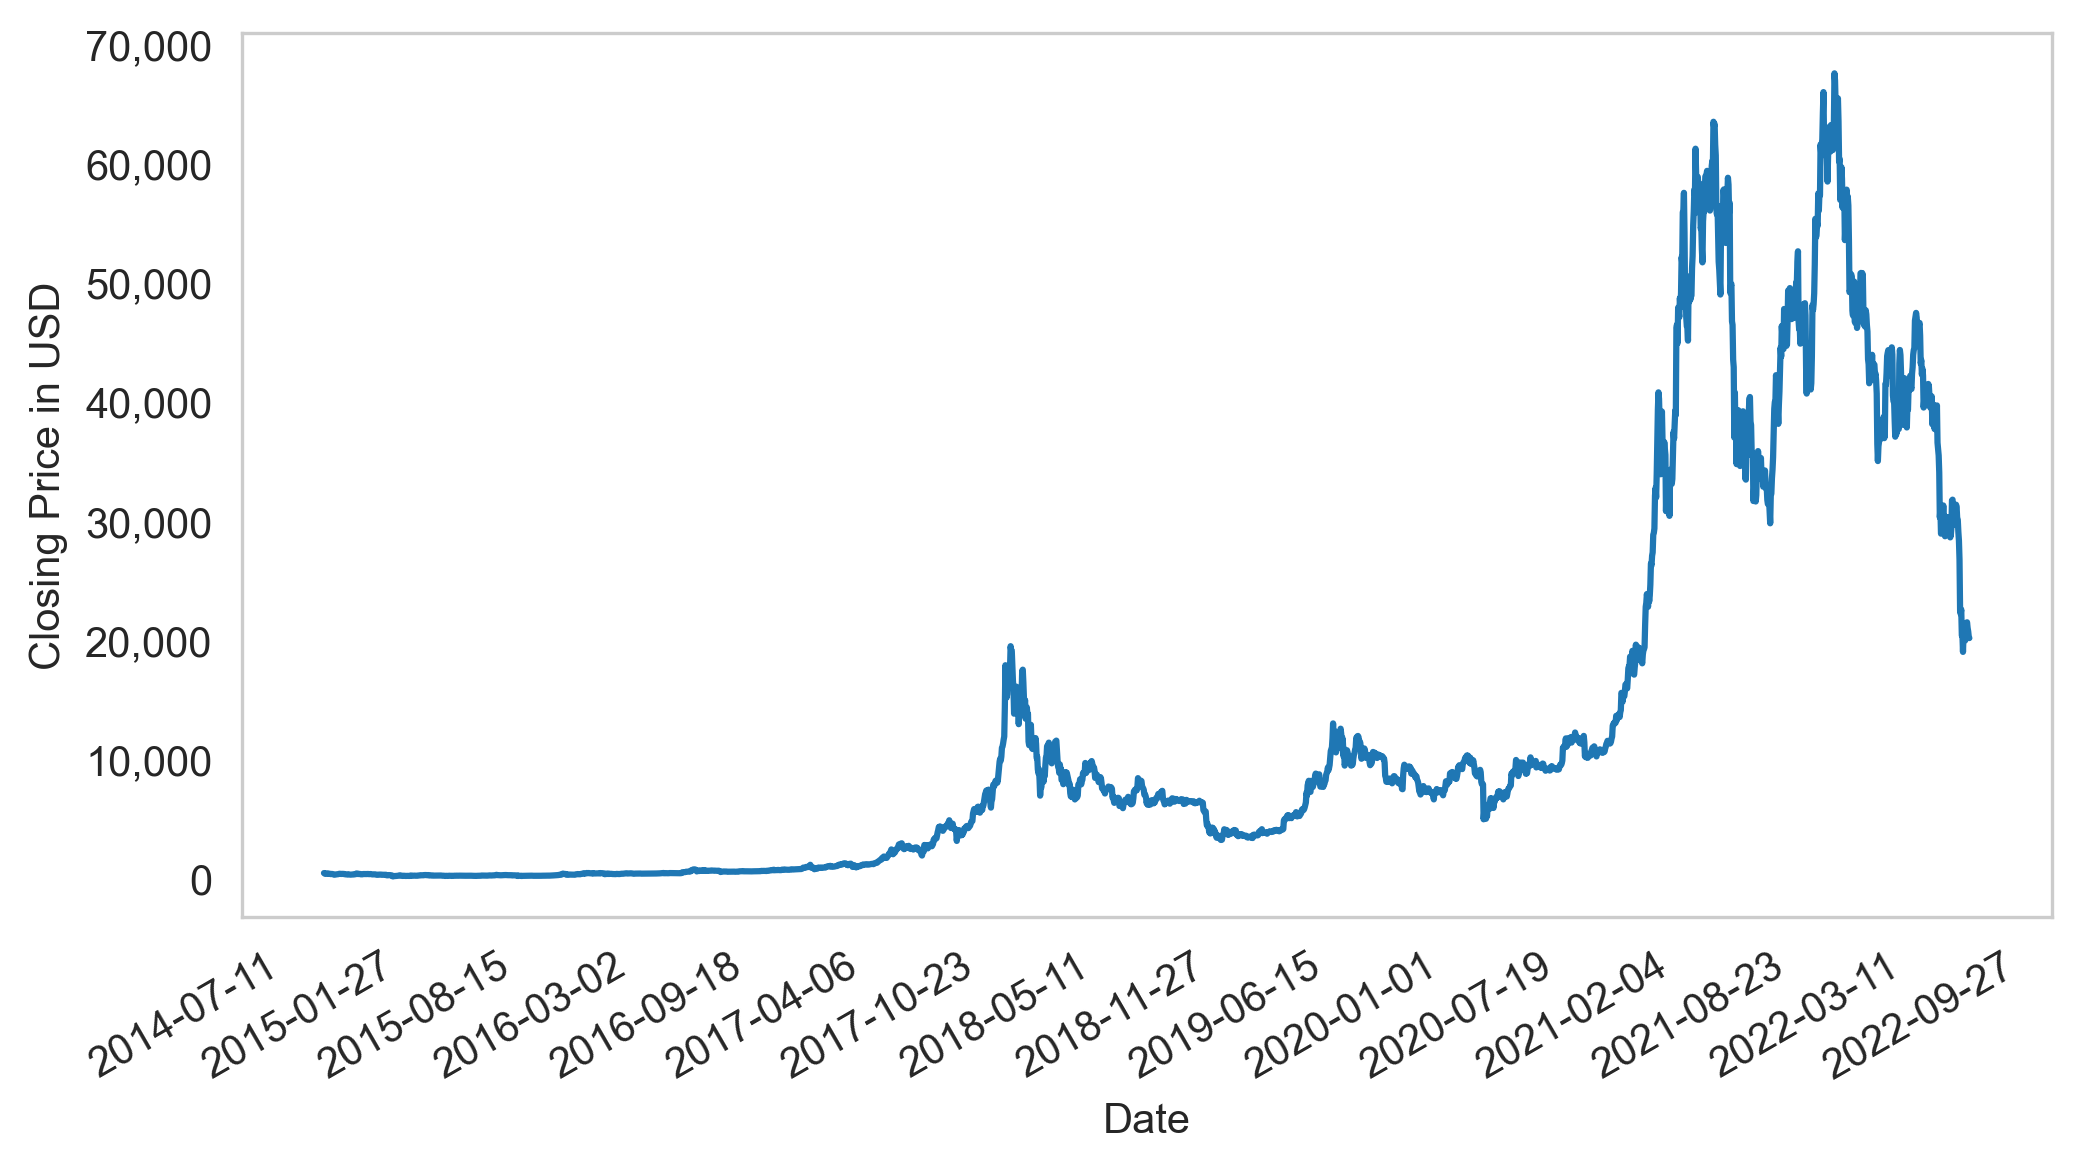

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2643 200
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM

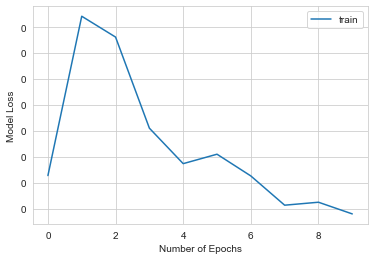

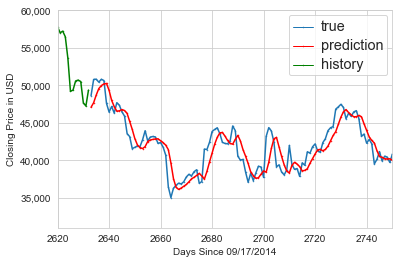

(190,)
(190, 1)
Root mean squared error and time BTC-USD: 1706.1622199059798, 17.7231 s
LSTM run 27/200, 10, BTC-USD


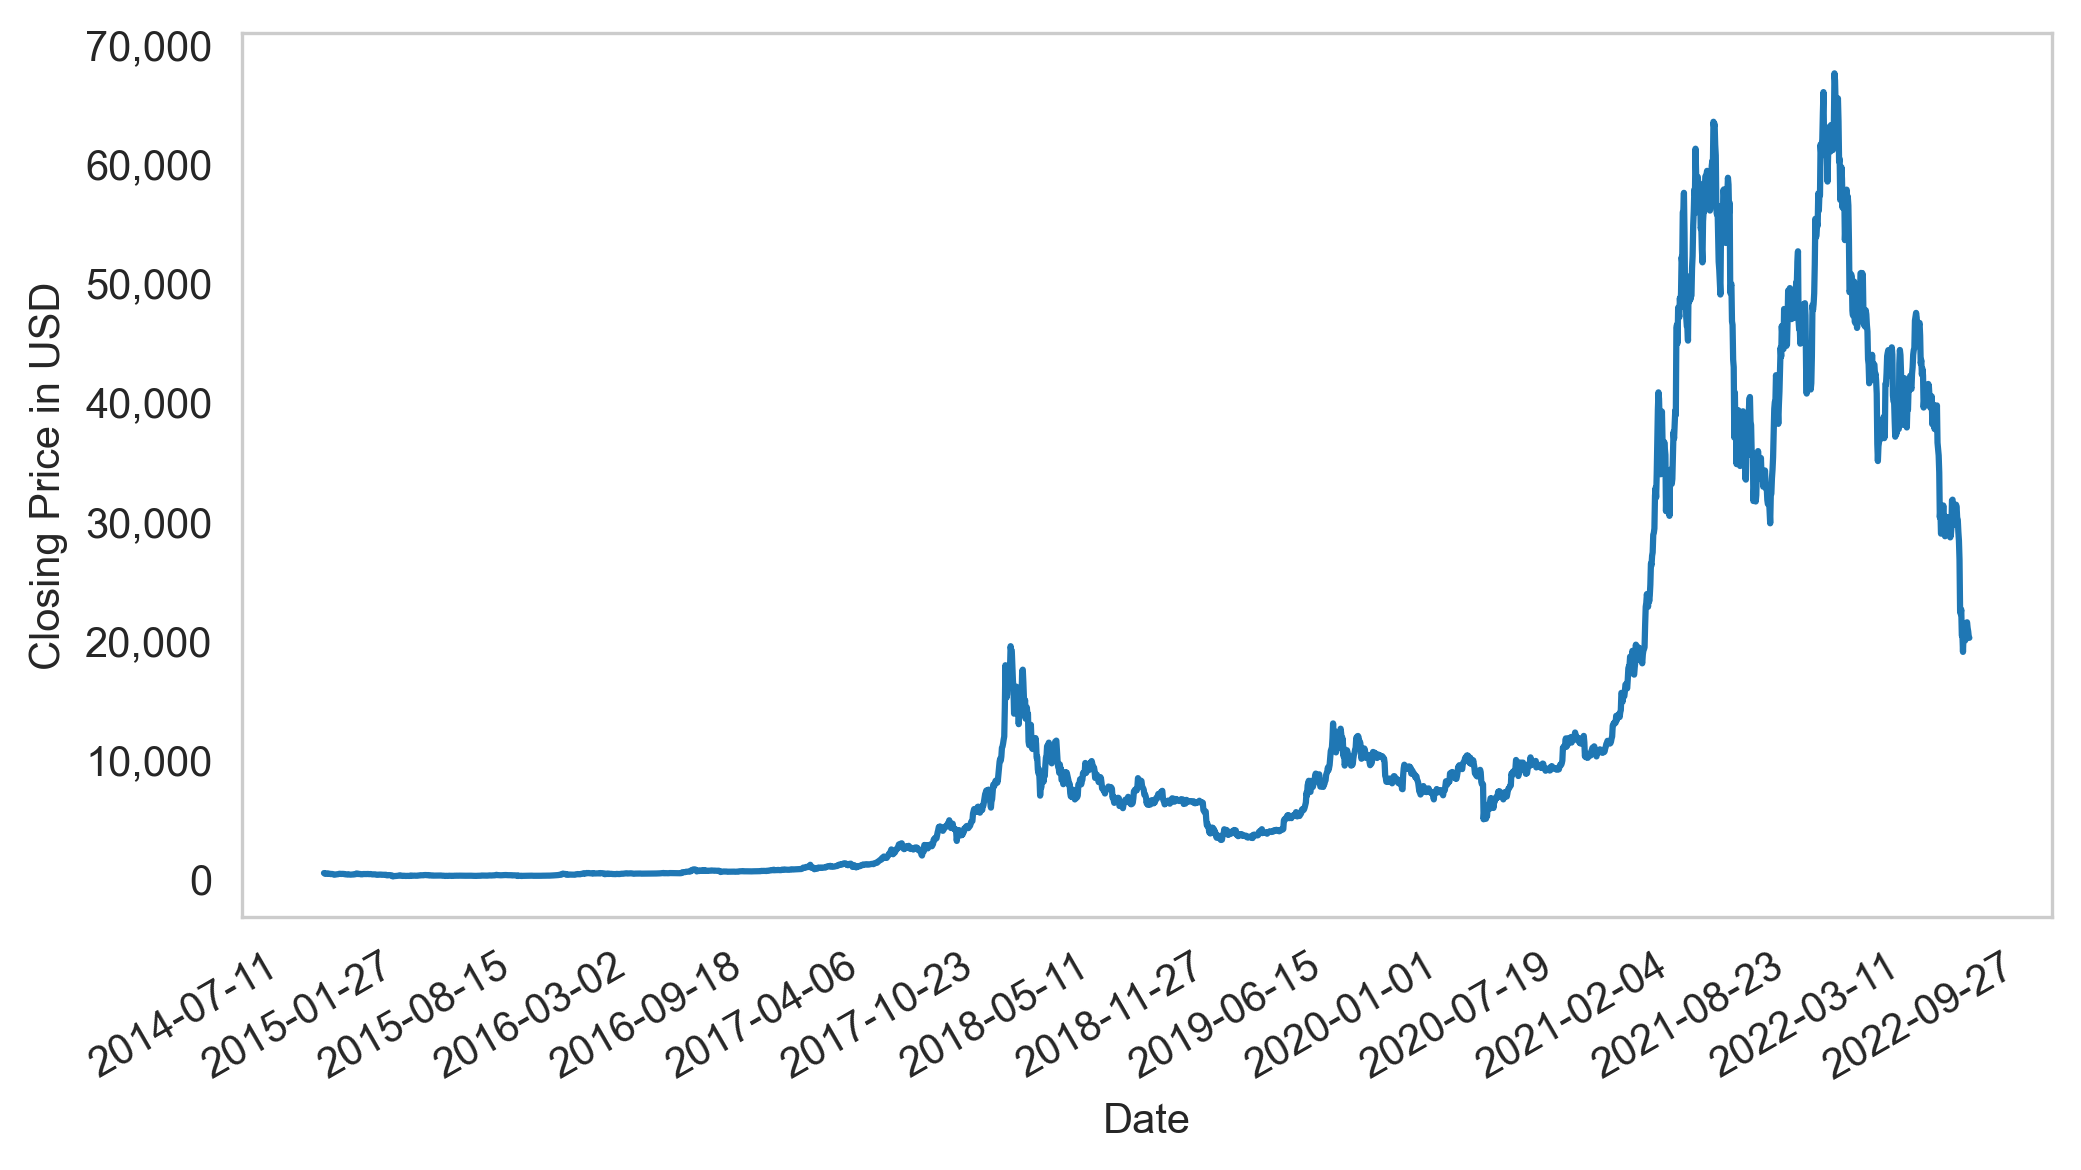

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2643 200
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM

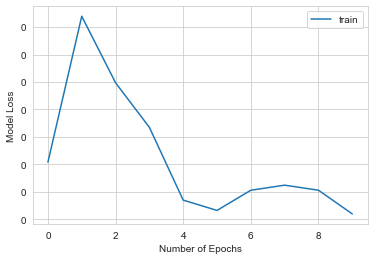

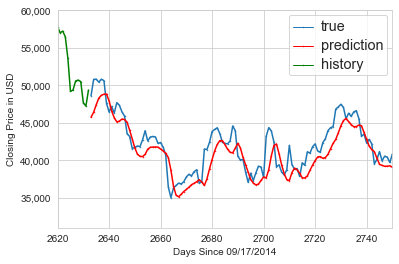

(190,)
(190, 1)
Root mean squared error and time BTC-USD: 1889.9129856762927, 15.4638 s
LSTM run 28/200, 10, BTC-USD


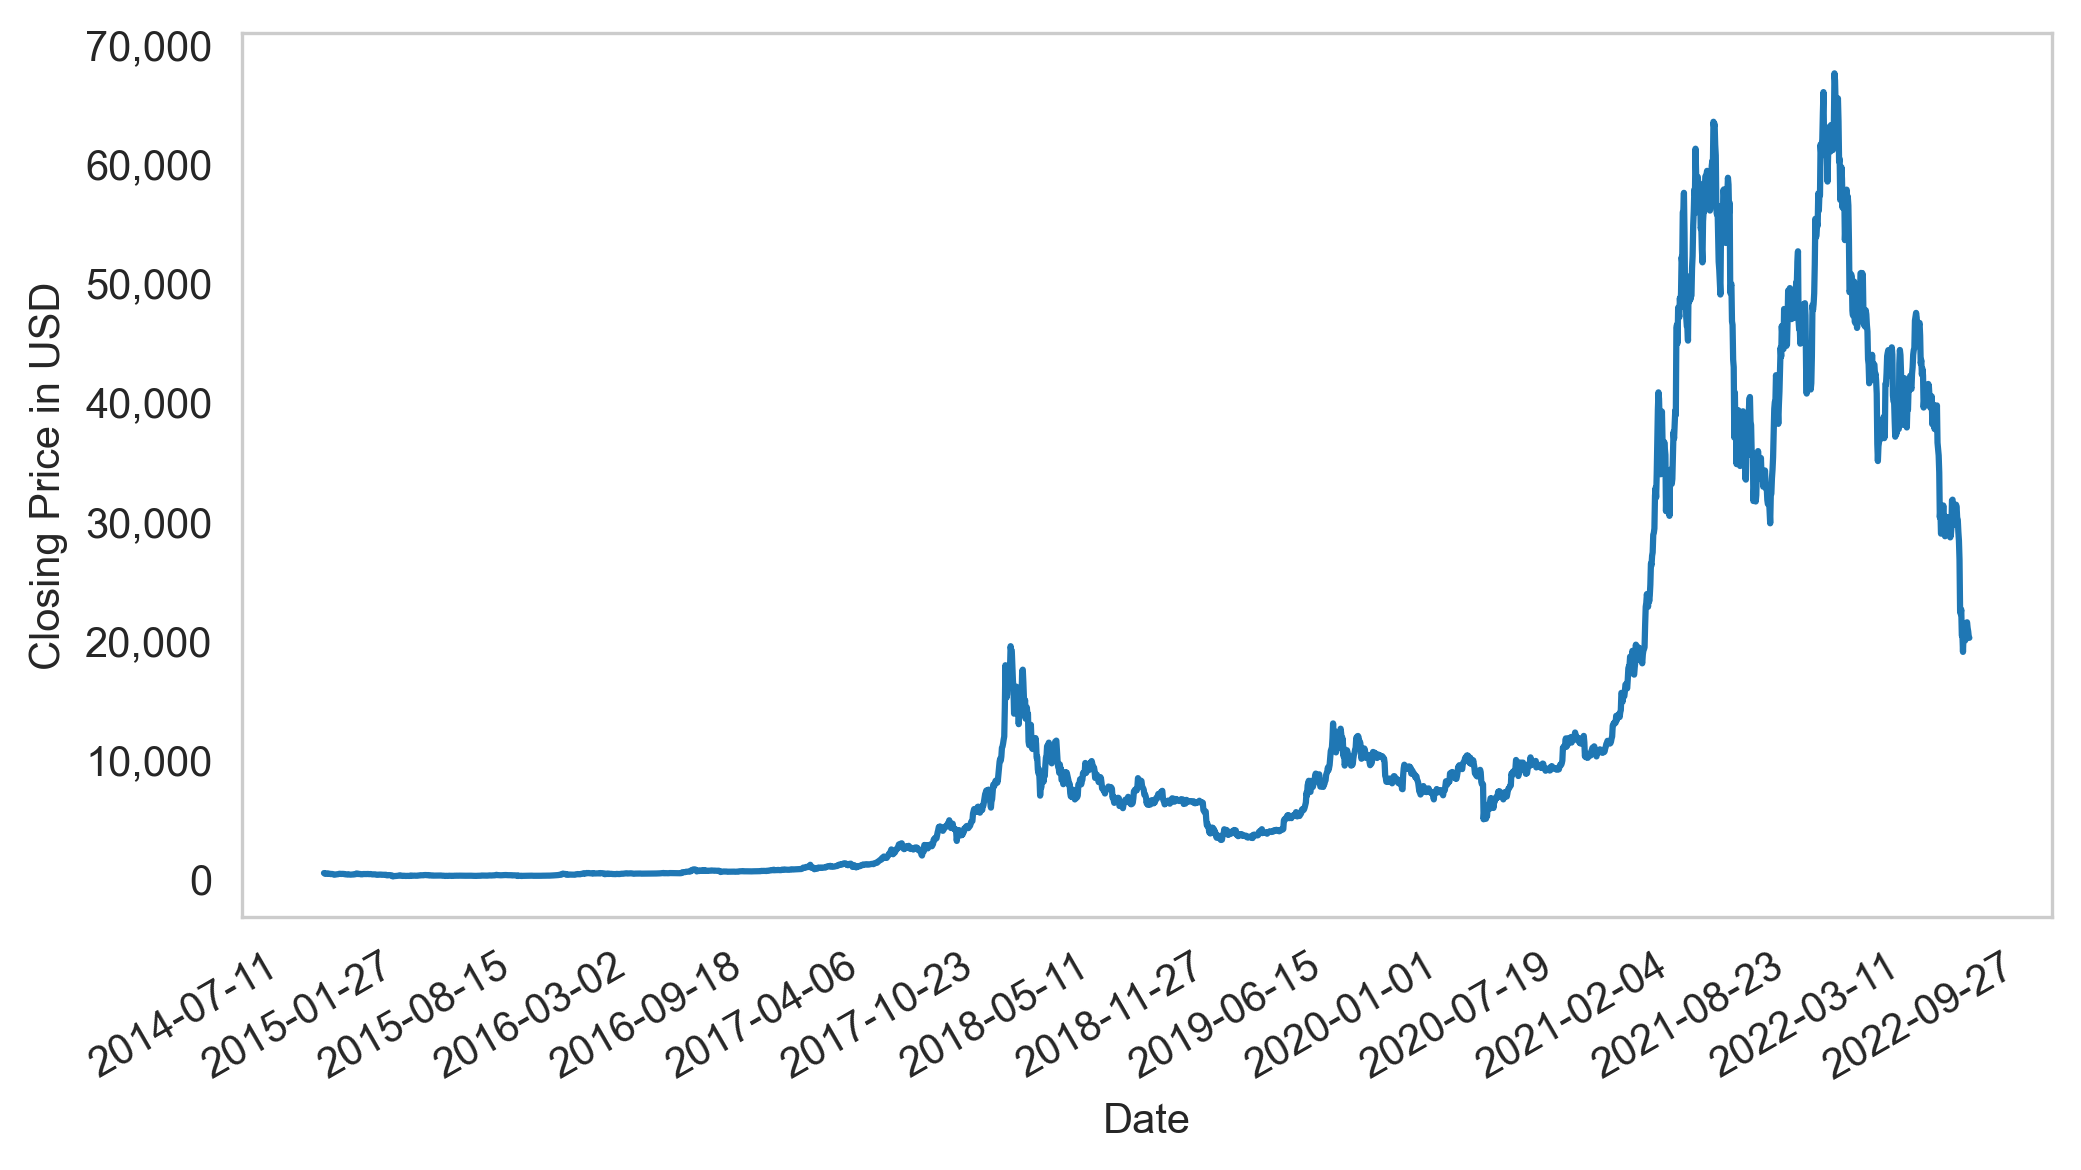

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2643 200
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM

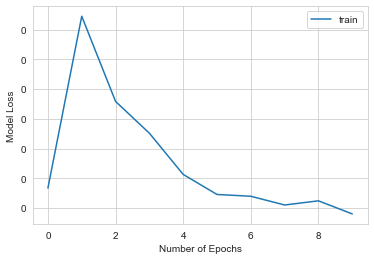

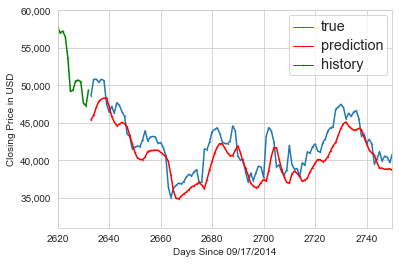

(190,)
(190, 1)
Root mean squared error and time BTC-USD: 2025.8091082579472, 14.8676 s
LSTM run 29/200, 10, BTC-USD


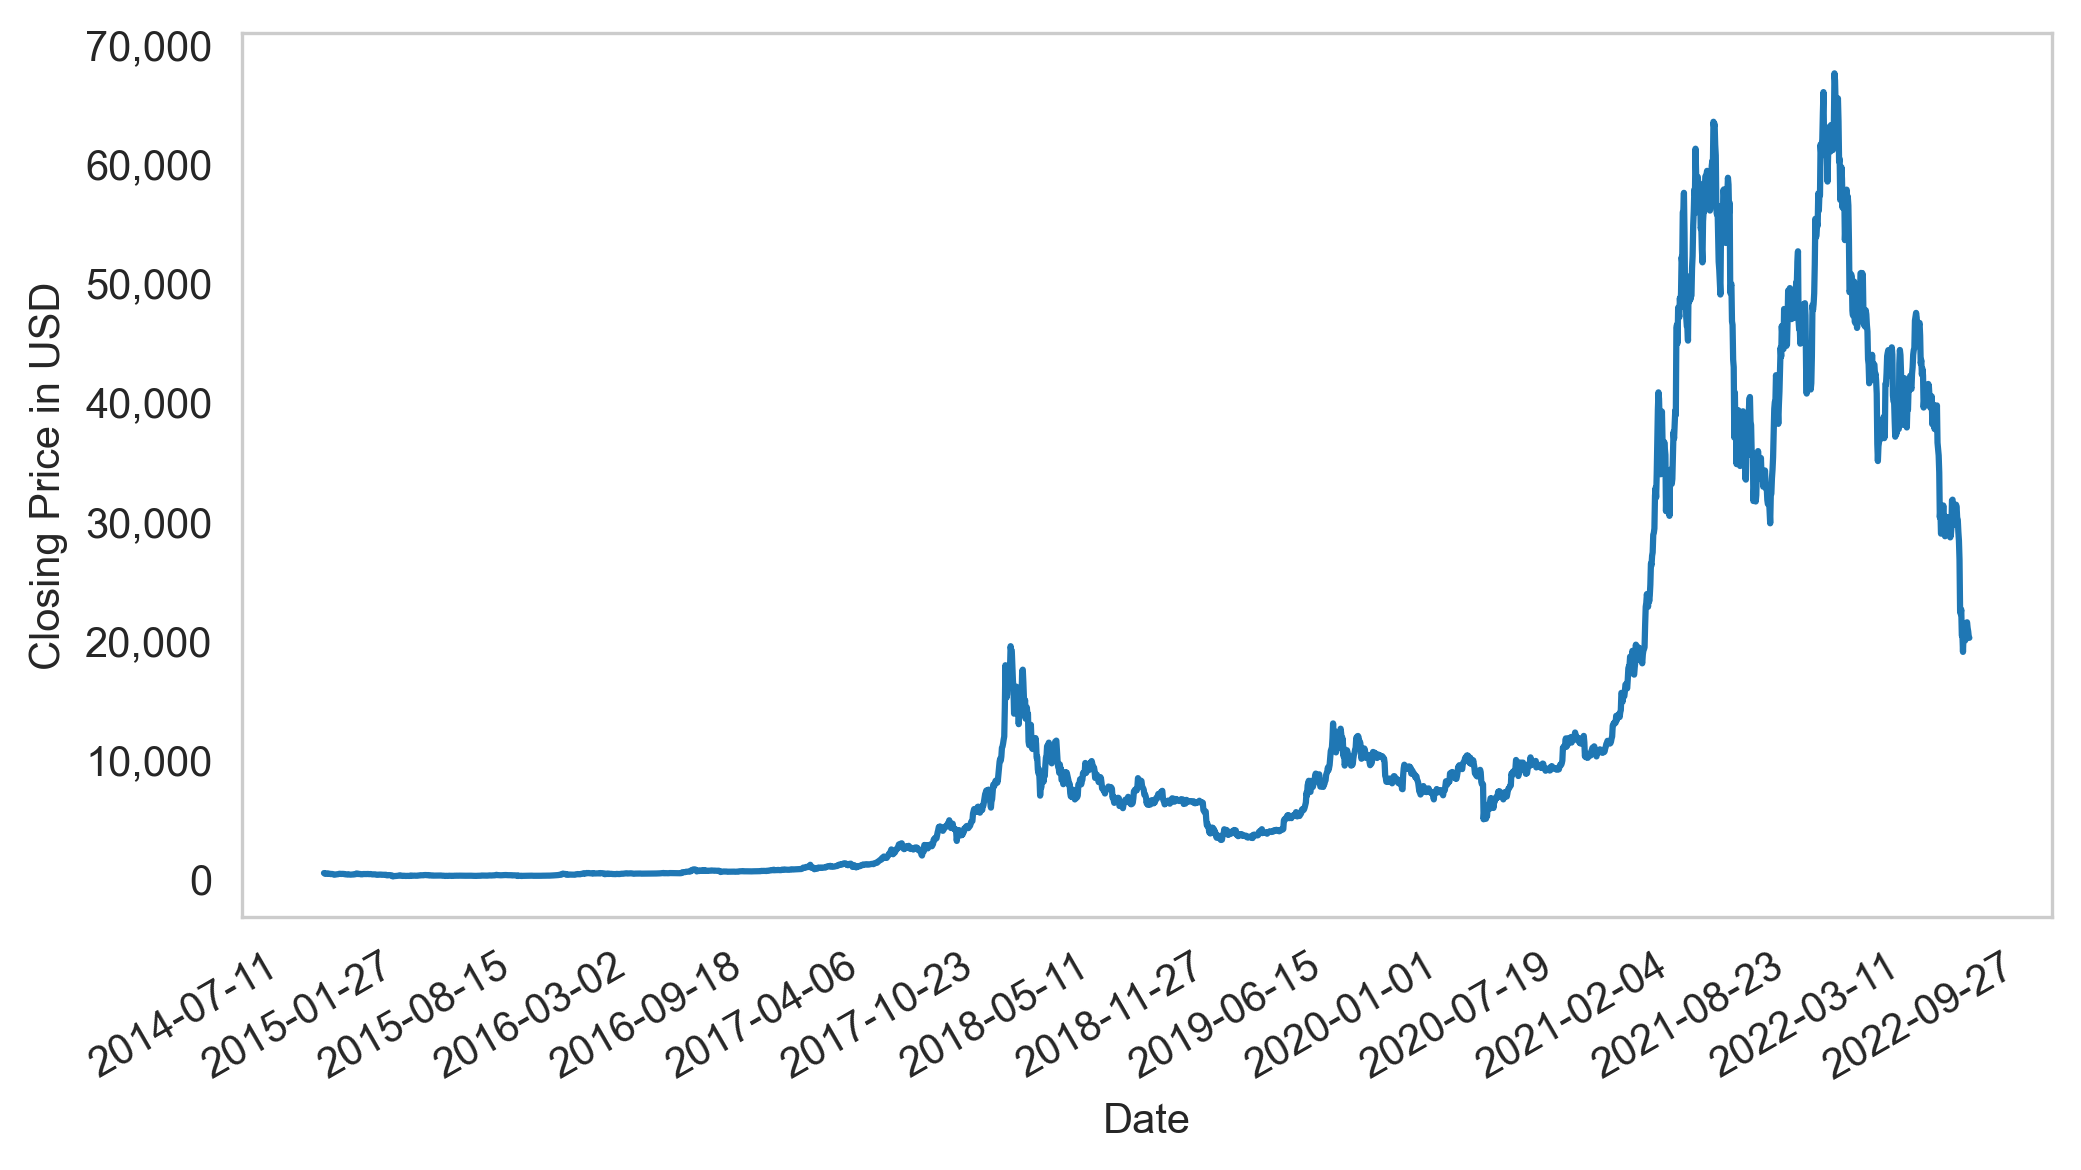

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2643 200
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM

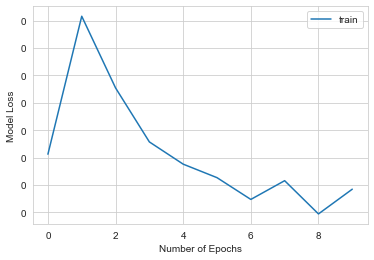

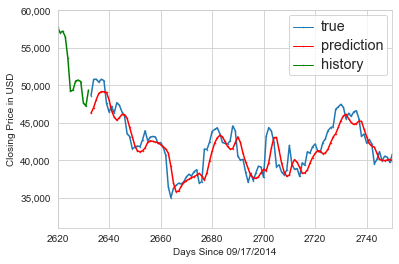

(190,)
(190, 1)
Root mean squared error and time BTC-USD: 1808.9414866050463, 19.3391 s
LSTM run 30/200, 10, BTC-USD


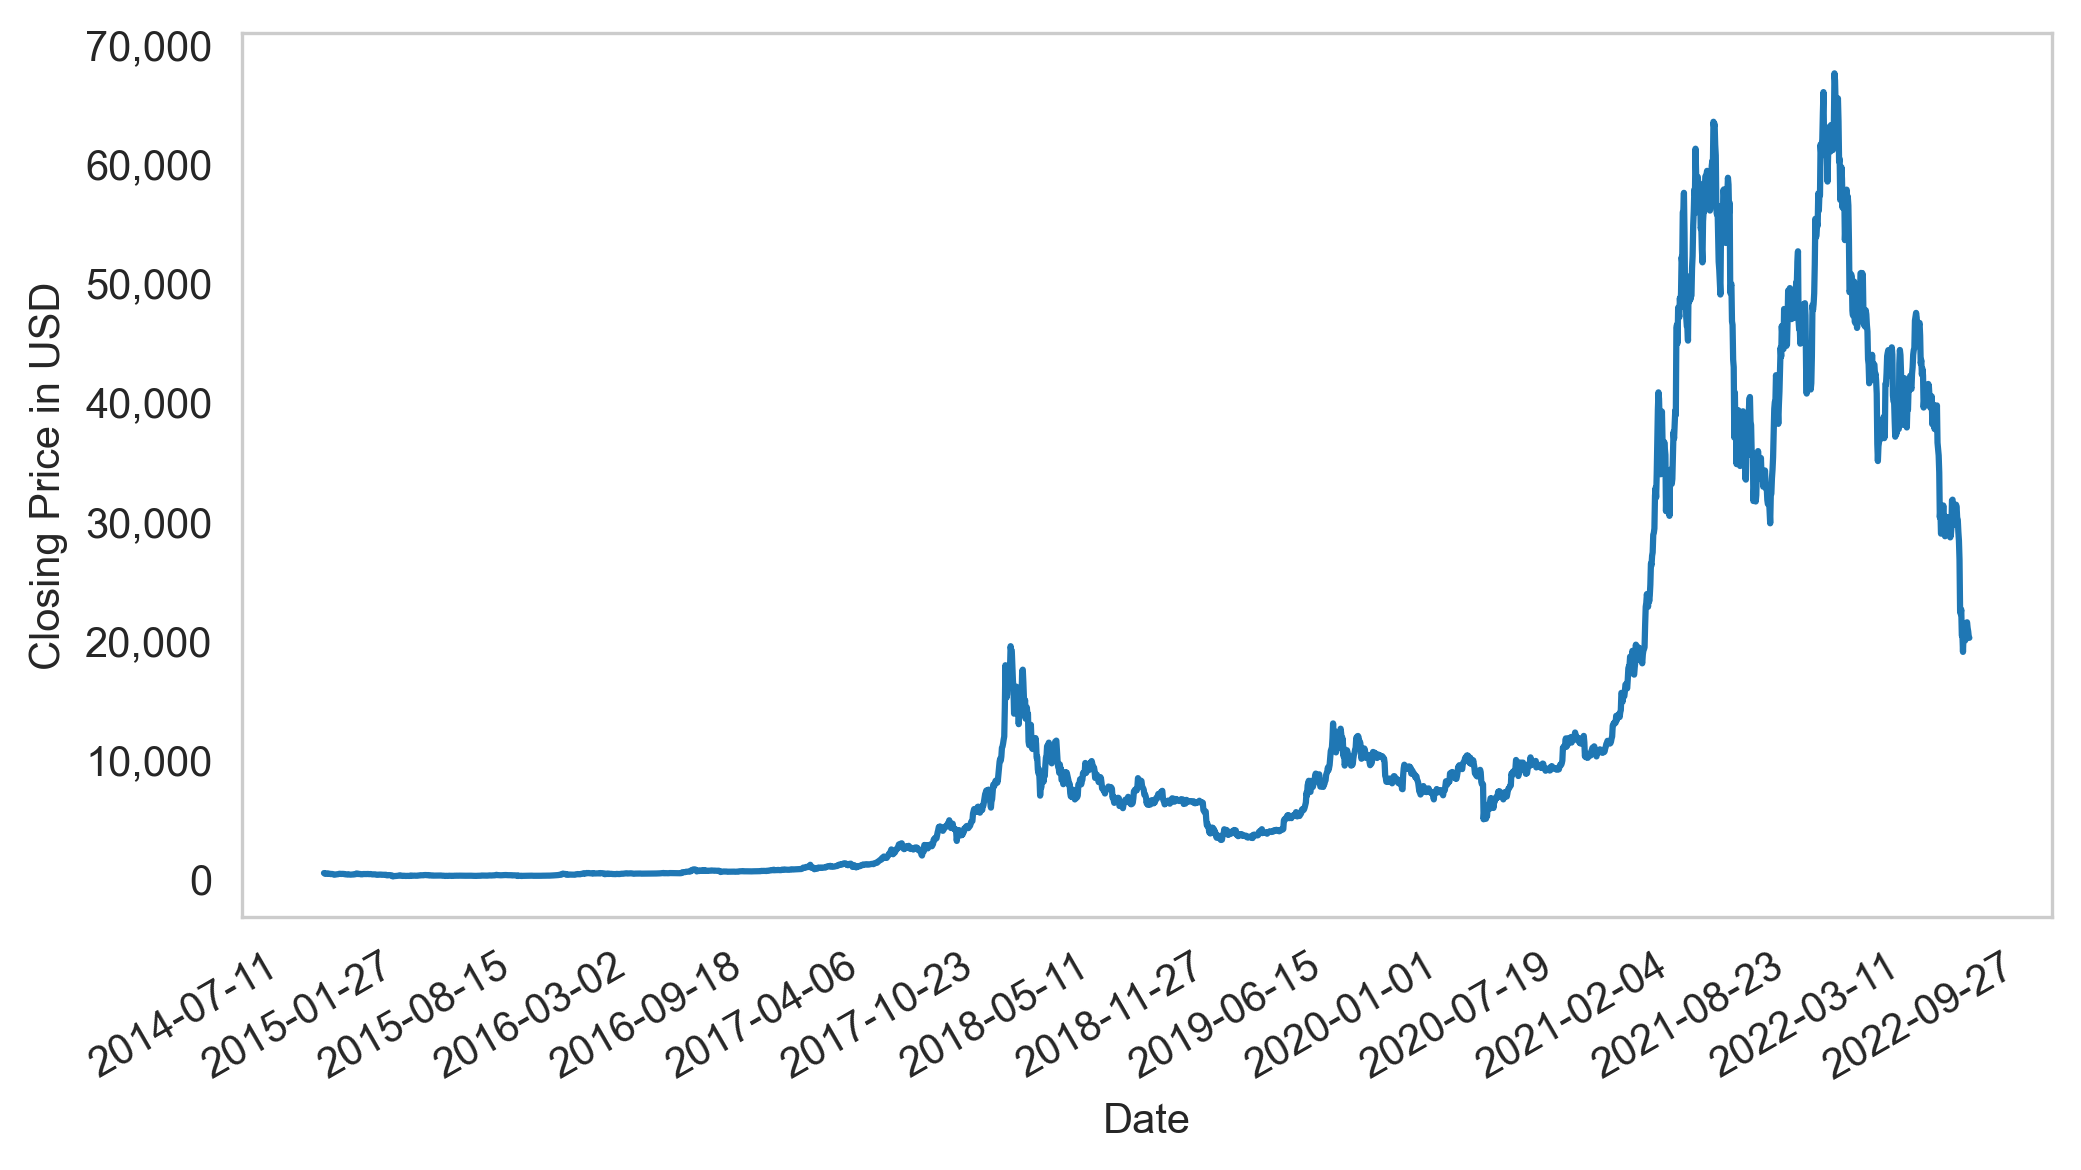

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2643 200
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM

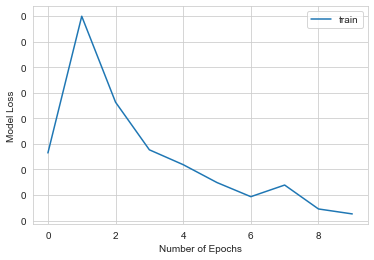

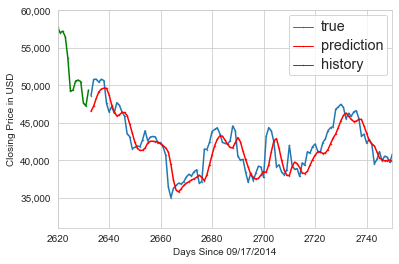

(190,)
(190, 1)
Root mean squared error and time BTC-USD: 1755.049394798872, 16.4578 s
LSTM run 31/200, 10, ETH-USD


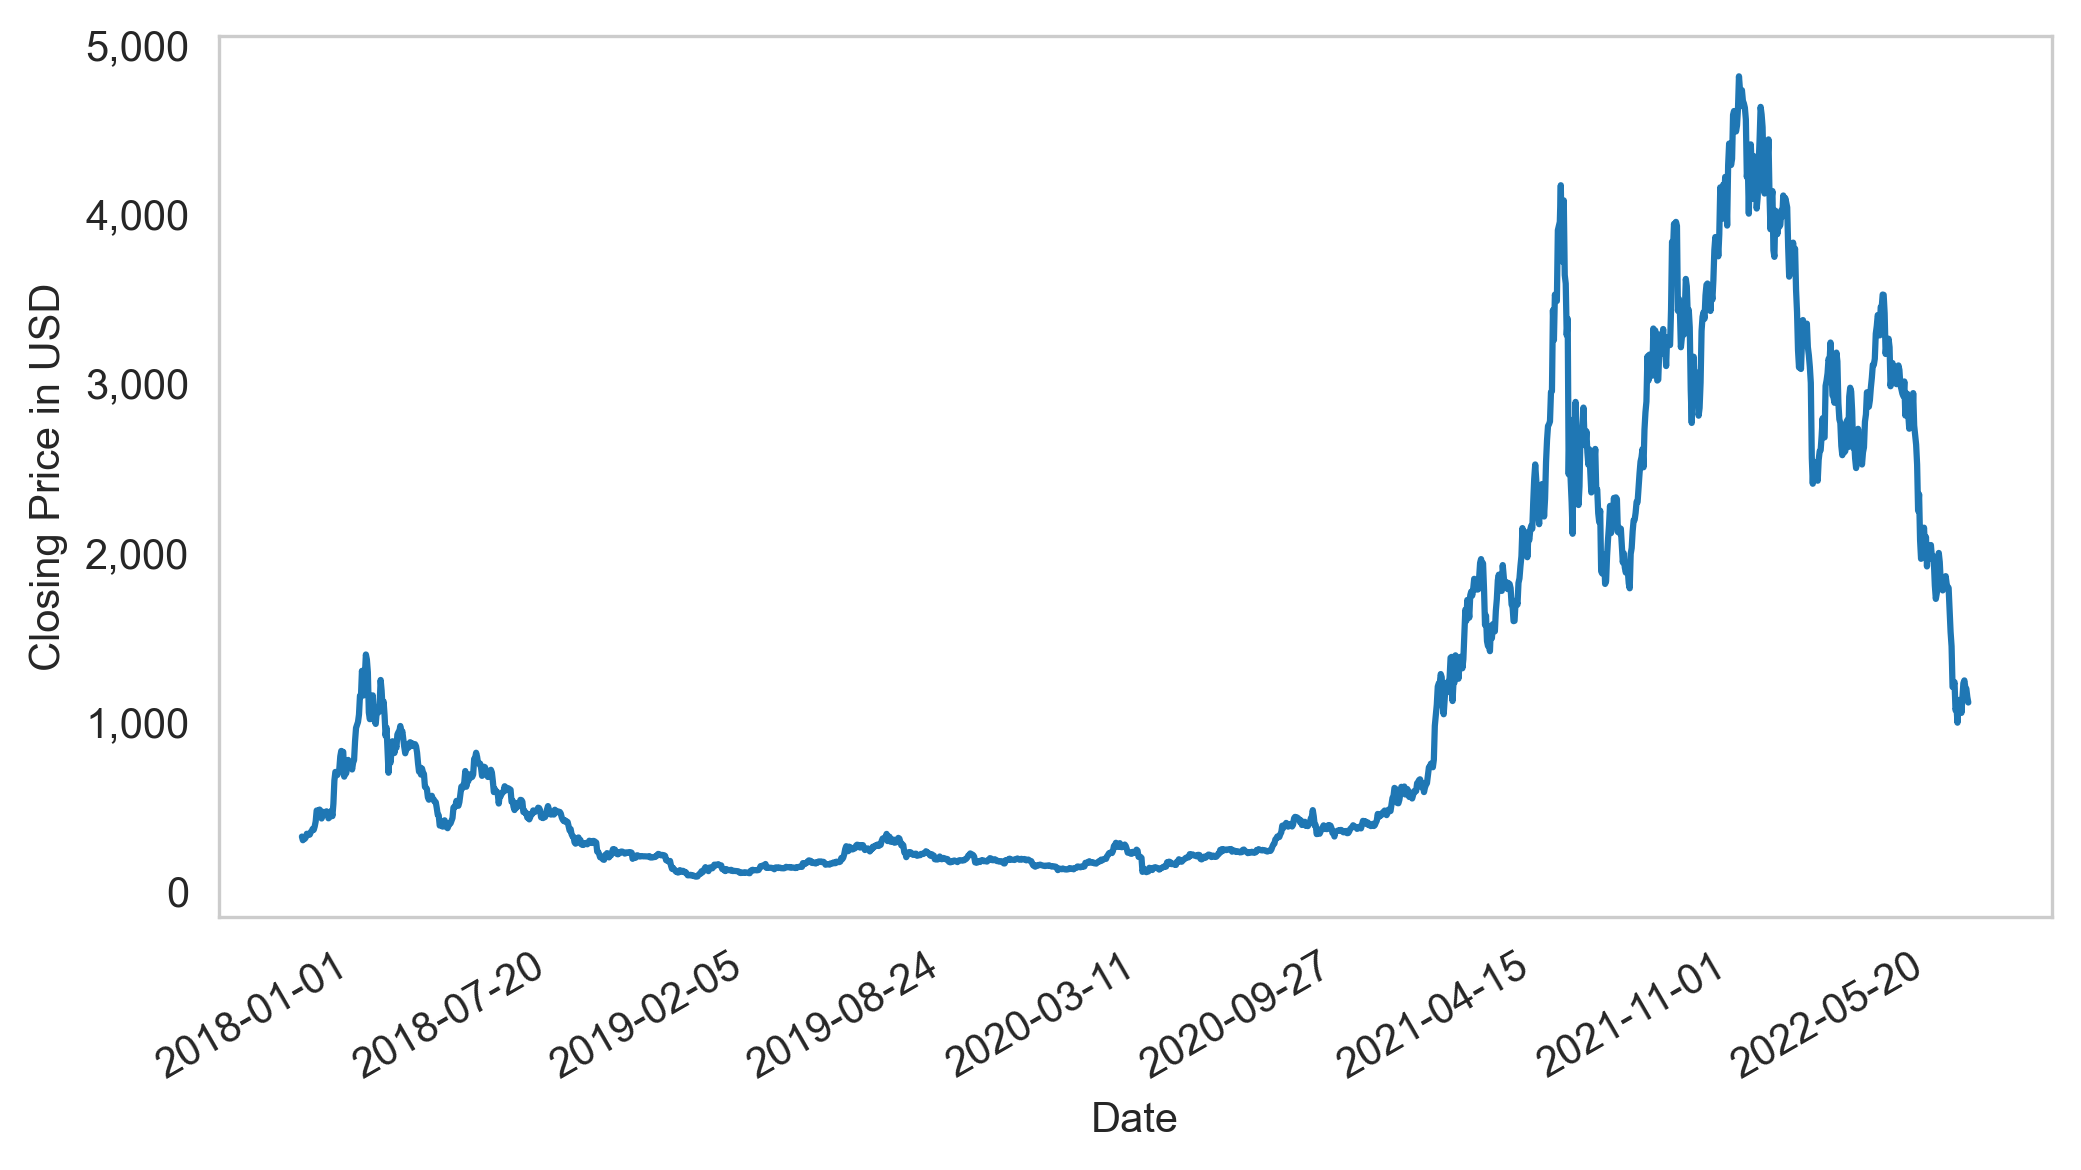

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1494 200
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


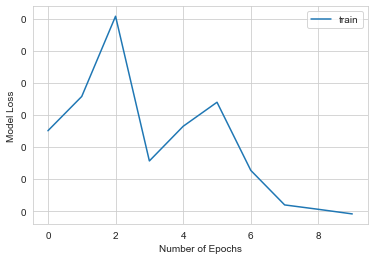

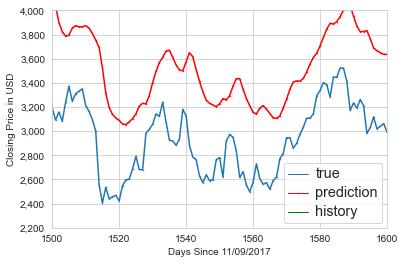

(190,)
(190, 1)
Root mean squared error and time ETH-USD: 614.3413626494267, 12.3933 s
LSTM run 32/200, 10, ETH-USD


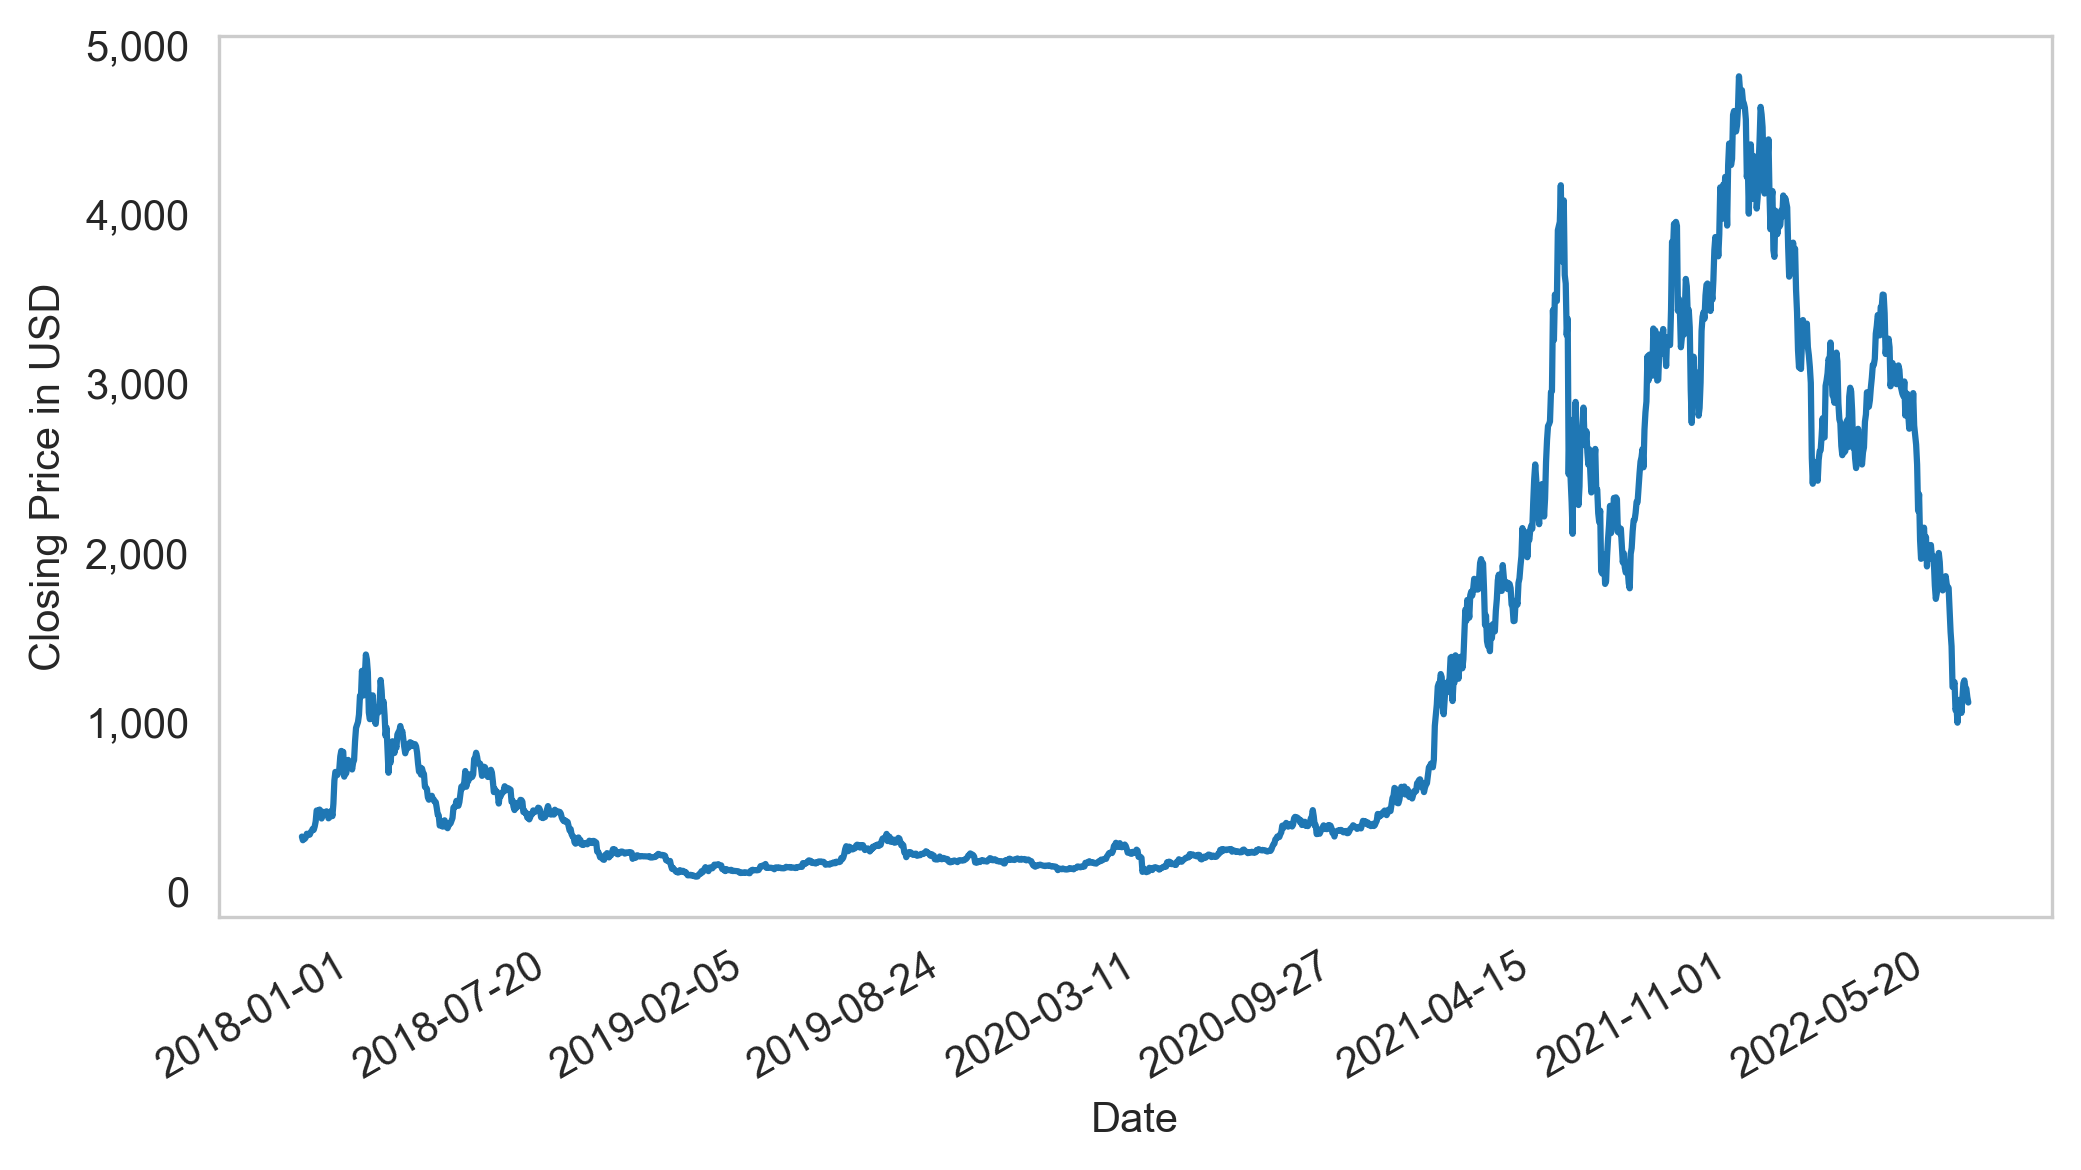

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1494 200
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


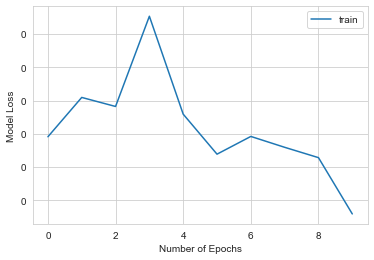

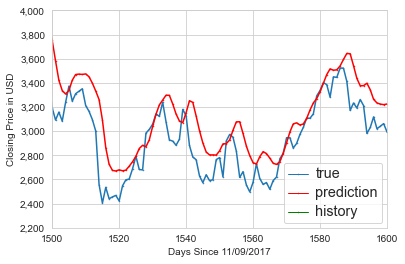

(190,)
(190, 1)
Root mean squared error and time ETH-USD: 258.4015361039523, 11.3925 s
LSTM run 33/200, 10, ETH-USD


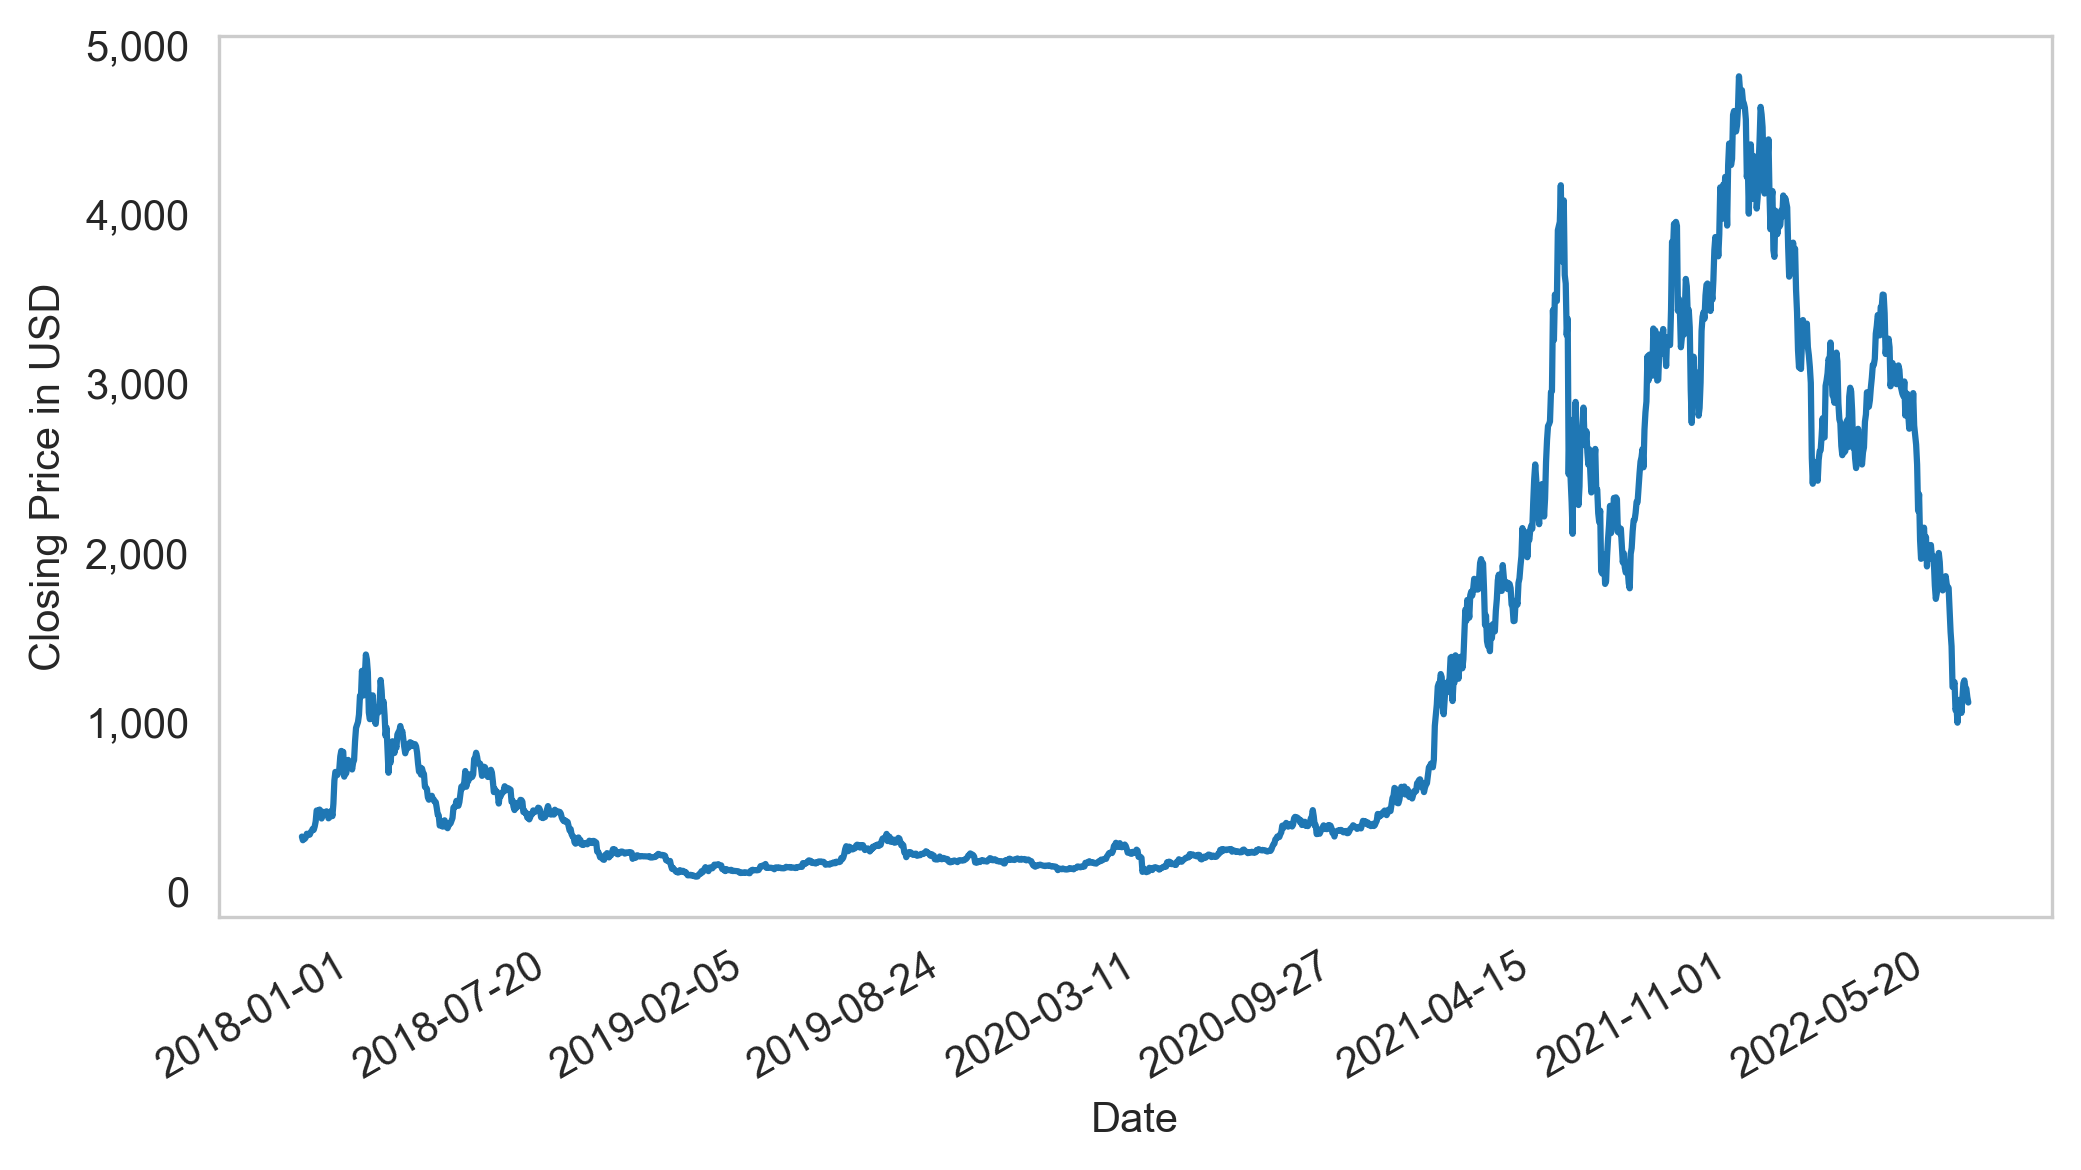

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1494 200
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


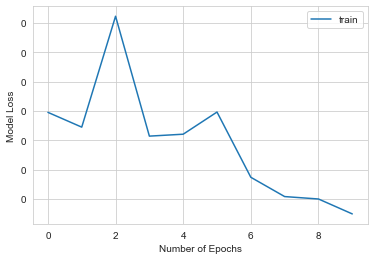

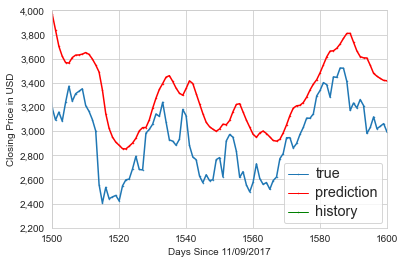

(190,)
(190, 1)
Root mean squared error and time ETH-USD: 425.4285681430591, 10.6821 s
LSTM run 34/200, 10, ETH-USD


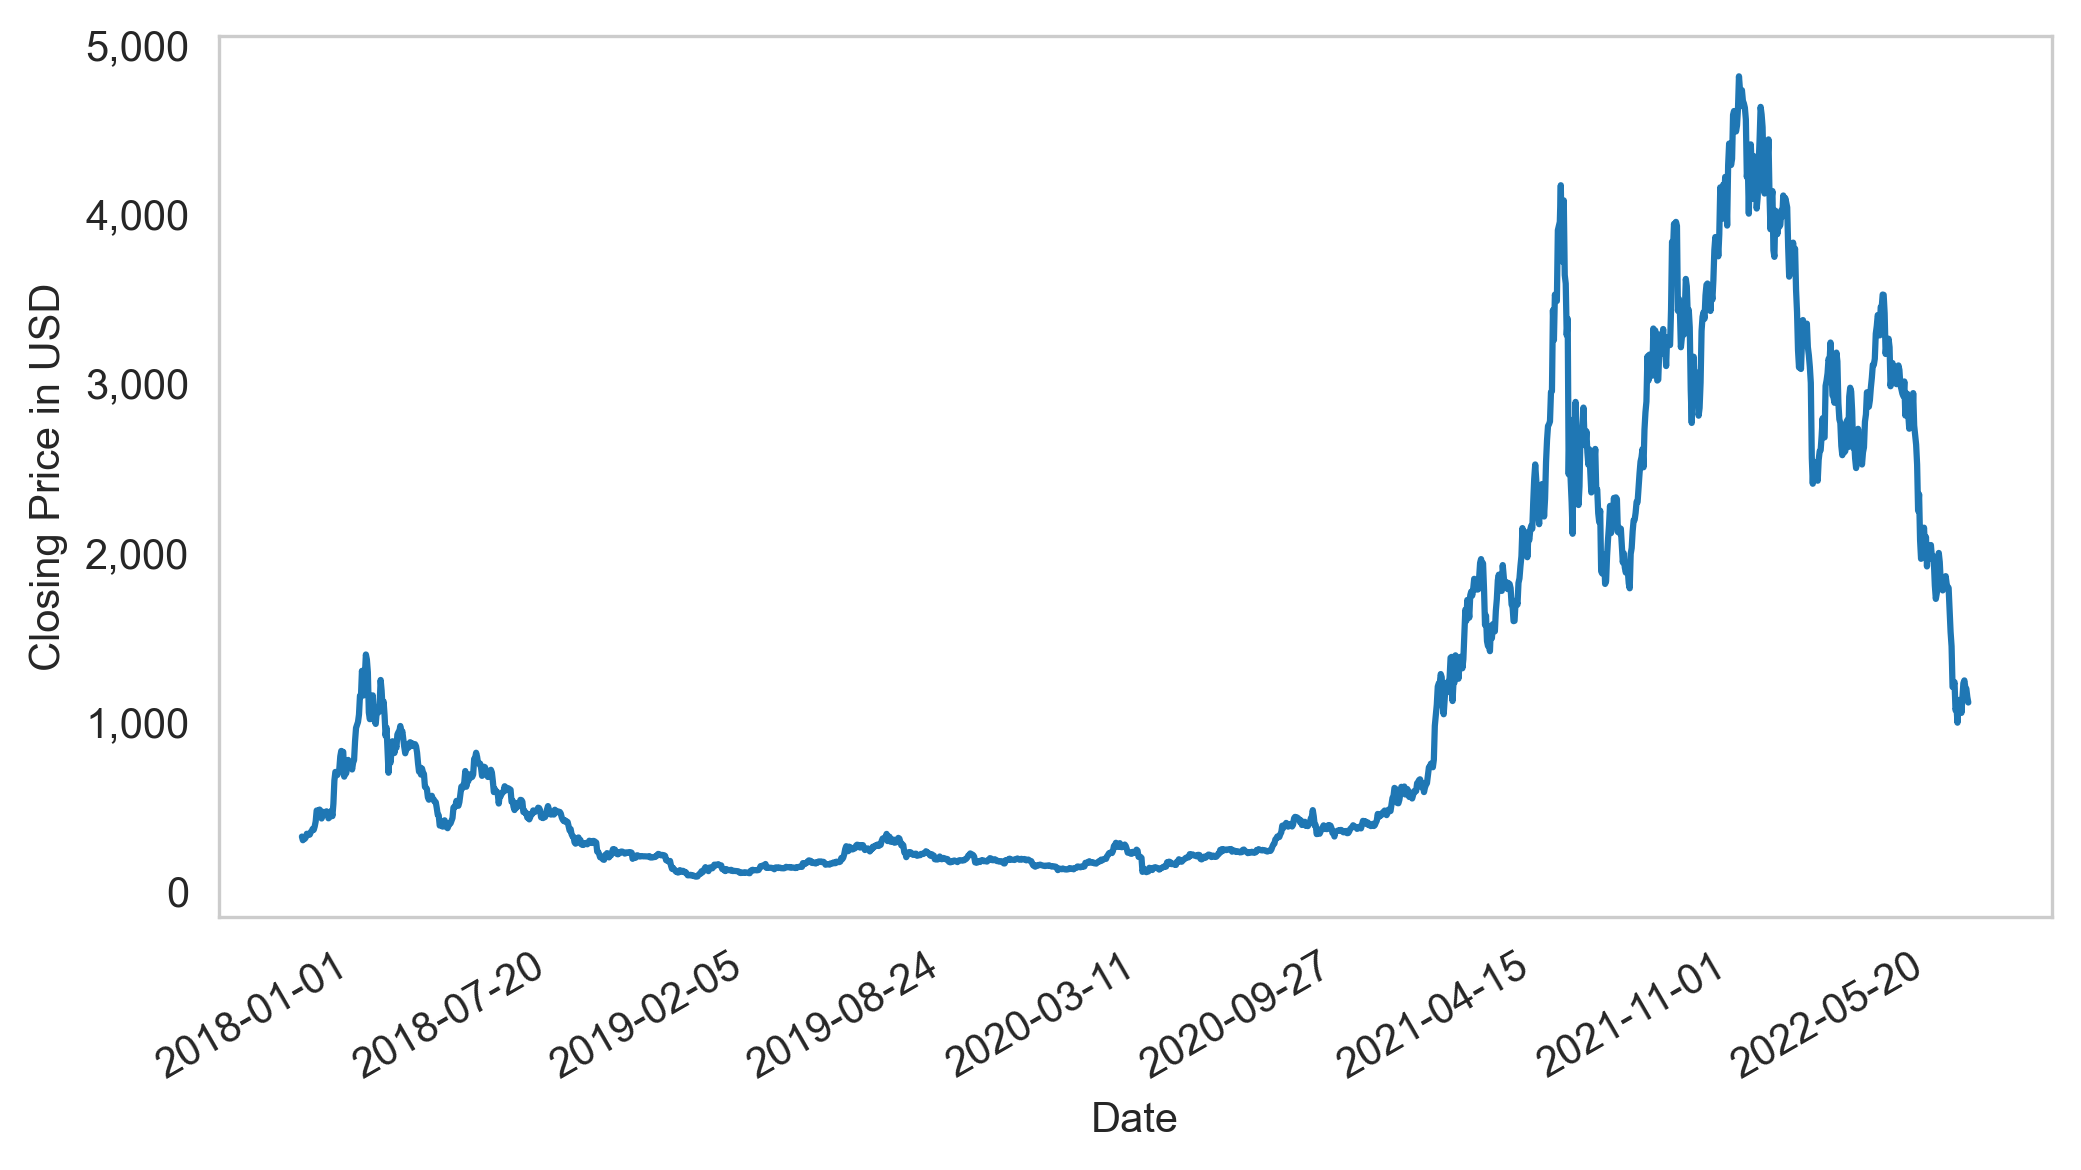

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1494 200
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


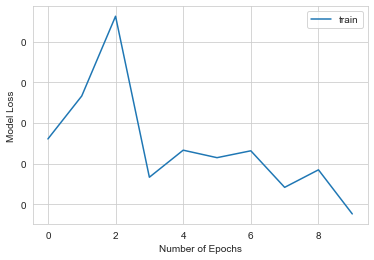

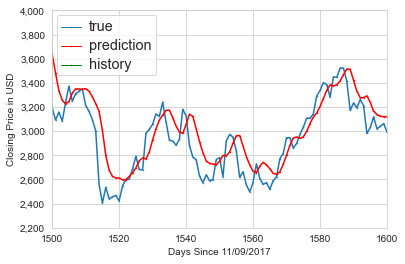

(190,)
(190, 1)
Root mean squared error and time ETH-USD: 207.35795571802538, 10.9002 s
LSTM run 35/200, 10, ETH-USD


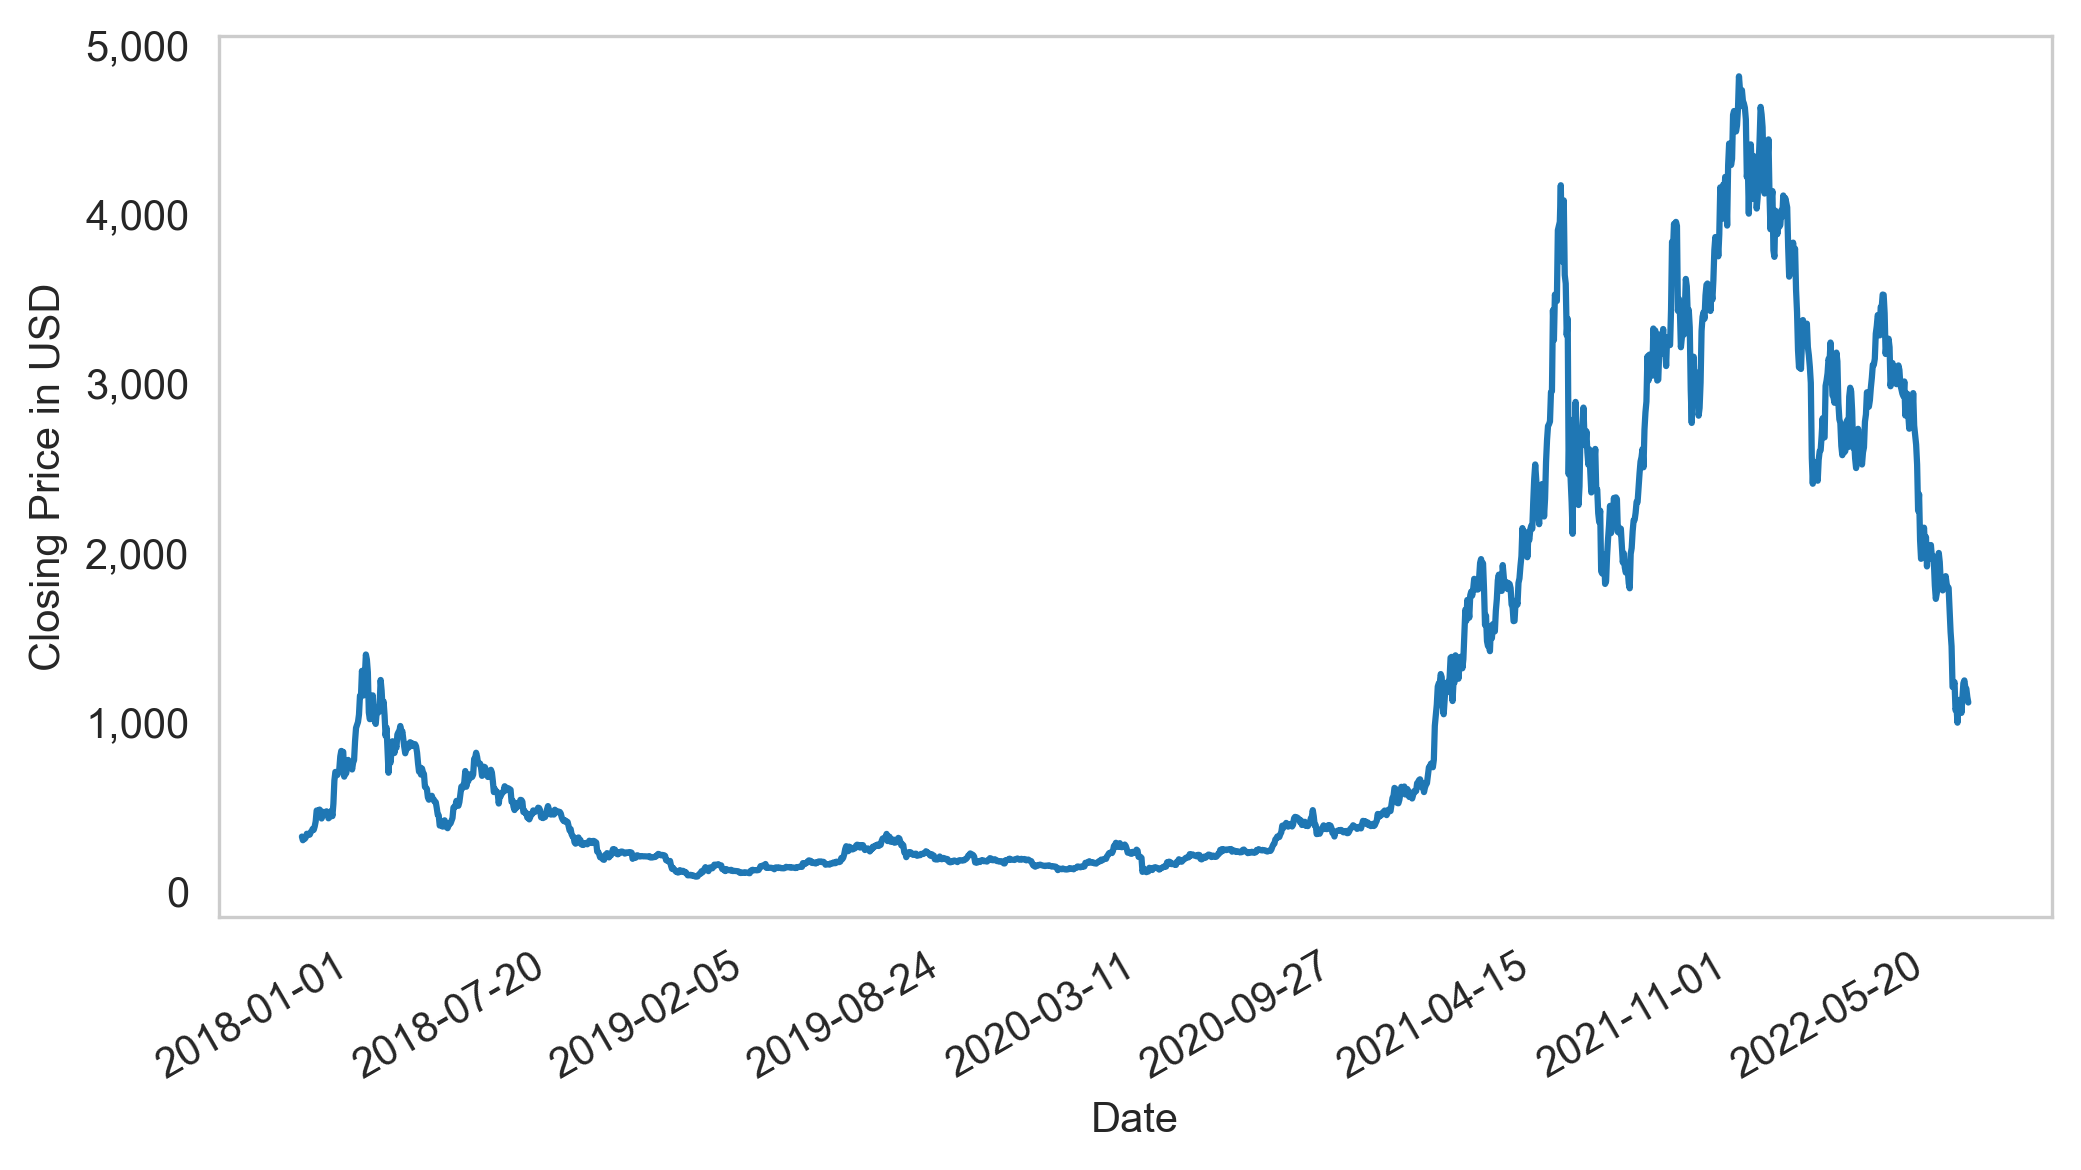

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1494 200
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


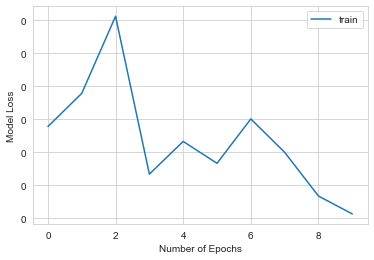

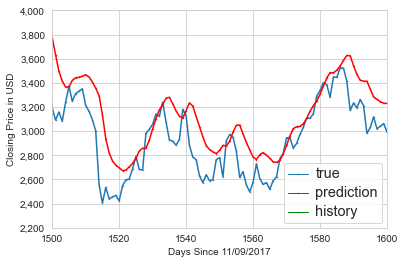

(190,)
(190, 1)
Root mean squared error and time ETH-USD: 271.77334512669785, 10.4135 s
LSTM run 36/200, 10, DOGE-USD


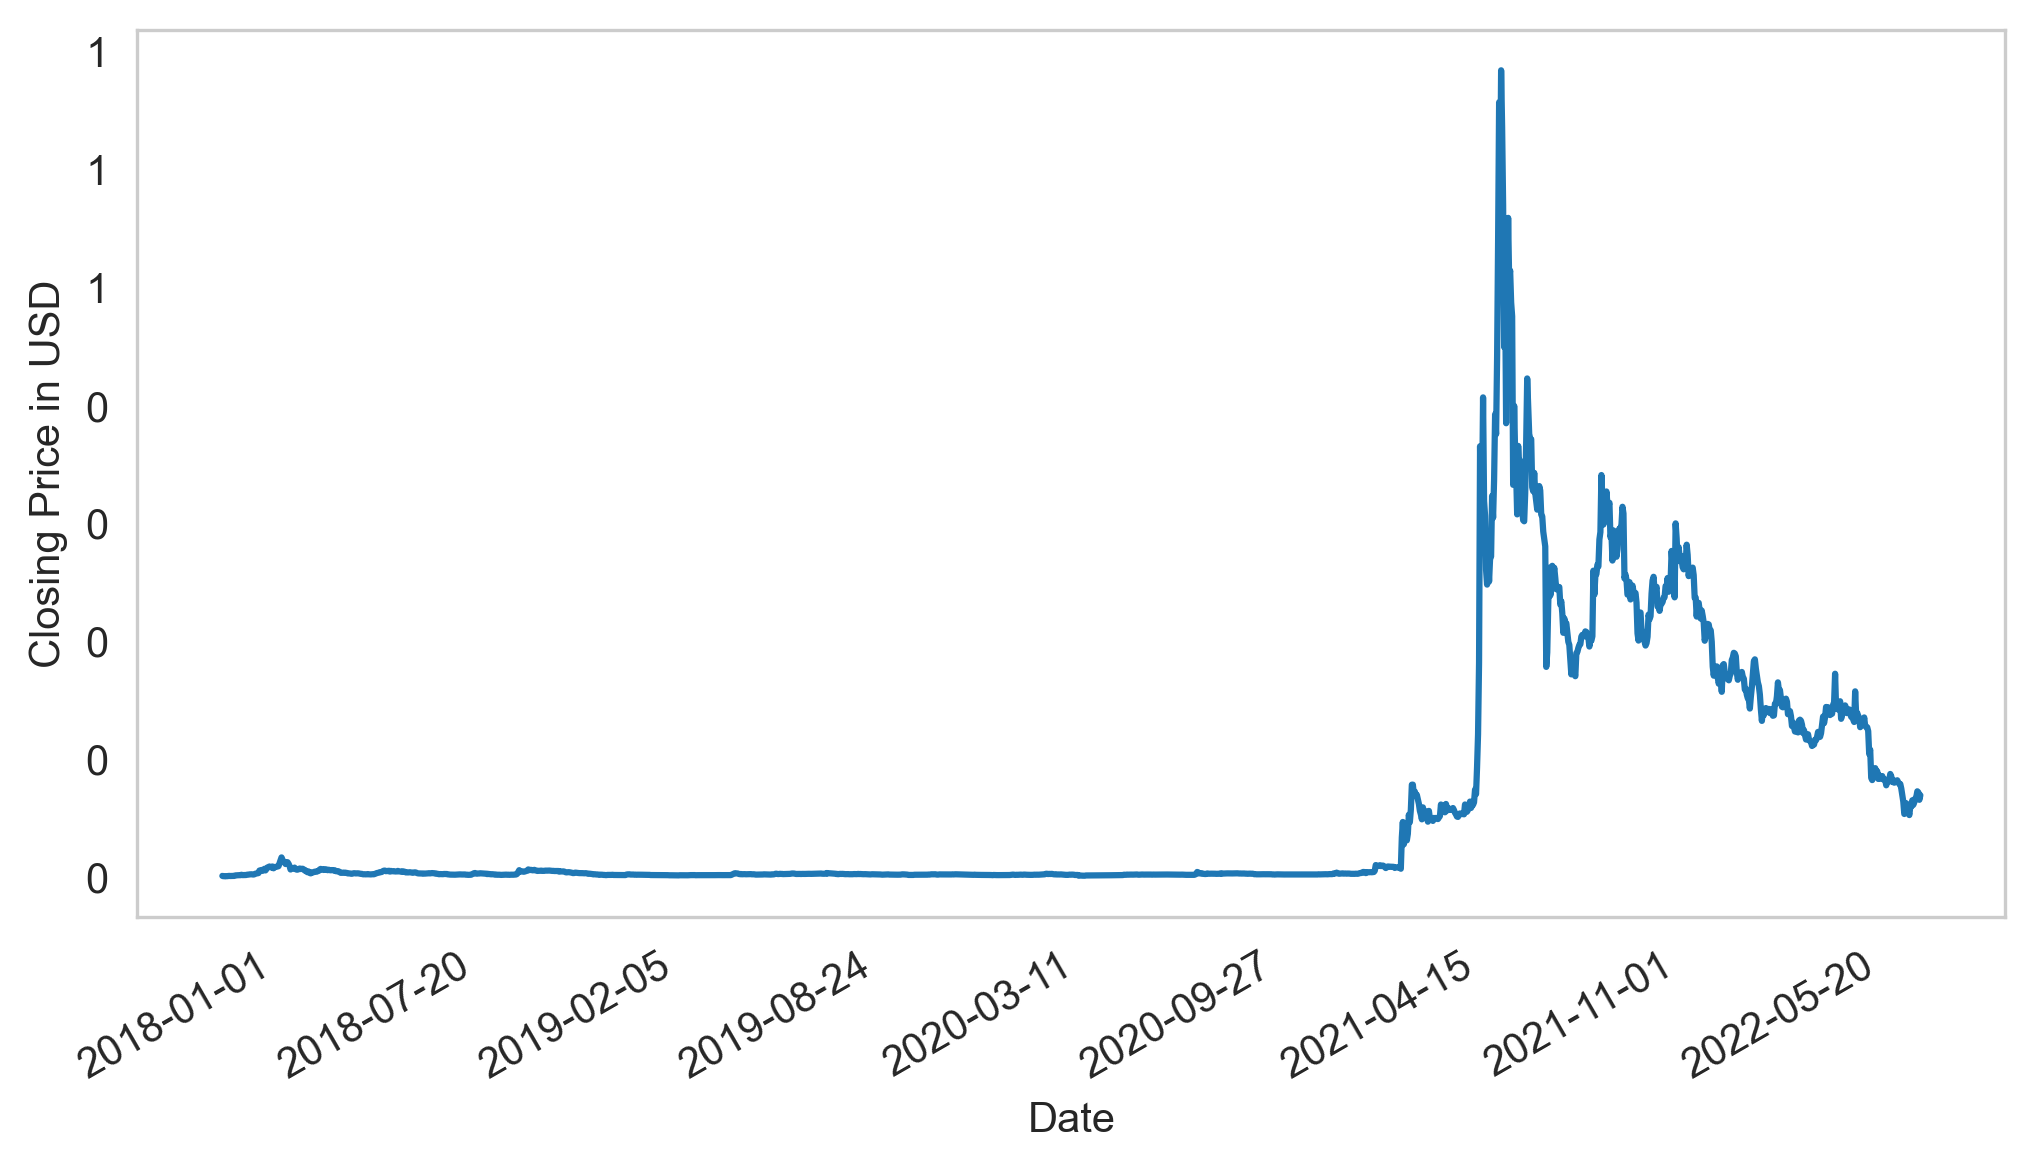

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                Open      High       Low     Close   Volume  Dividends  \
Date                                                                     
2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550          0   
2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520          0   
2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080          0   
2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960          0   
2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 250)               252000    
           

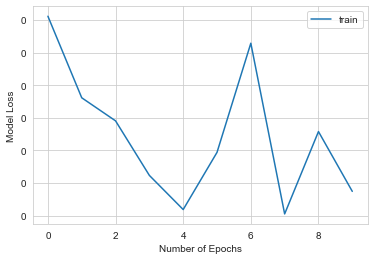

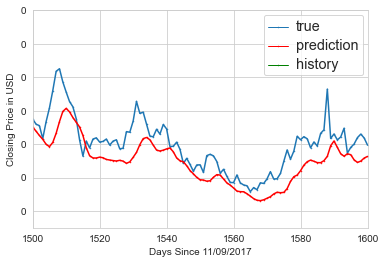

(190,)
(190, 1)
Root mean squared error and time DOGE-USD: 0.011903467517525574, 10.643 s
LSTM run 37/200, 10, DOGE-USD


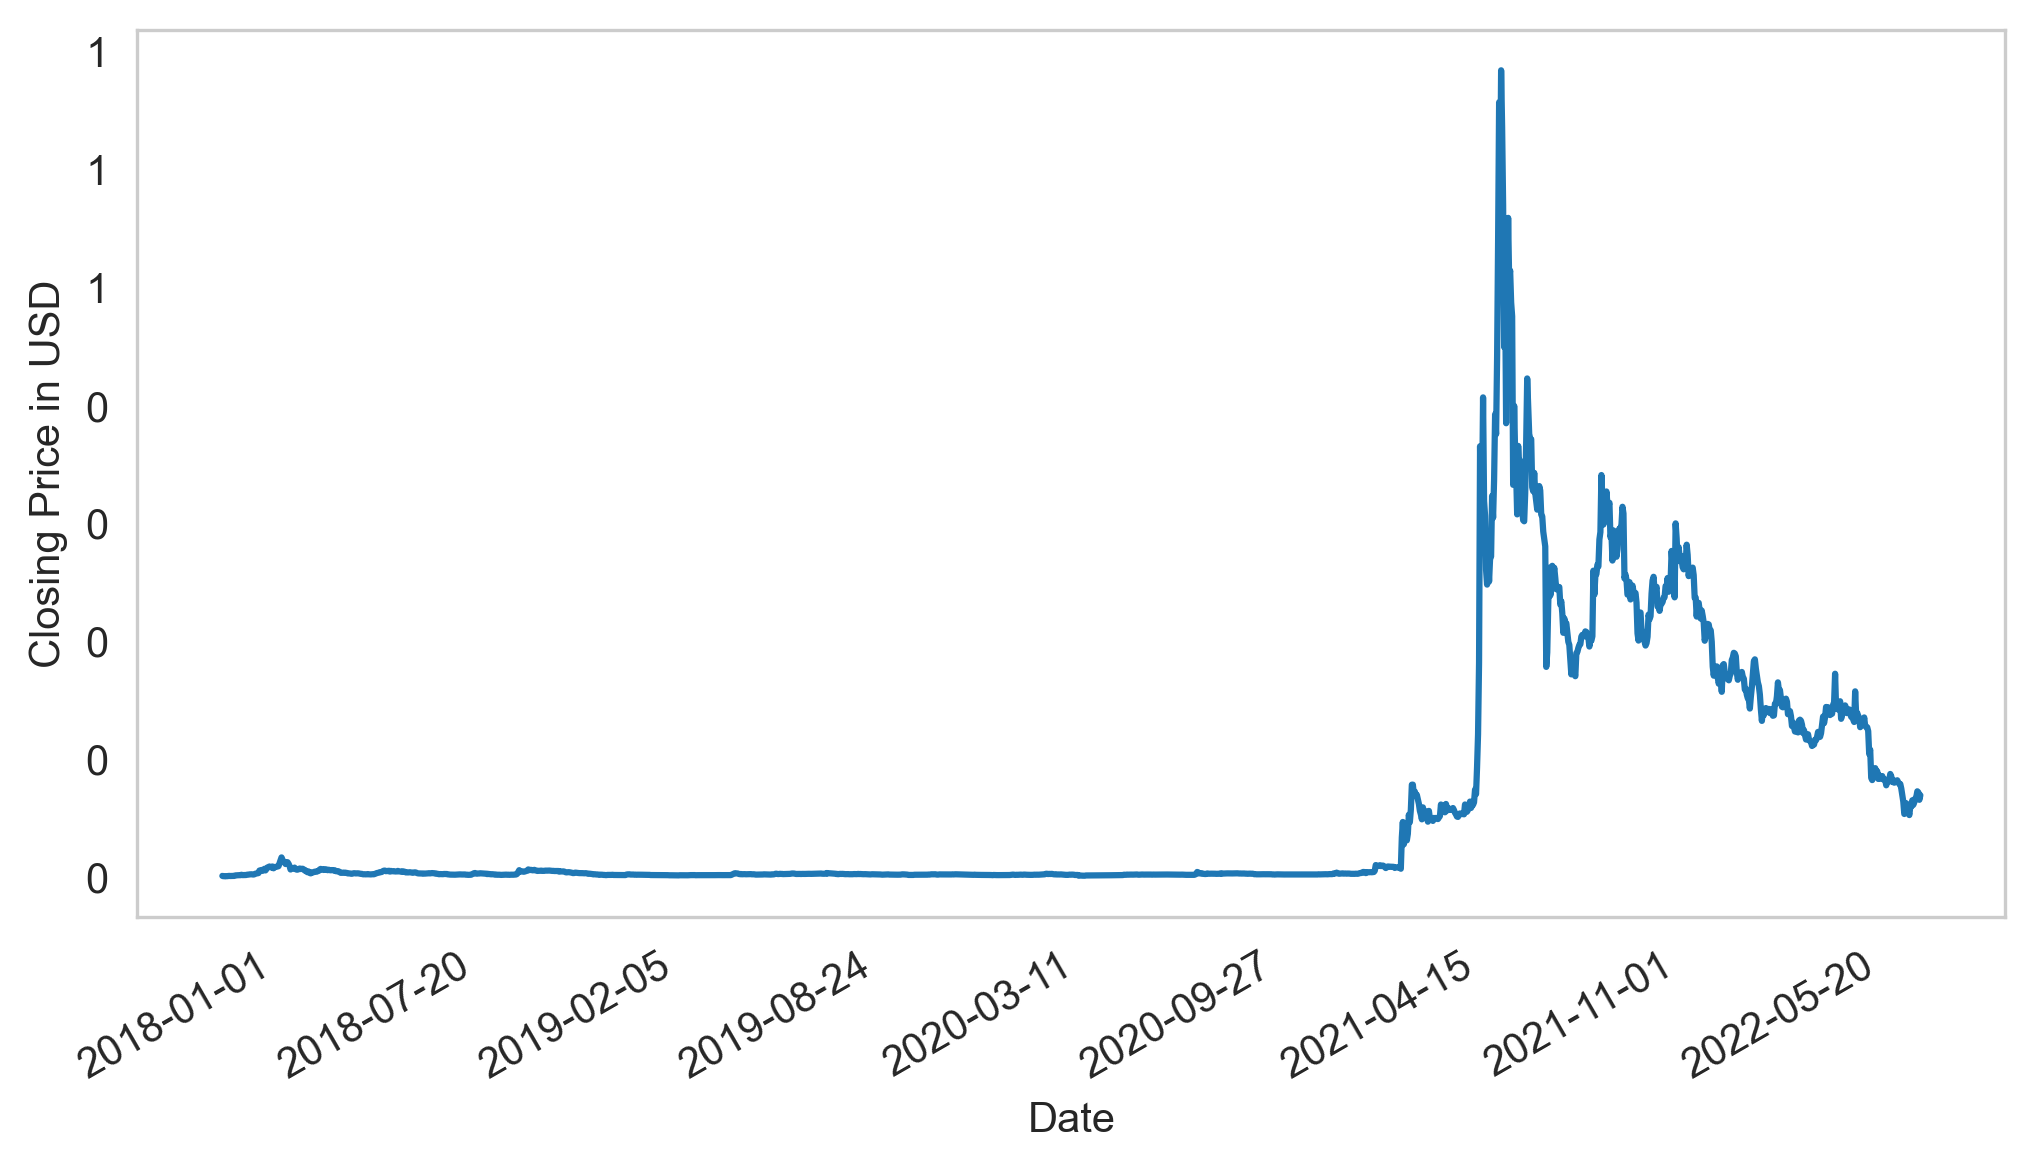

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                Open      High       Low     Close   Volume  Dividends  \
Date                                                                     
2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550          0   
2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520          0   
2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080          0   
2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960          0   
2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1494 200
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 250)               252000    
           

KeyboardInterrupt: 

In [6]:

# list_of_cryptos = ["EOS-USD"]

n = len(epochs) * len(list_of_cryptos) * repeat
counter = 0
for epoch in epochs:
    for crypto in list_of_cryptos:
        for i in range(0,repeat):
            counter = counter + 1
            print(f"LSTM run {counter}/{n}, {epoch}, {crypto}")
            lstm_crypto_benchmark(crypto, id=i, epoch=epoch, output=config.debug)


In [ ]:

StopWatch.stop('all')
benchmark_filename = f"benchmarks/{config.user}-{config.node}.log"
# StopWatch.benchmark(user=config.user, node=config.node, tag=crypto)
StopWatch.benchmark(filename=benchmark_filename, user=config.user, node=config.node, tag=crypto)
